In [1]:
# For conveniance: 
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path
from dotenv import load_dotenv

working_dir = Path.cwd()
while working_dir.name != 'CausalMTR-BC':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'CausalMTR-BC' not found")
os.chdir(working_dir)

# Load env variables from config/.env 
dotenv_path = Path("configs/.env")
load_dotenv(dotenv_path=dotenv_path)

from gpudrive.env.config import EnvConfig, SceneConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader

In [2]:
DYNAMICS_MODEL = "delta_local" # "delta_local" / "state" / "classic"
DATA_PATH = "data/processed/examples" # Your data path
MAX_NUM_OBJECTS = 64
NUM_ENVS = 4
DEVICE = "cuda:1"

# Configs
env_config = EnvConfig(dynamics_model=DYNAMICS_MODEL)

In [3]:
# Make dataloader
data_loader = SceneDataLoader(
    root="gpudrive/data/processed/examples", # Path to the dataset
    batch_size=NUM_ENVS, # Batch size, you want this to be equal to the number of worlds (envs) so that every world receives a different scene
    dataset_size=NUM_ENVS, # Total number of different scenes we want to use
    sample_with_replacement=False, 
    seed=42, 
    shuffle=True,   
)

print("Making the environment")

# Make environment
env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=data_loader,
    max_cont_agents=MAX_NUM_OBJECTS, # Maximum number of agents to control per scenario
    device="cuda", 
    action_type="continuous" # "continuous" or "discrete"
)

Making the environment
Compiling GPU engine code:
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/memory.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/state.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/crash.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/consts.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/taskgraph.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/taskgraph_utils.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/sort_archetype.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/host_print.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/../common/hashmap.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/../common/navmesh.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/../core/base.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/../physics/physics.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/../physics/geo.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/../physics/xpbd.cpp
/Ca

/CausalMTR-BC/gpudrive/src/level_gen.cpp(283): warning #177-D: function "madrona_gpudrive::createFloorPlane" was declared but never referenced
  static void createFloorPlane(Engine &ctx)
              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"





In [4]:
from cmtr_bc.waymo_dataset import WaymoDataset
import yaml 
from easydict import EasyDict
import logging
import torch
import numpy as np

In [5]:
def getconfig(cfg_file):
    with open(cfg_file, 'r') as f:
        try:
            config = yaml.load(f, Loader=yaml.FullLoader)
        except:
            config = yaml.load(f)

    return EasyDict(config)

logger = logging.getLogger(__name__)

config = getconfig("configs/config.yaml")
waymo_dataset = WaymoDataset(config.DATA_CONFIG, test_mode=1, logger=logger)

In [6]:
from mtr.models import model as model_utils
from cmtr_bc.waymo_iterator import TrajectoryIterator
from torch.utils.data import DataLoader

/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/colt5_attention/triton_coor_descent.py:314: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/colt5_attention/triton_coor_descent.py:410: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [8]:
traj_data_loader = TrajectoryIterator(env, data_loader, cmtr=True, waymo_dataset=waymo_dataset, prior_frame=20, future_frame=40, simple=False)
train_iterator = iter(DataLoader(traj_data_loader, batch_size=2, collate_fn=traj_data_loader.collate_batch))

In [9]:
MODEL_DEVICE = "cuda:1"
model_cfg = config.MODEL
model_cfg.CONTEXT_ENCODER.NUM_INPUT_ATTR_AGENT = 38
model_cfg.CONTEXT_ENCODER.NUM_ATTN_LAYERS = 1
model_cfg.CONTEXT_ENCODER.NUM_CHANNEL_IN_MLP_AGENT = 64
model_cfg.MOTION_DECODER.NUM_DECODER_LAYERS = 1
model_cfg.MOTION_DECODER.NUM_FUTURE_FRAMES = 40
torch.cuda.set_device(1)
model = model_utils.MotionTransformer(config=model_cfg).to(MODEL_DEVICE)

In [10]:
from tqdm import tqdm
from cmtr_bc.batch_dict_visualization import plot_scenario
import matplotlib.pyplot as plt
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend inline version unknown.


  0%|          | 0/500 [00:00<?, ?it/s]/CausalMTR-BC/CMTR/mtr/ops/knn/knn_utils.py:70: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  idx = torch.cuda.IntTensor(n, k).zero_()
100%|█████████▉| 498/500 [00:53<00:00, 20.50it/s]DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/c

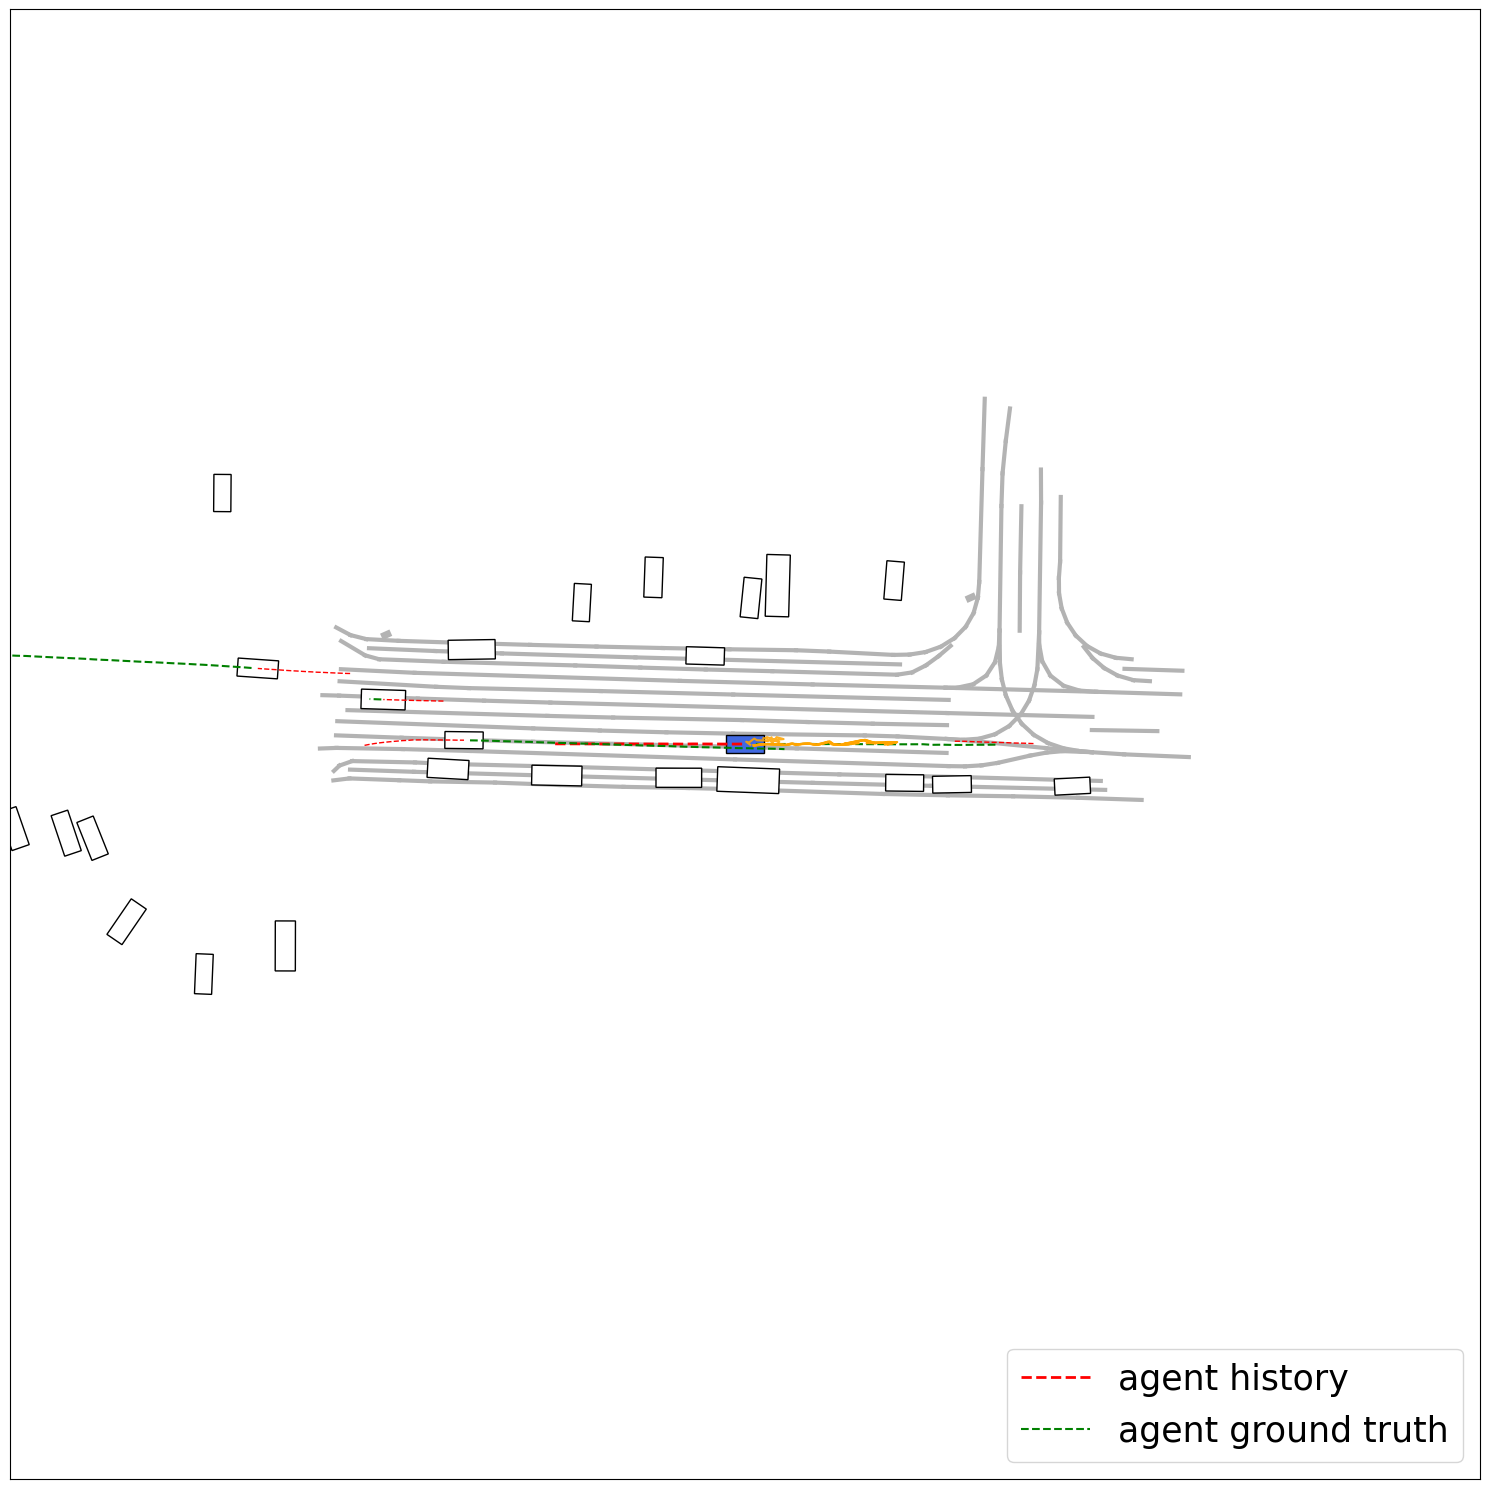

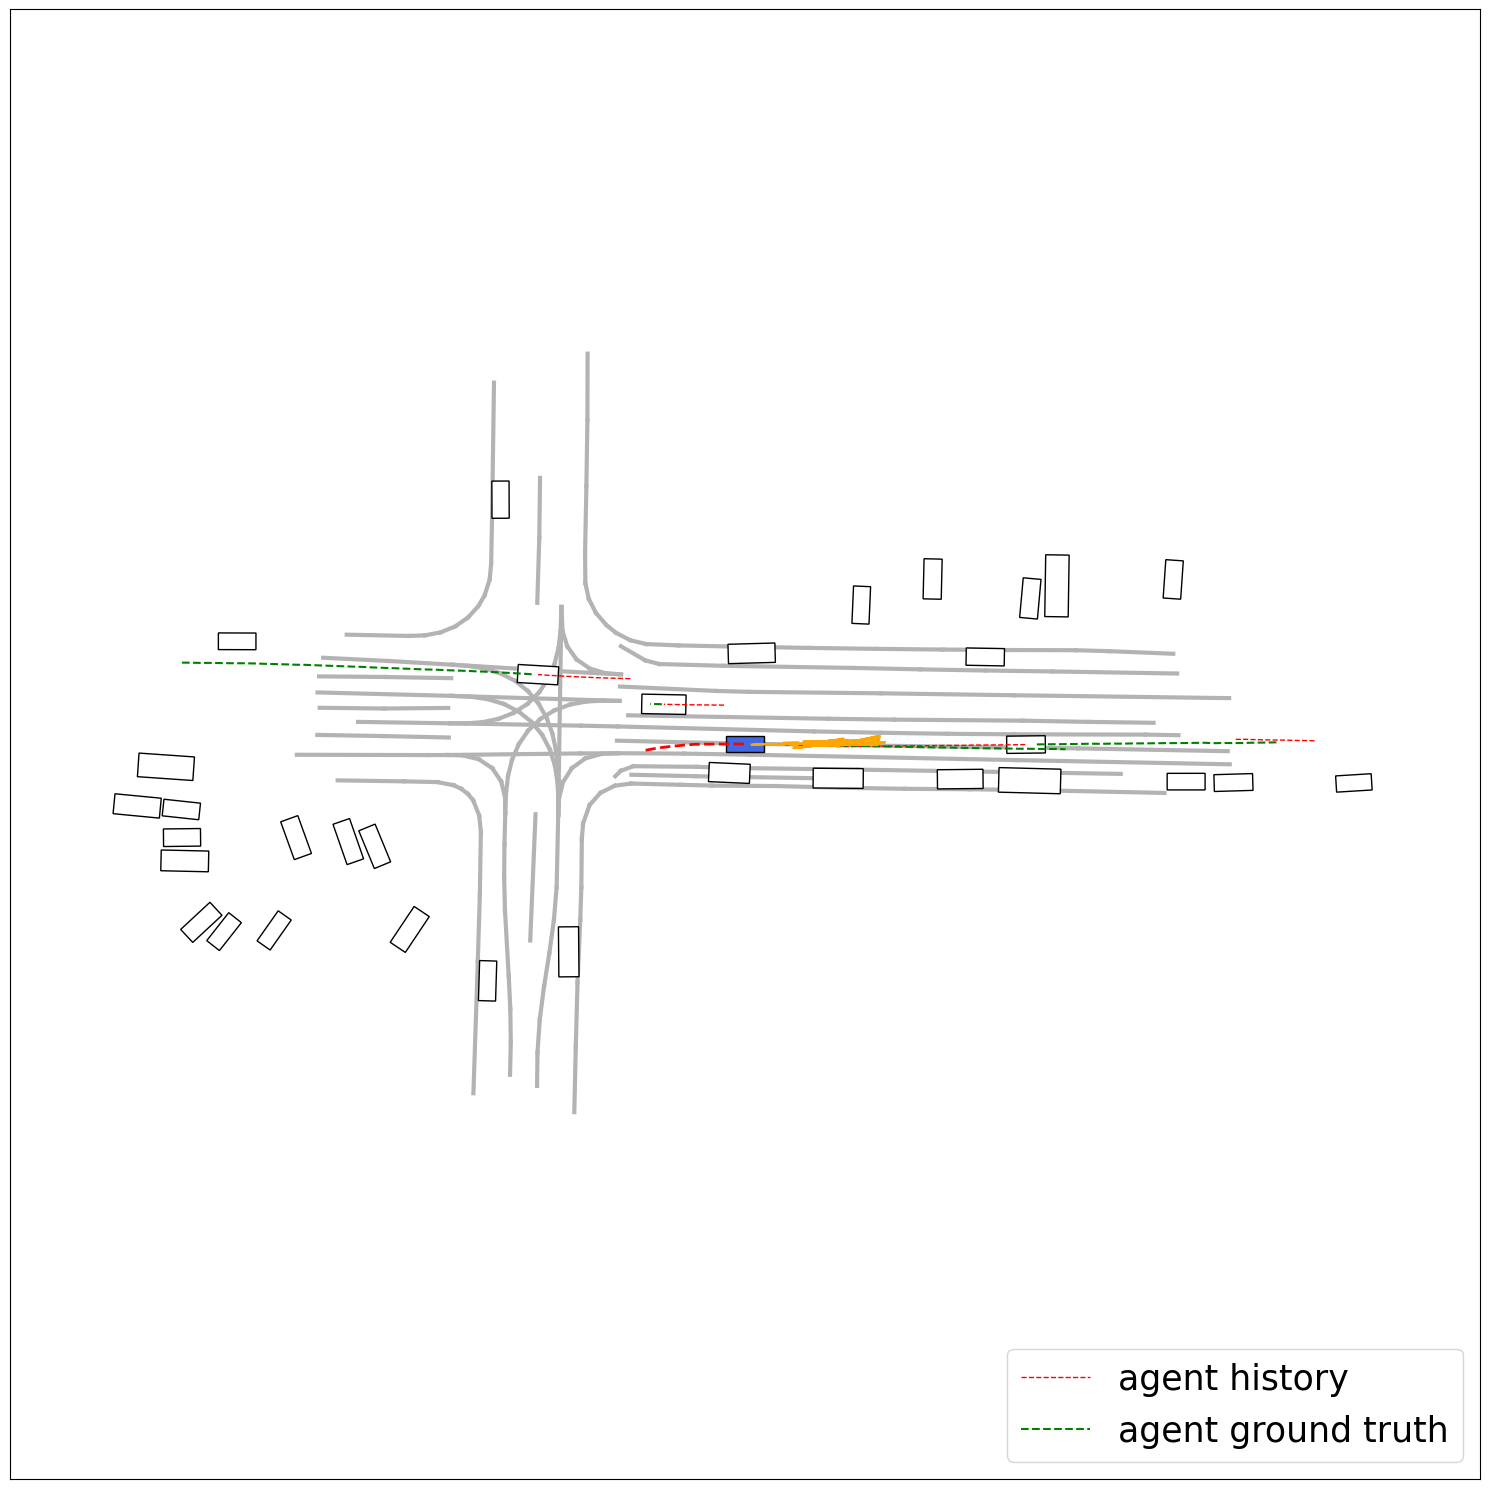

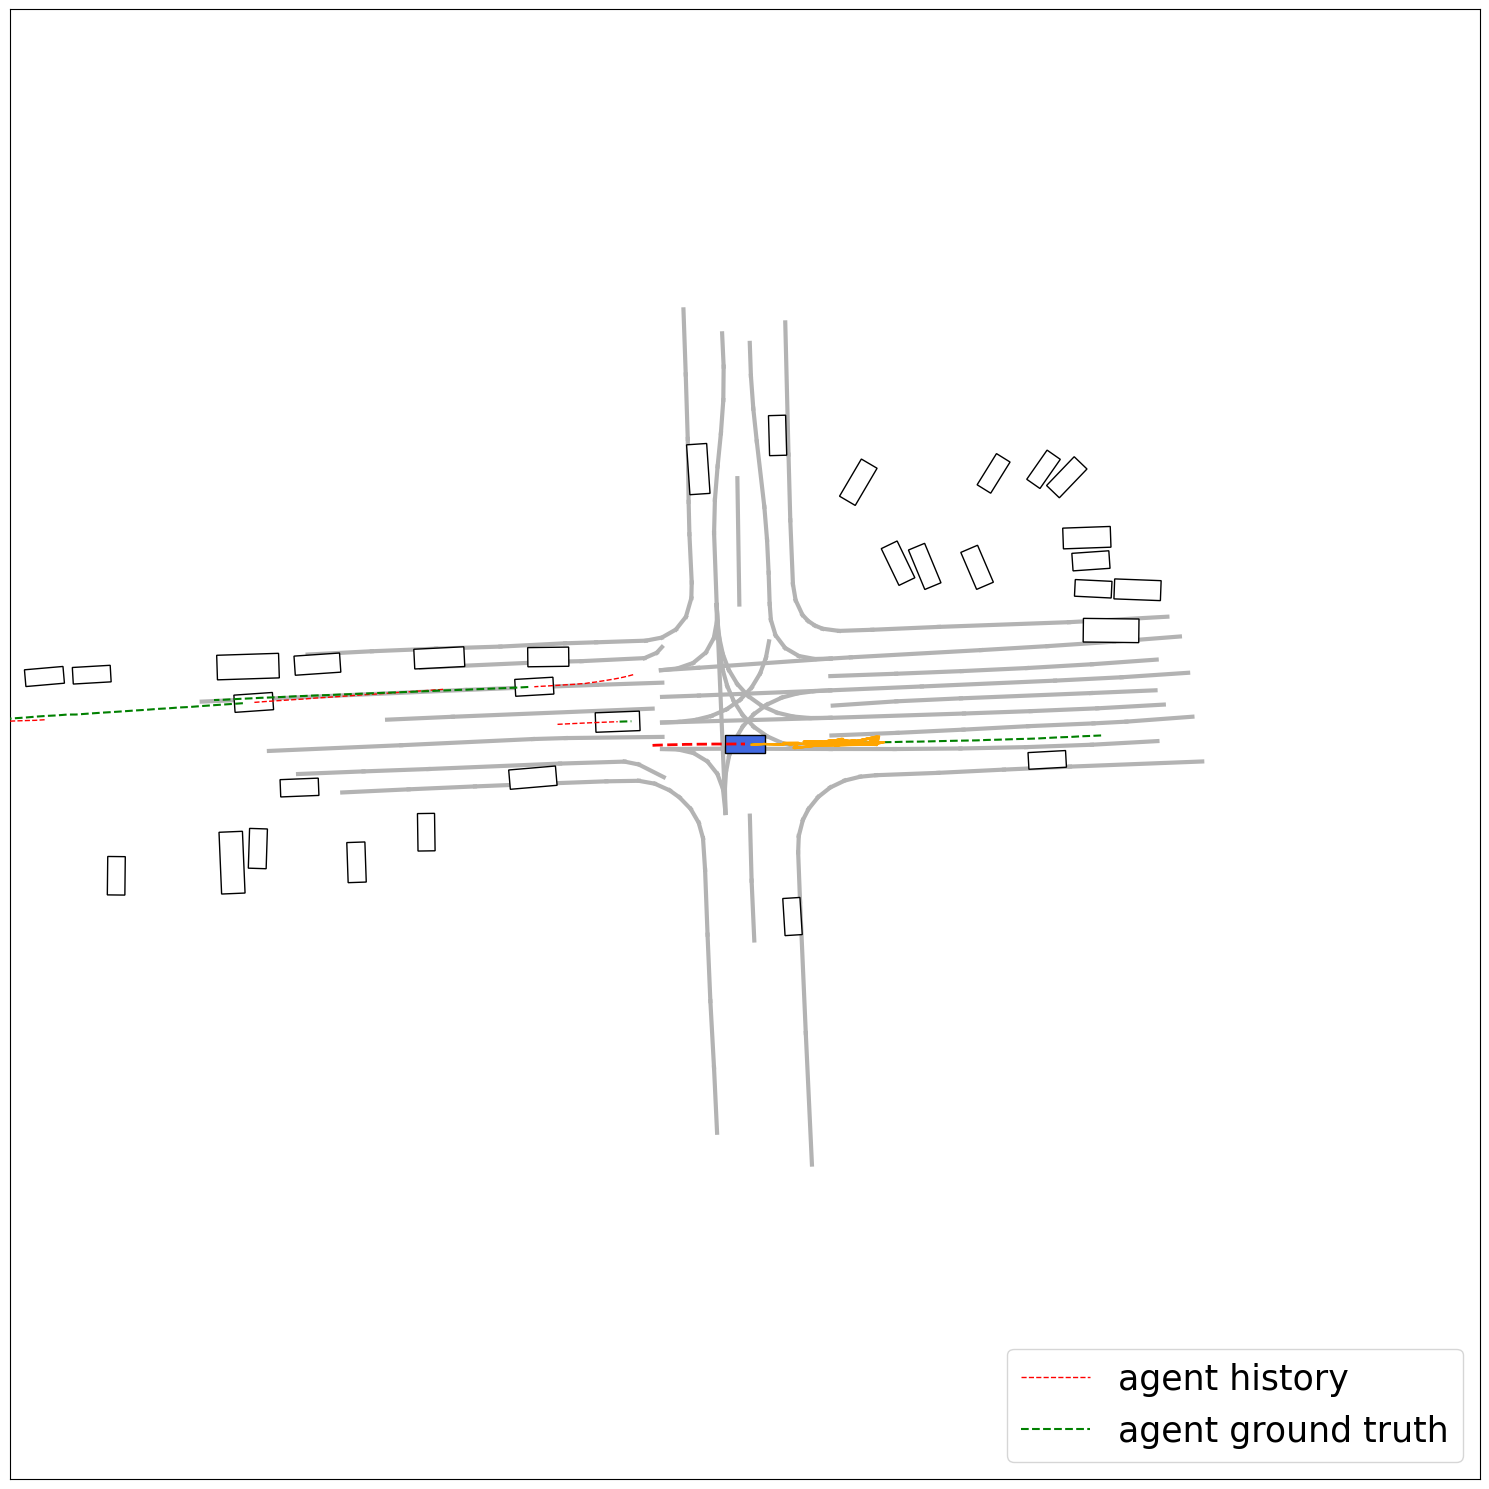

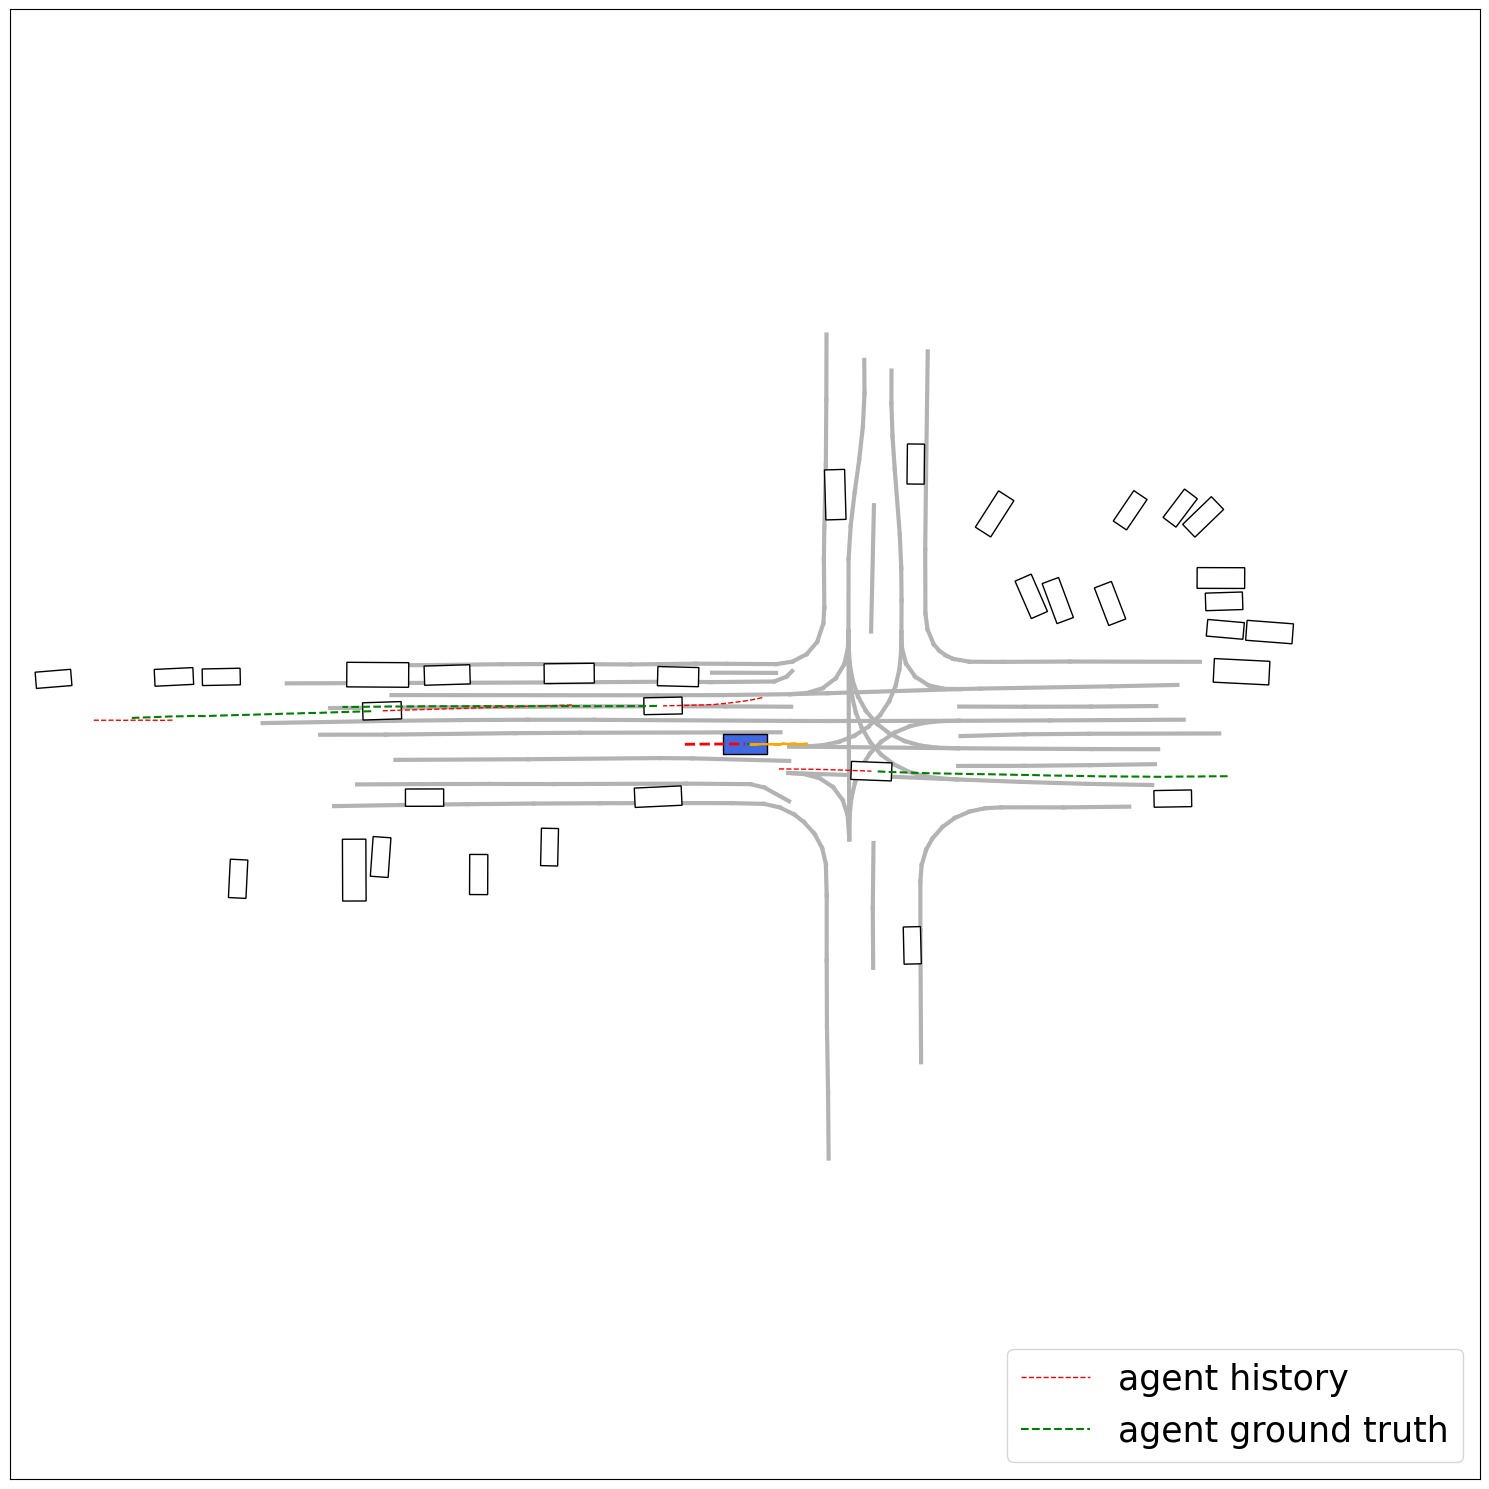

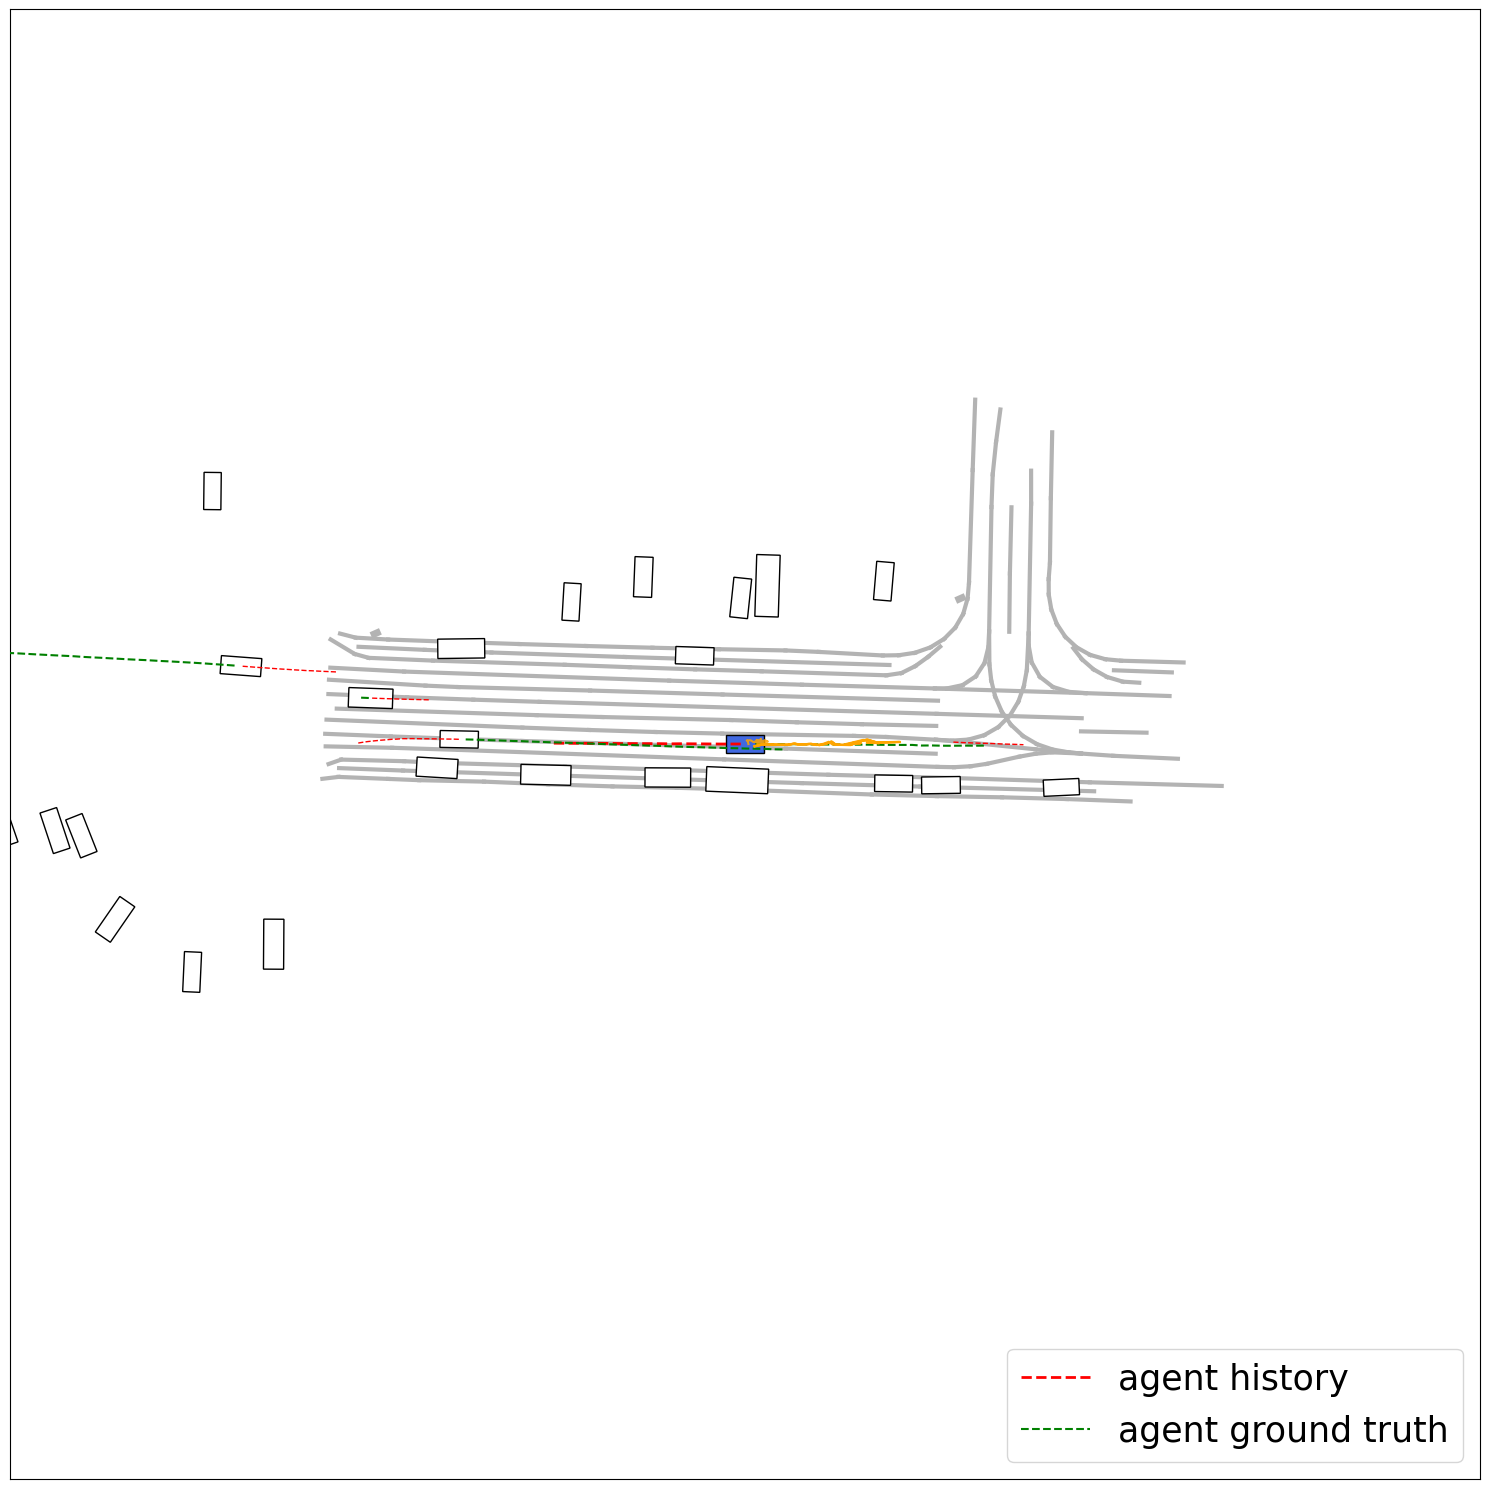

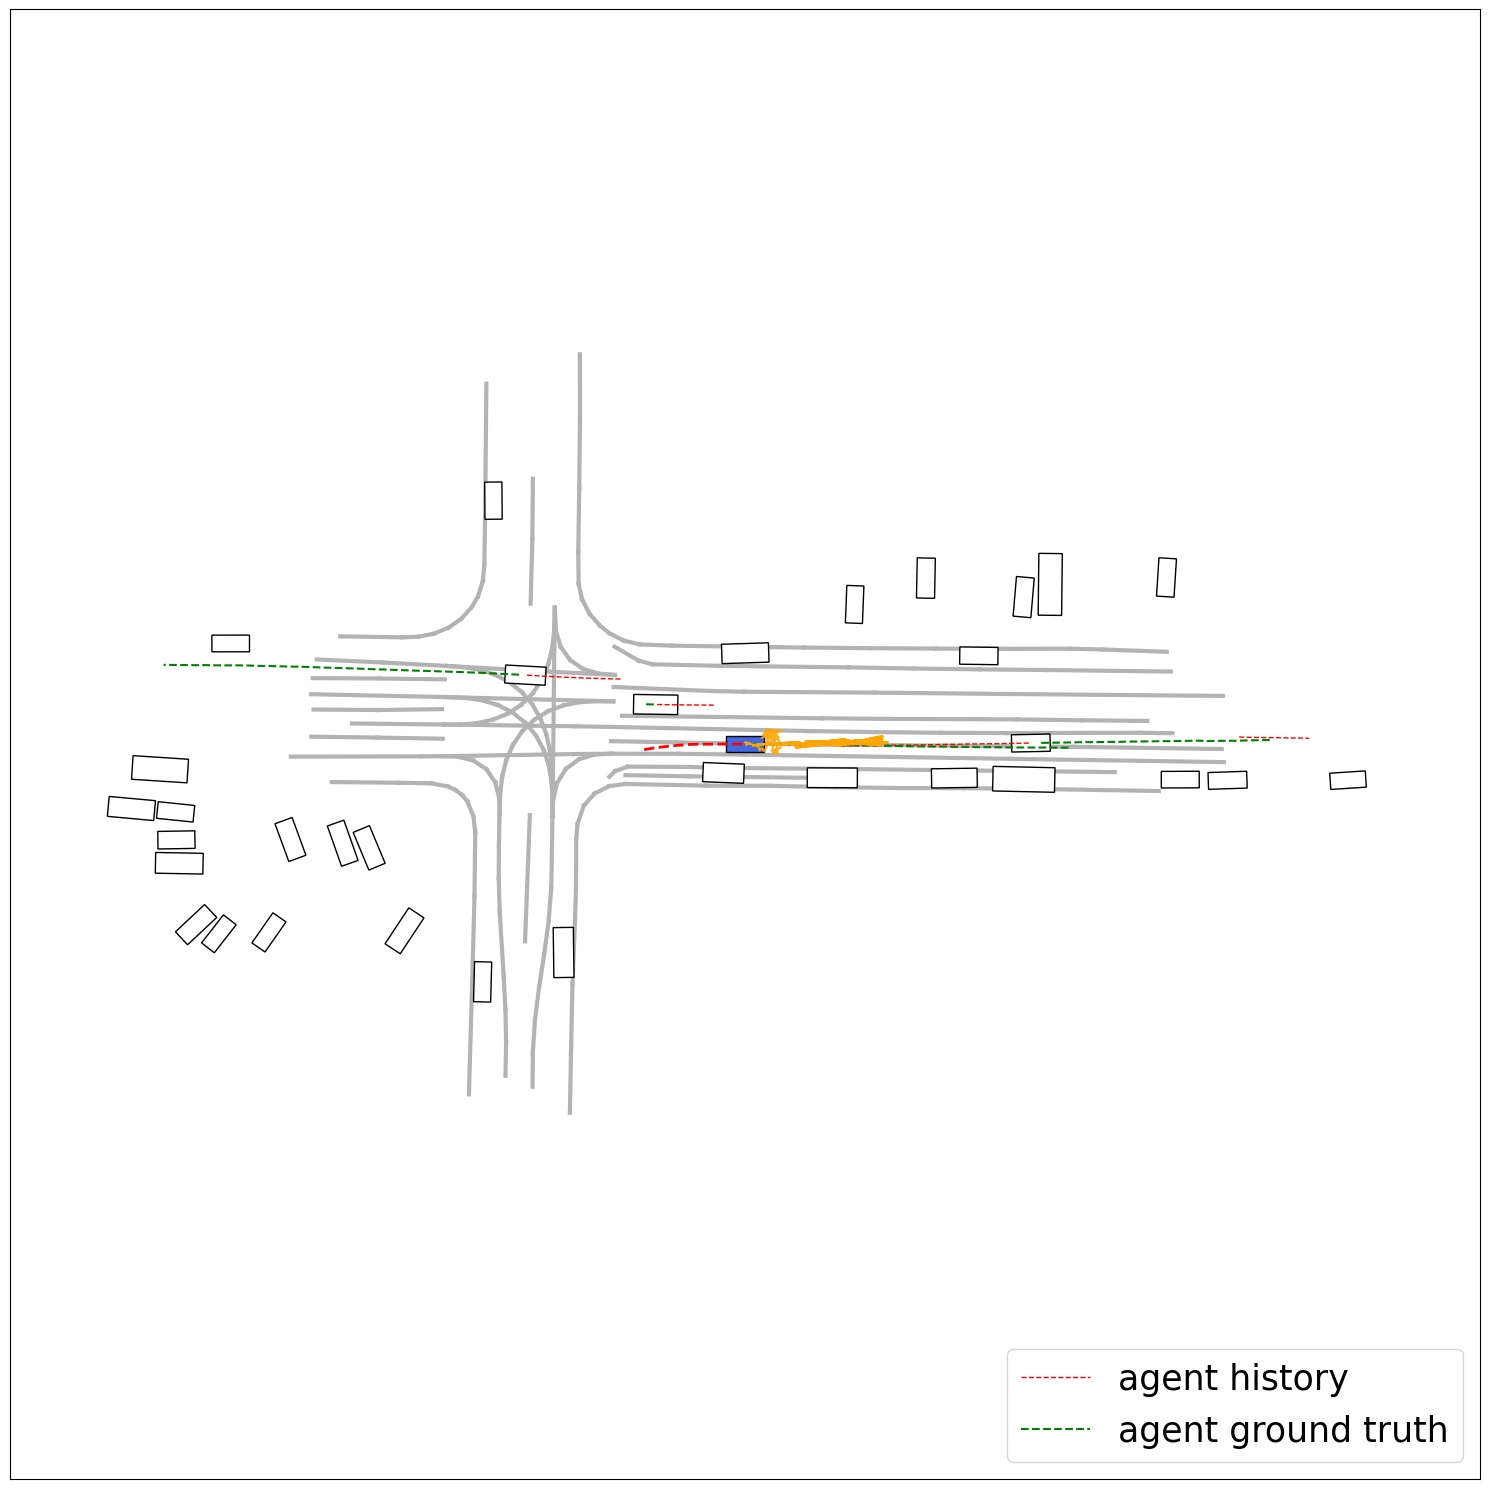

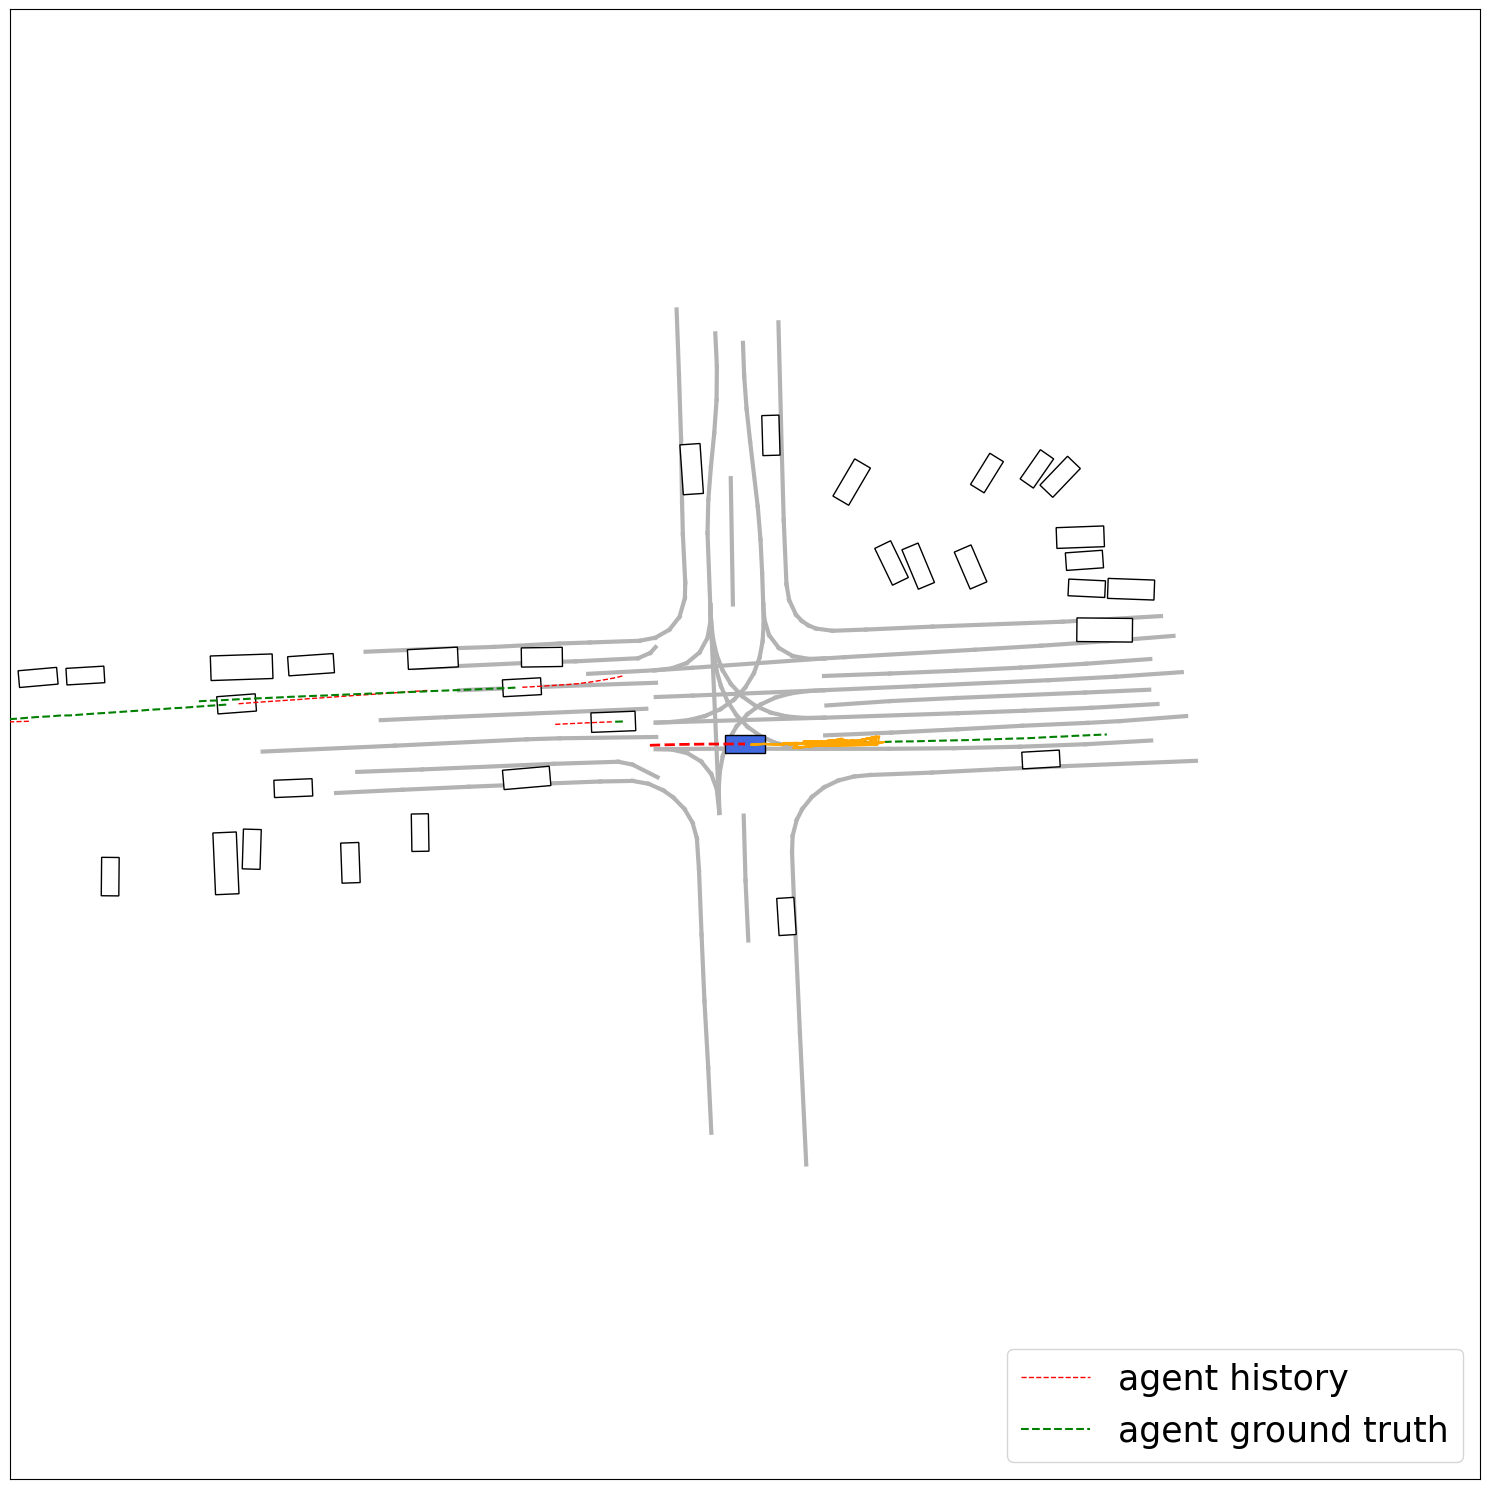

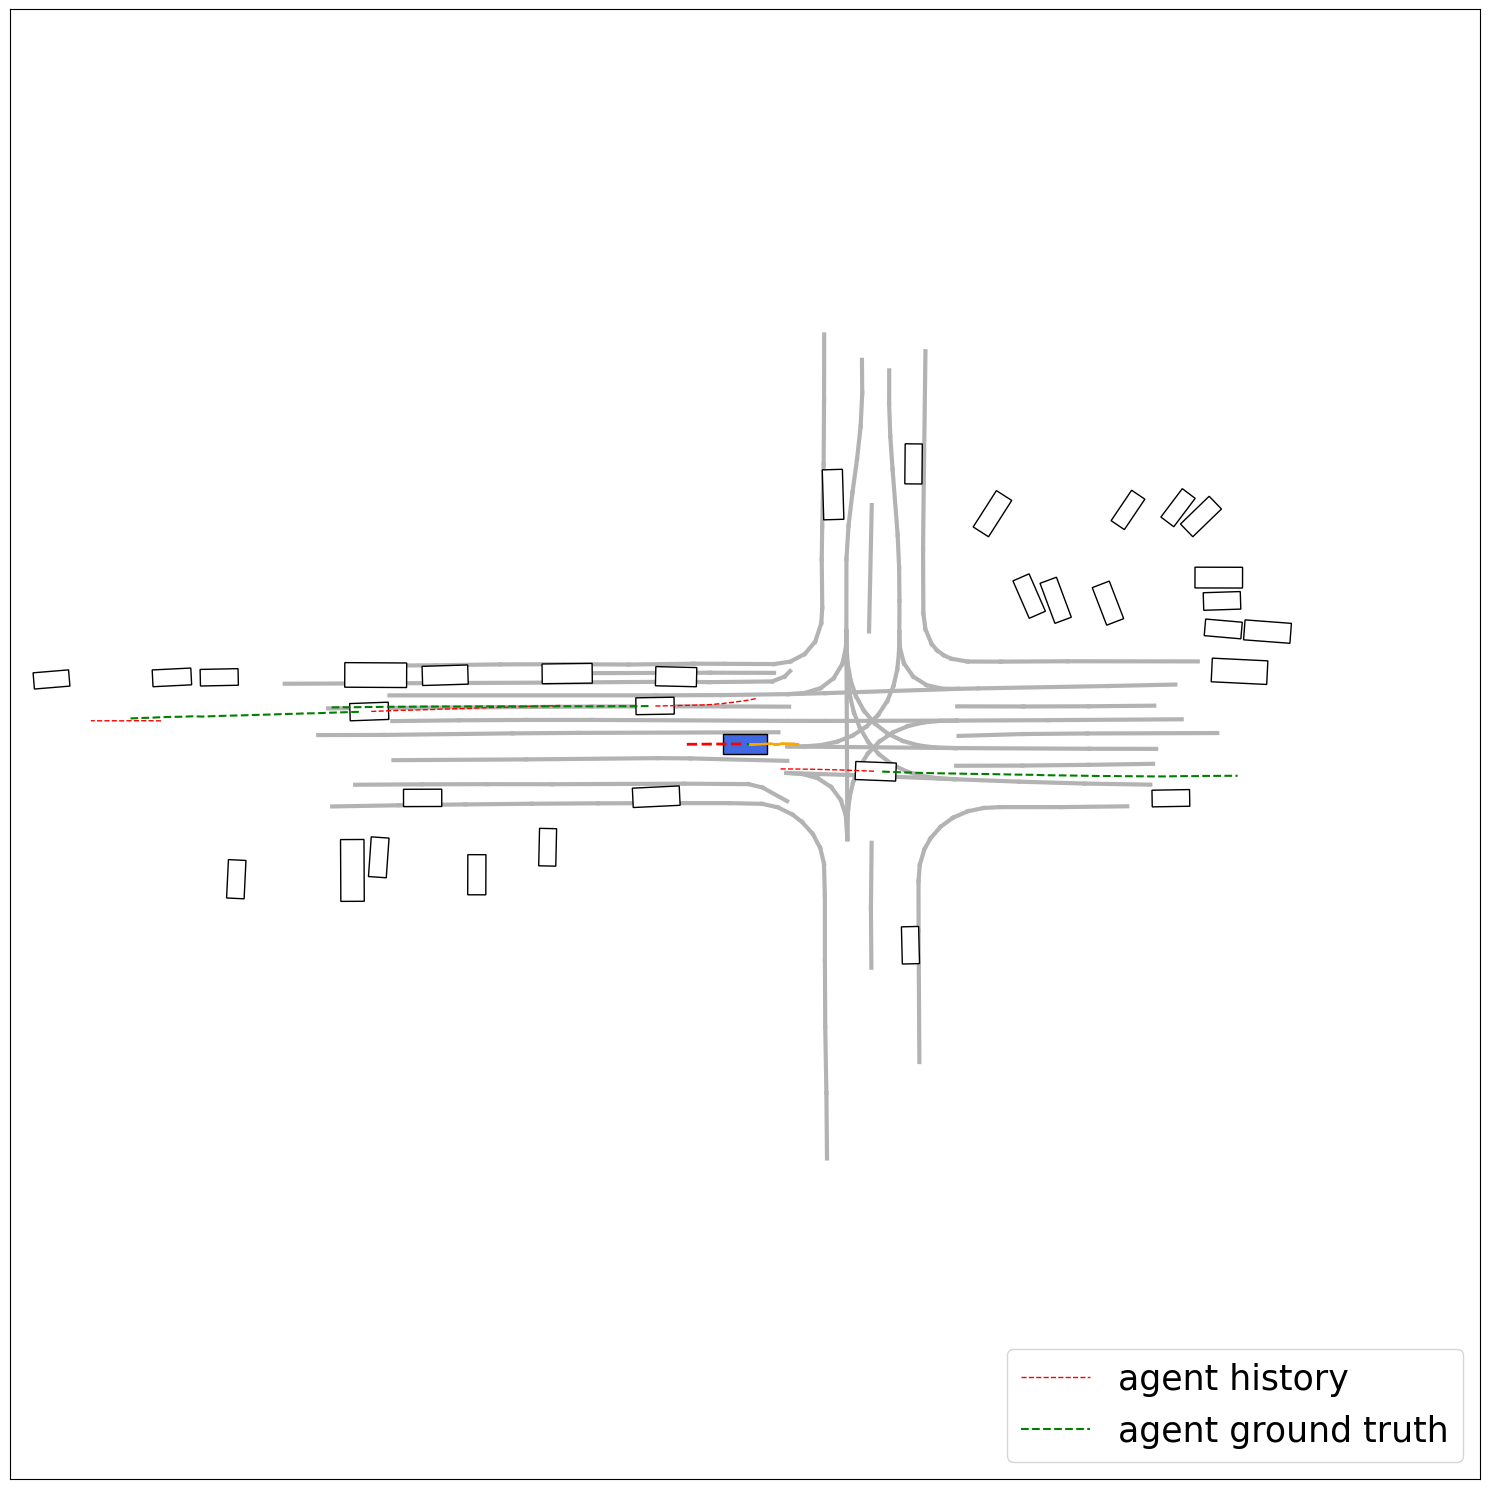

100%|██████████| 500/500 [00:55<00:00,  9.03it/s]
INFO:root:Epoch: 1, Last loss: 193.94454956054688
100%|█████████▉| 498/500 [00:52<00:00, 19.70it/s]

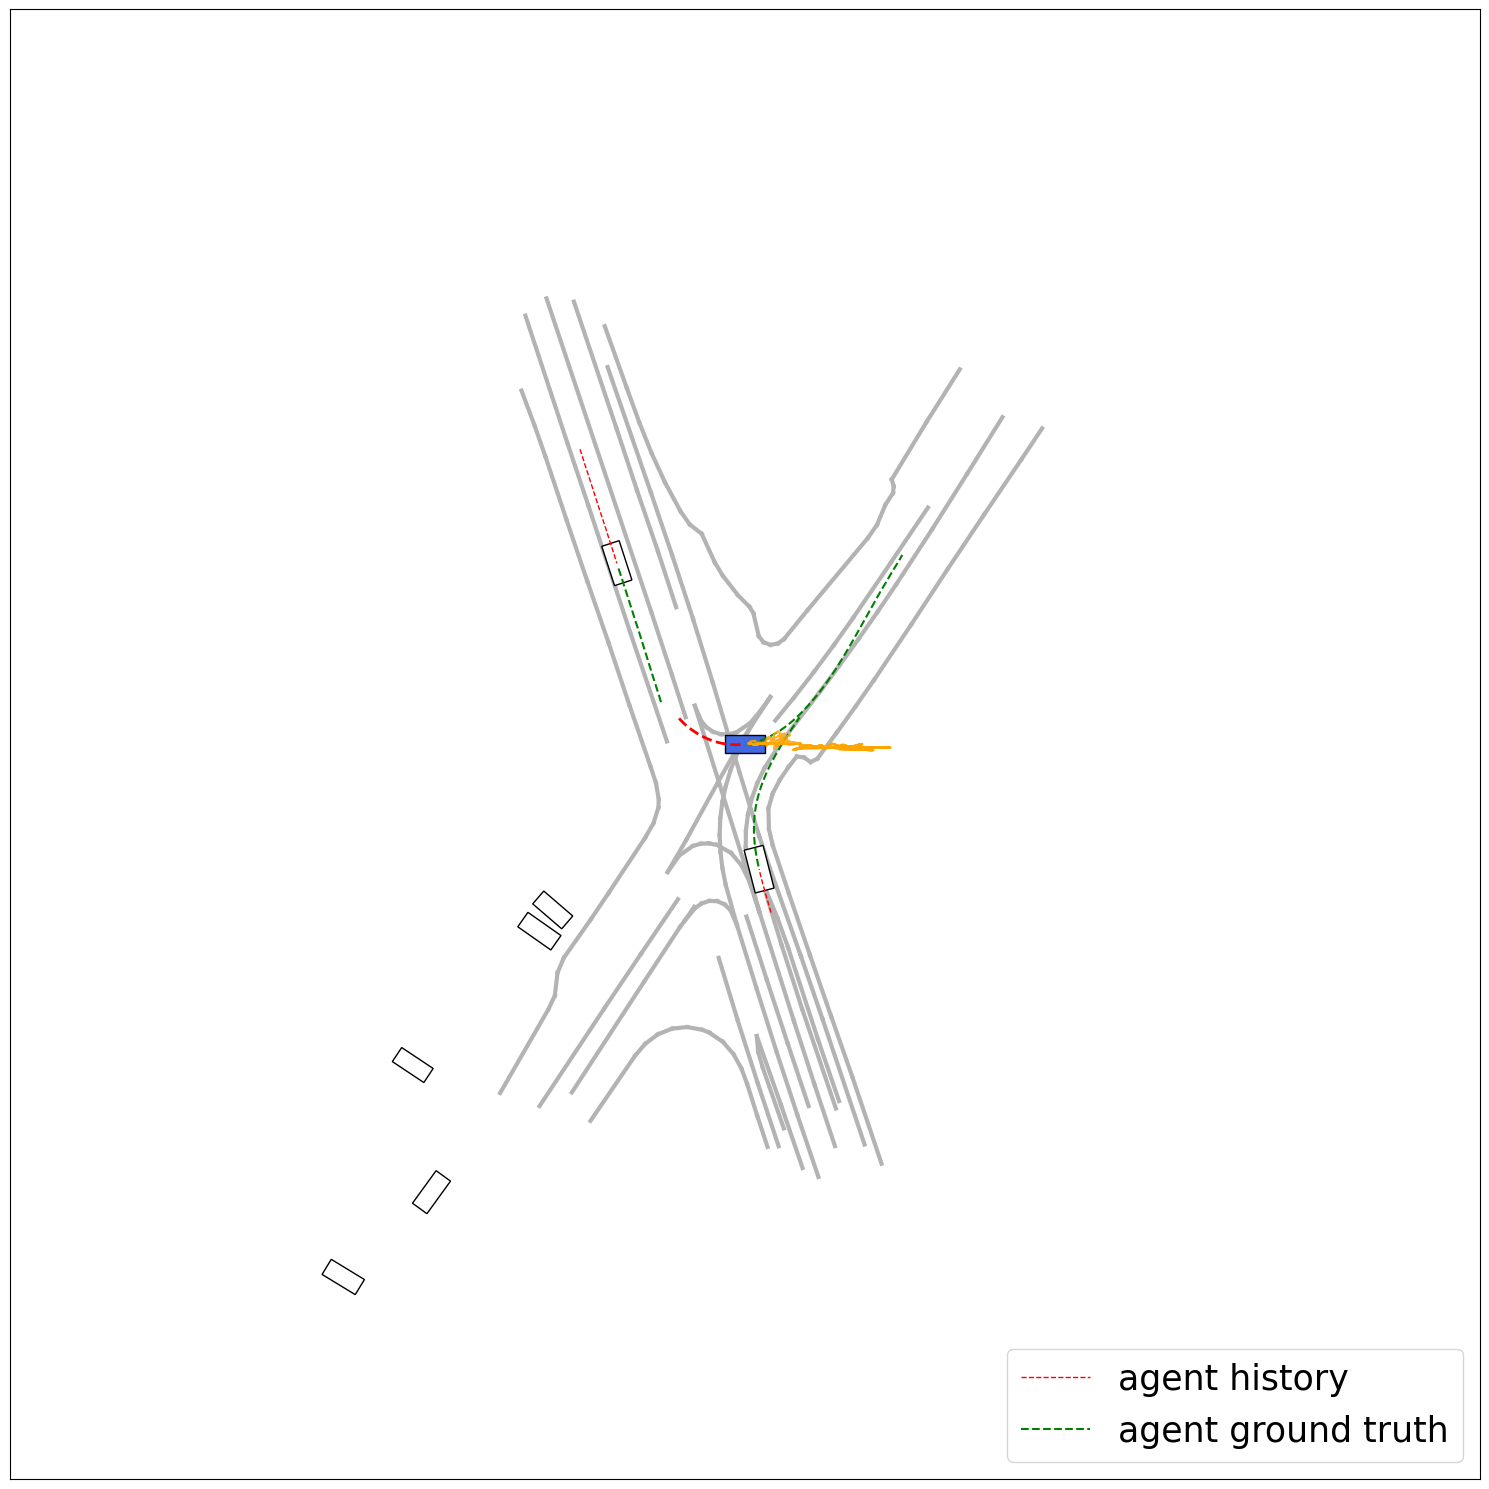

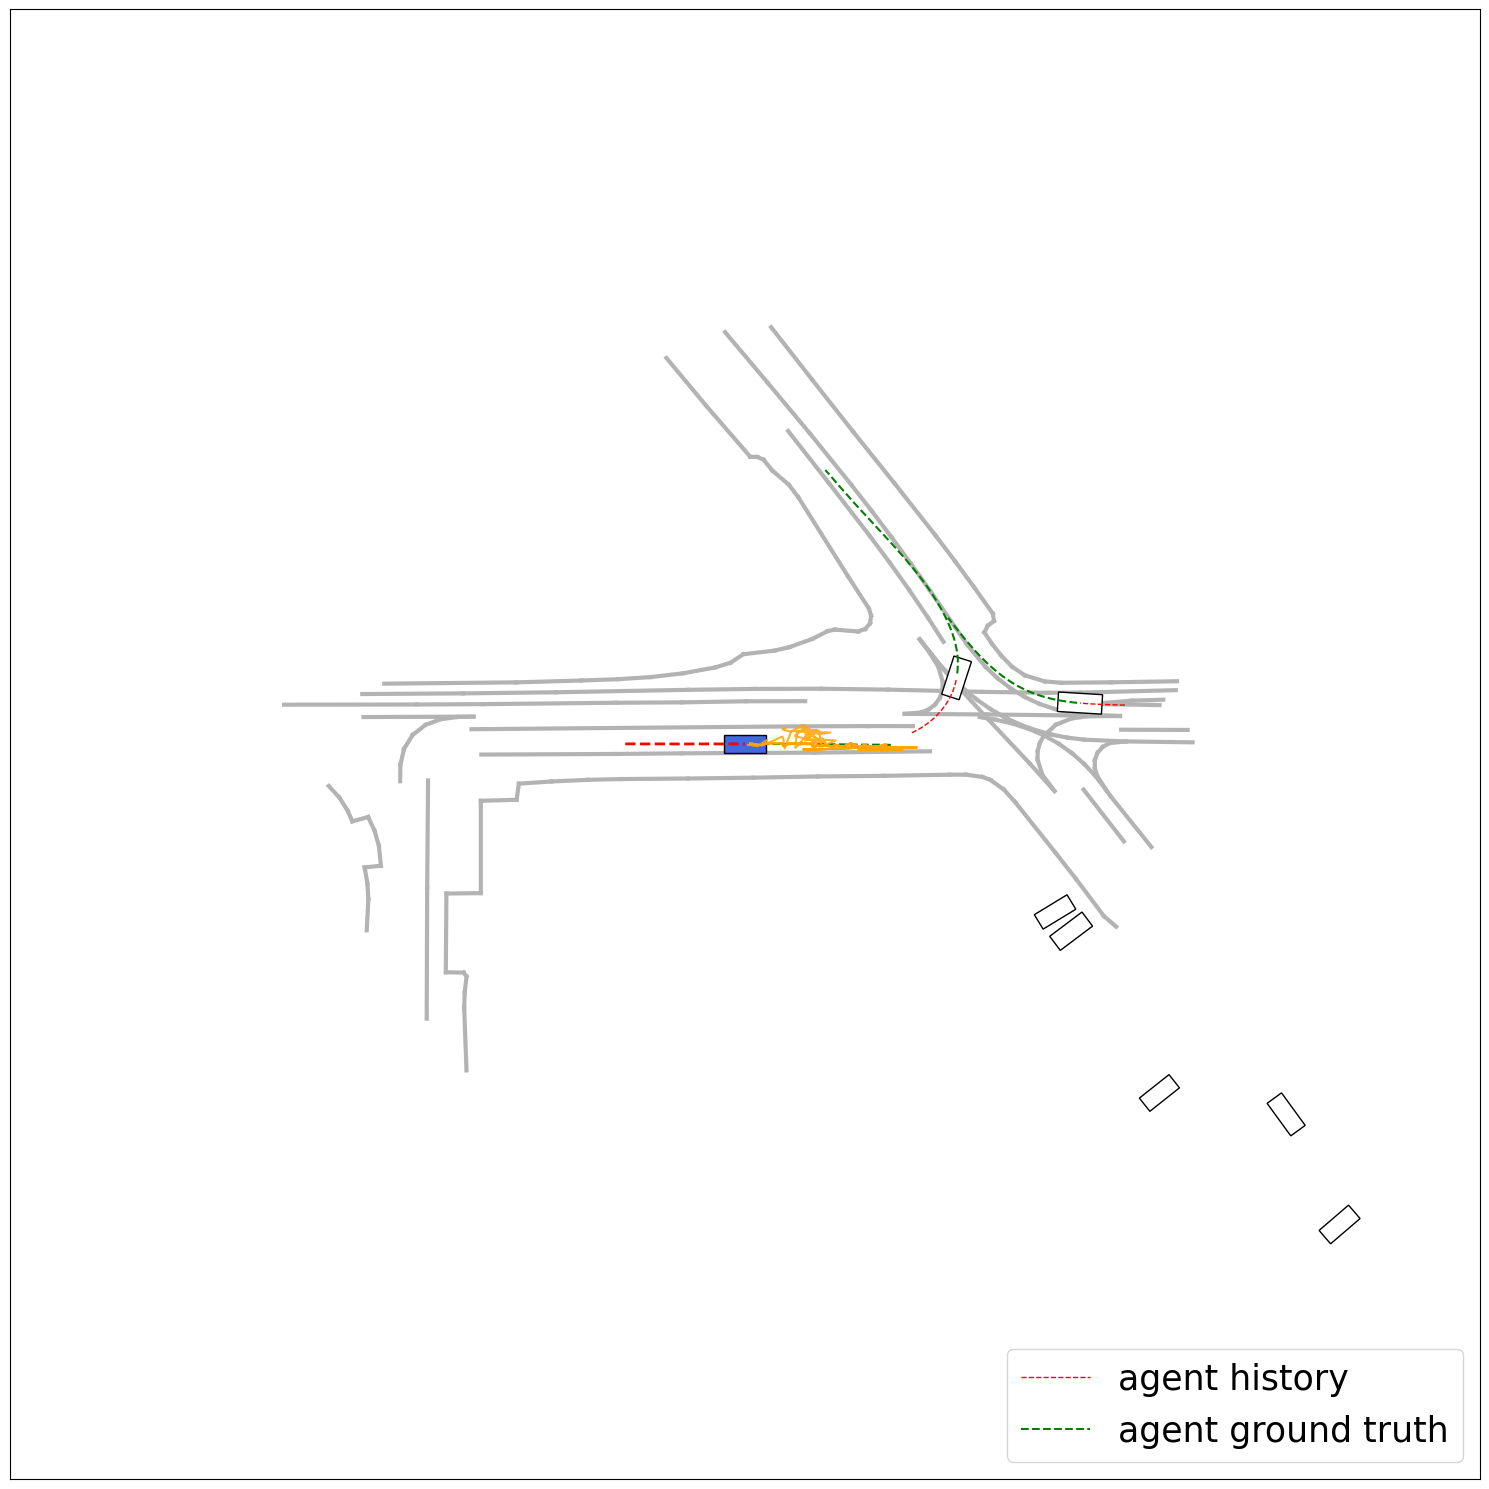

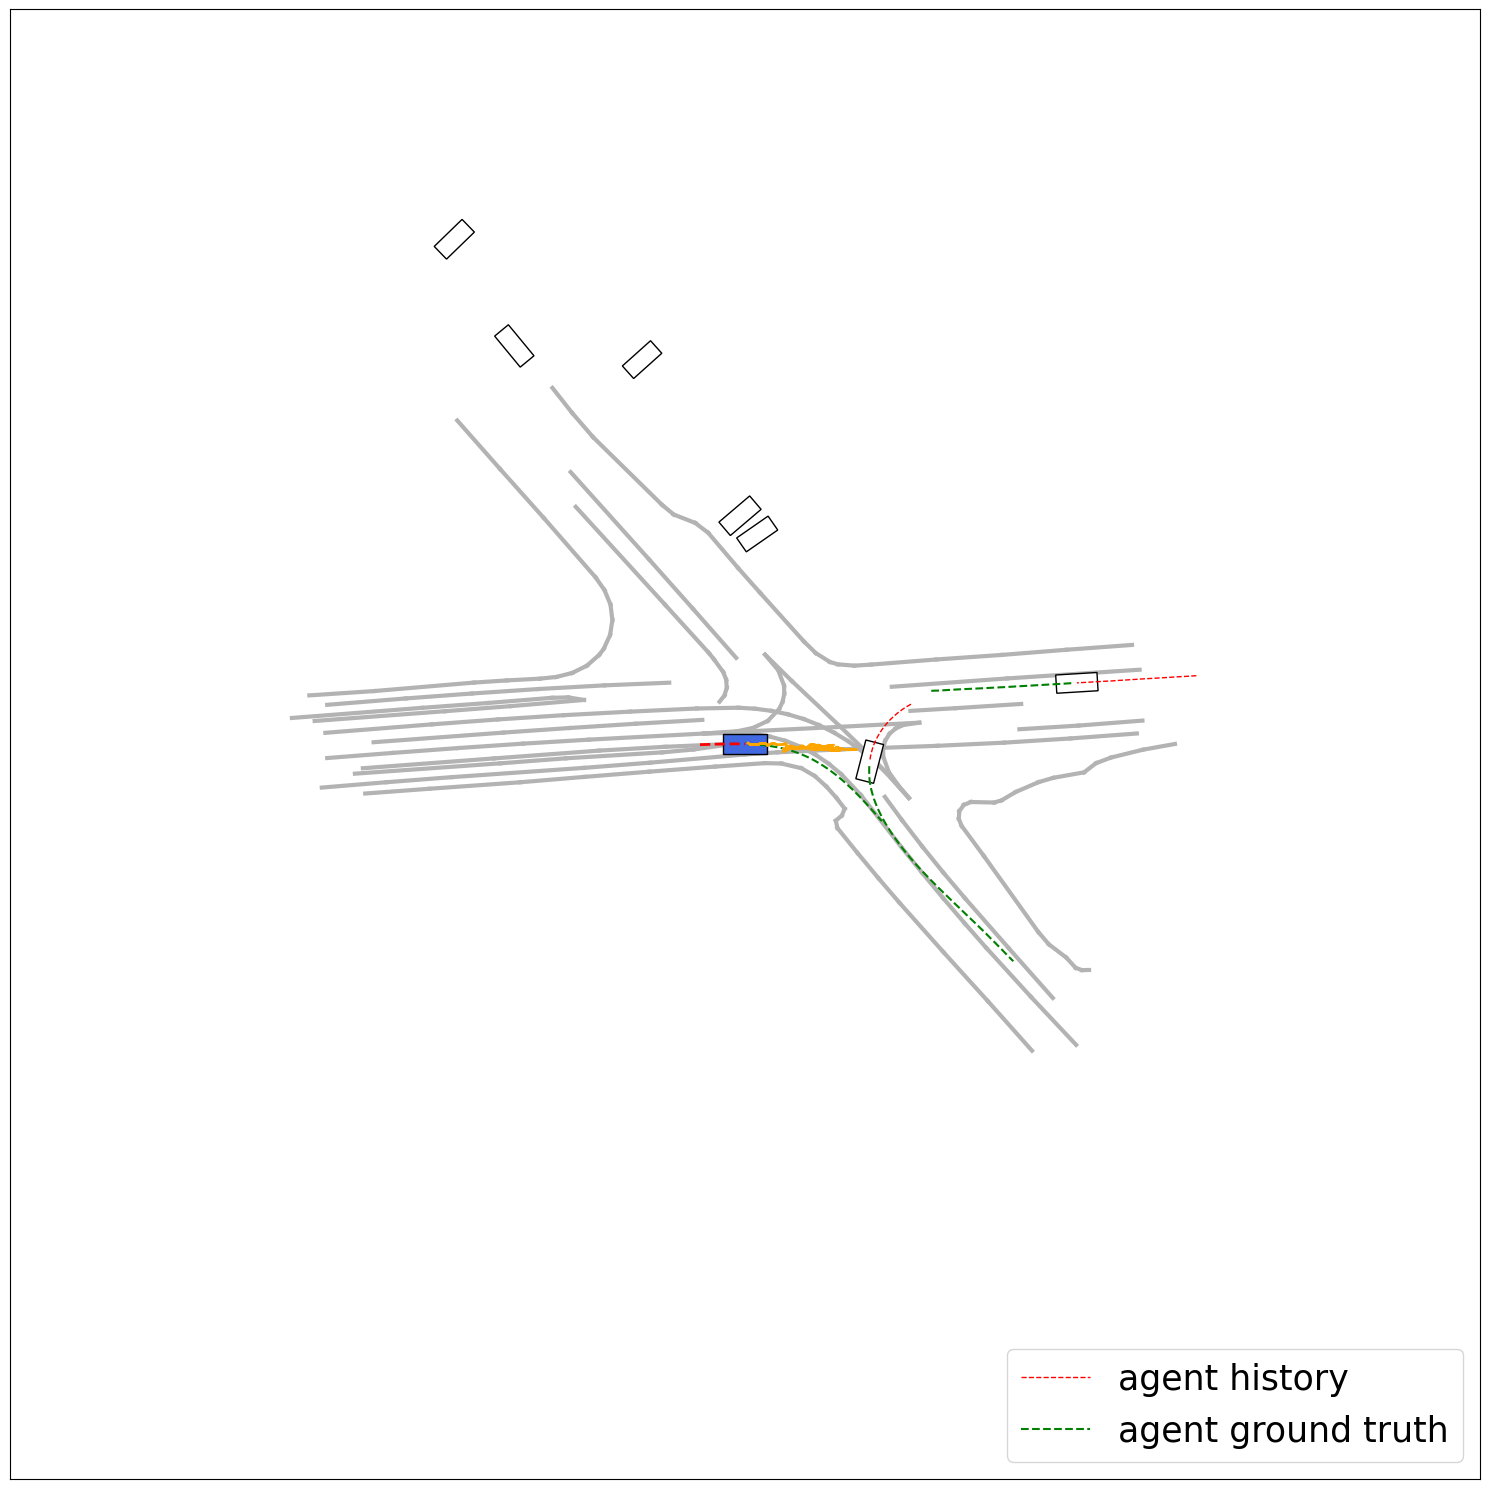

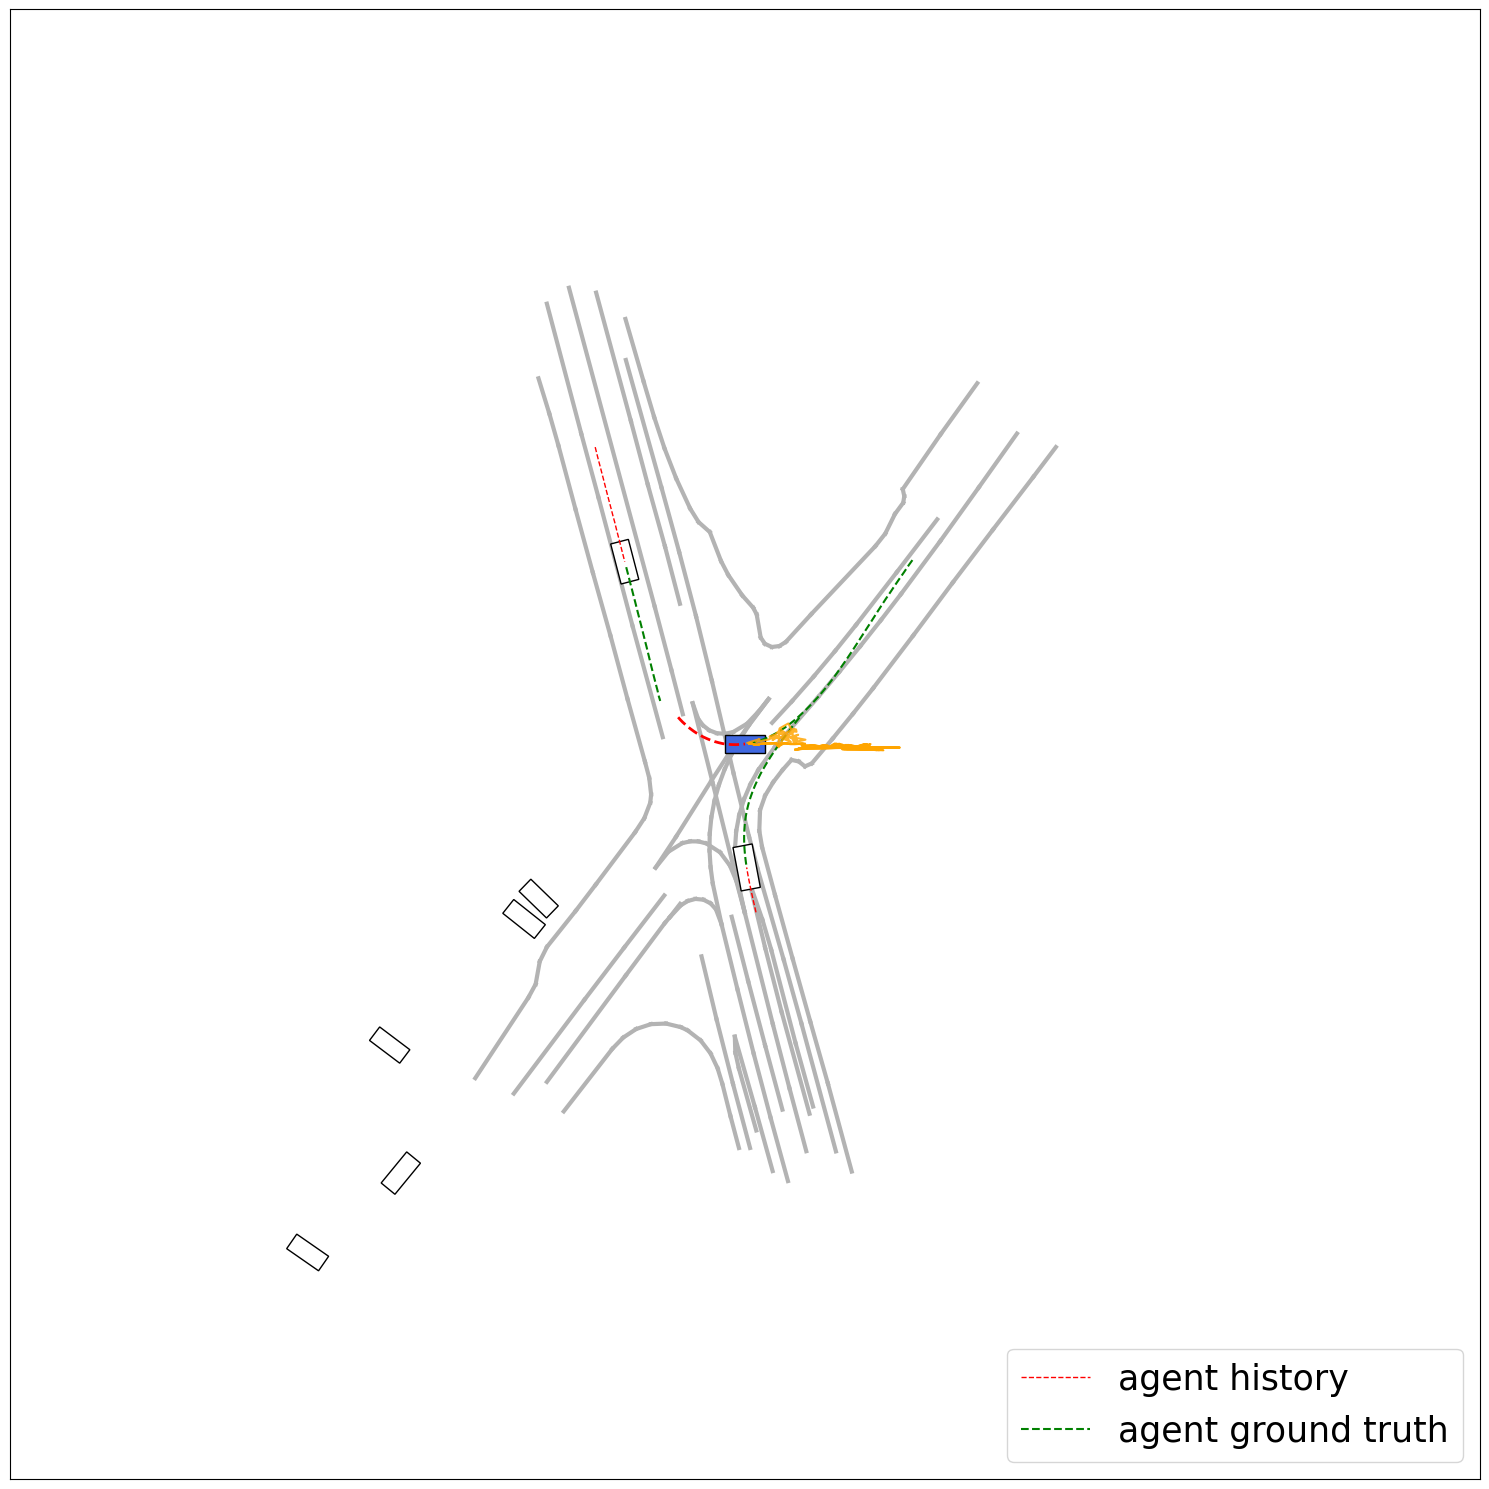

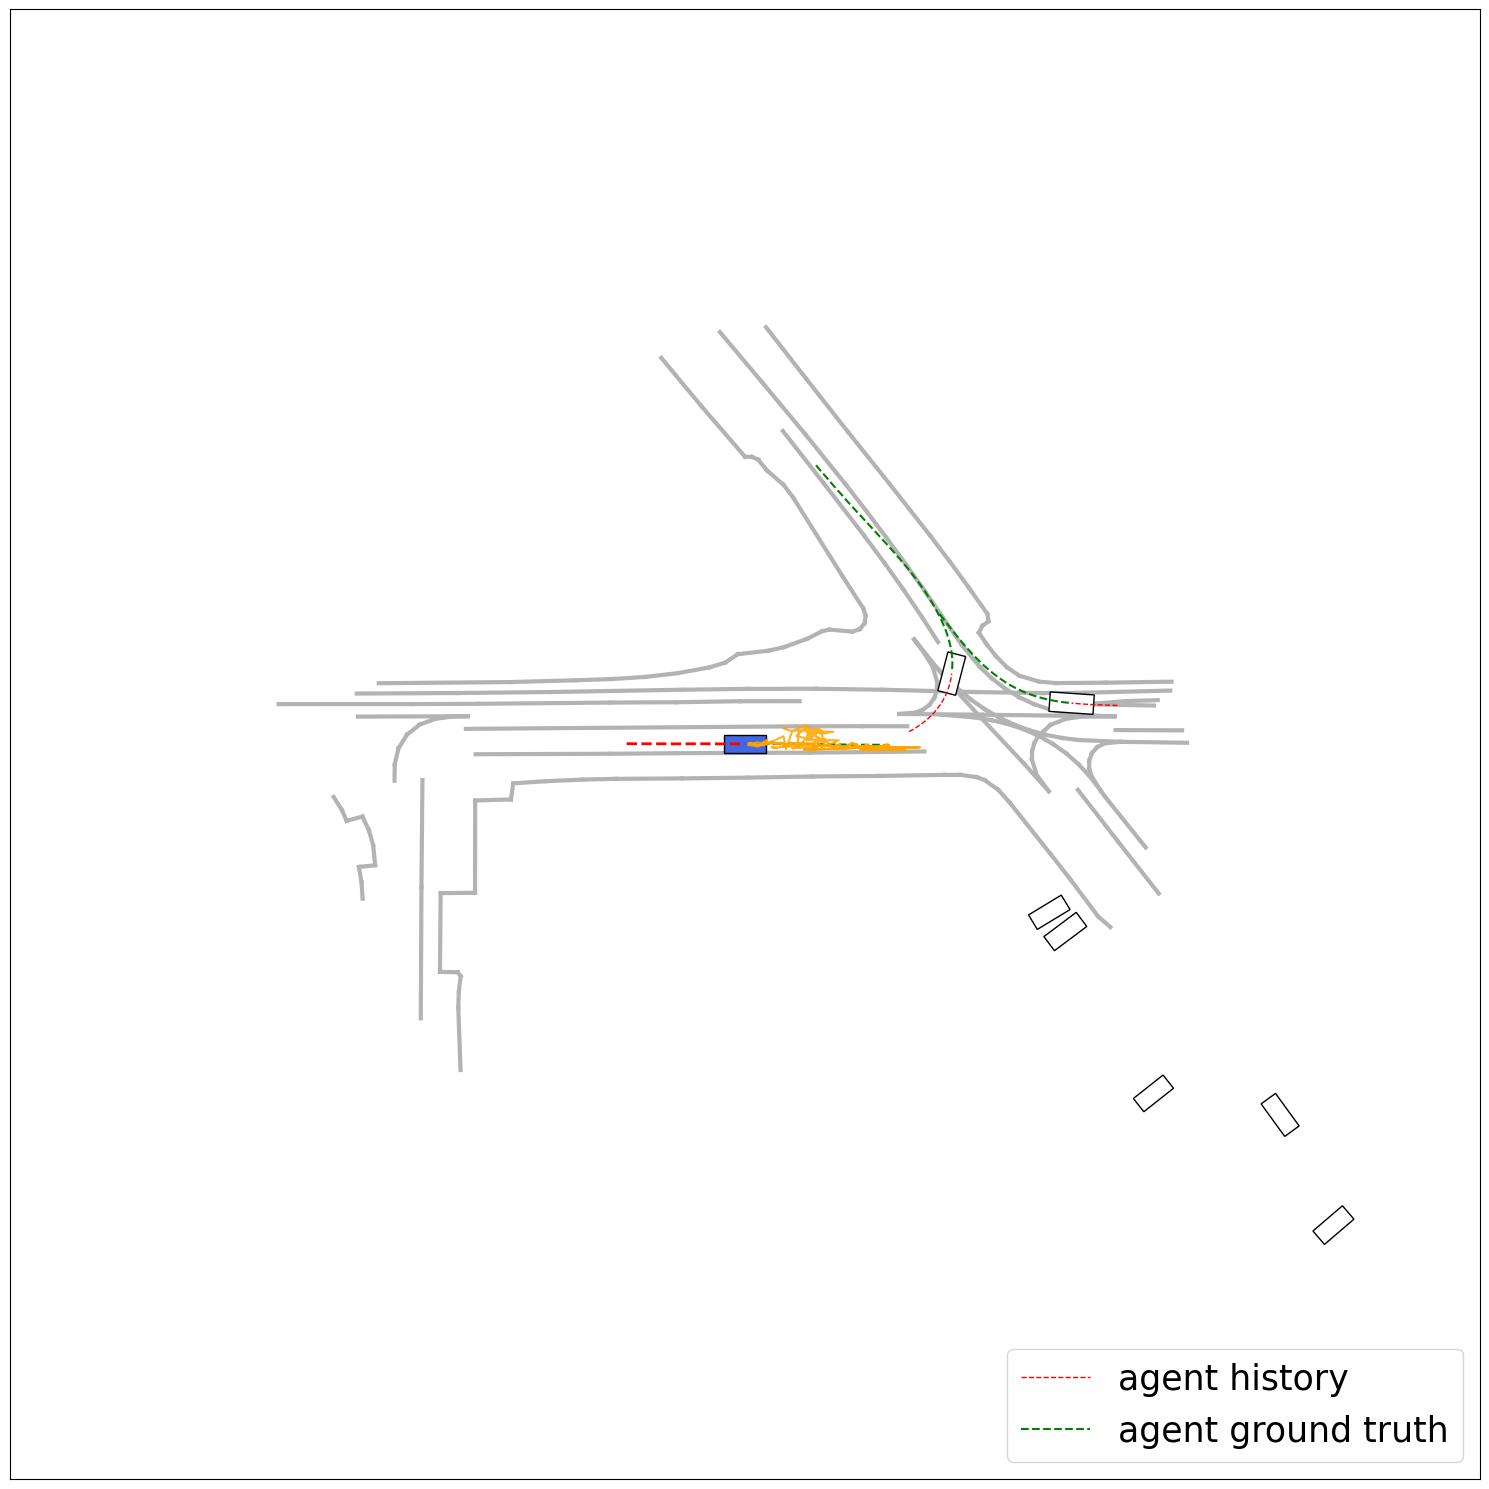

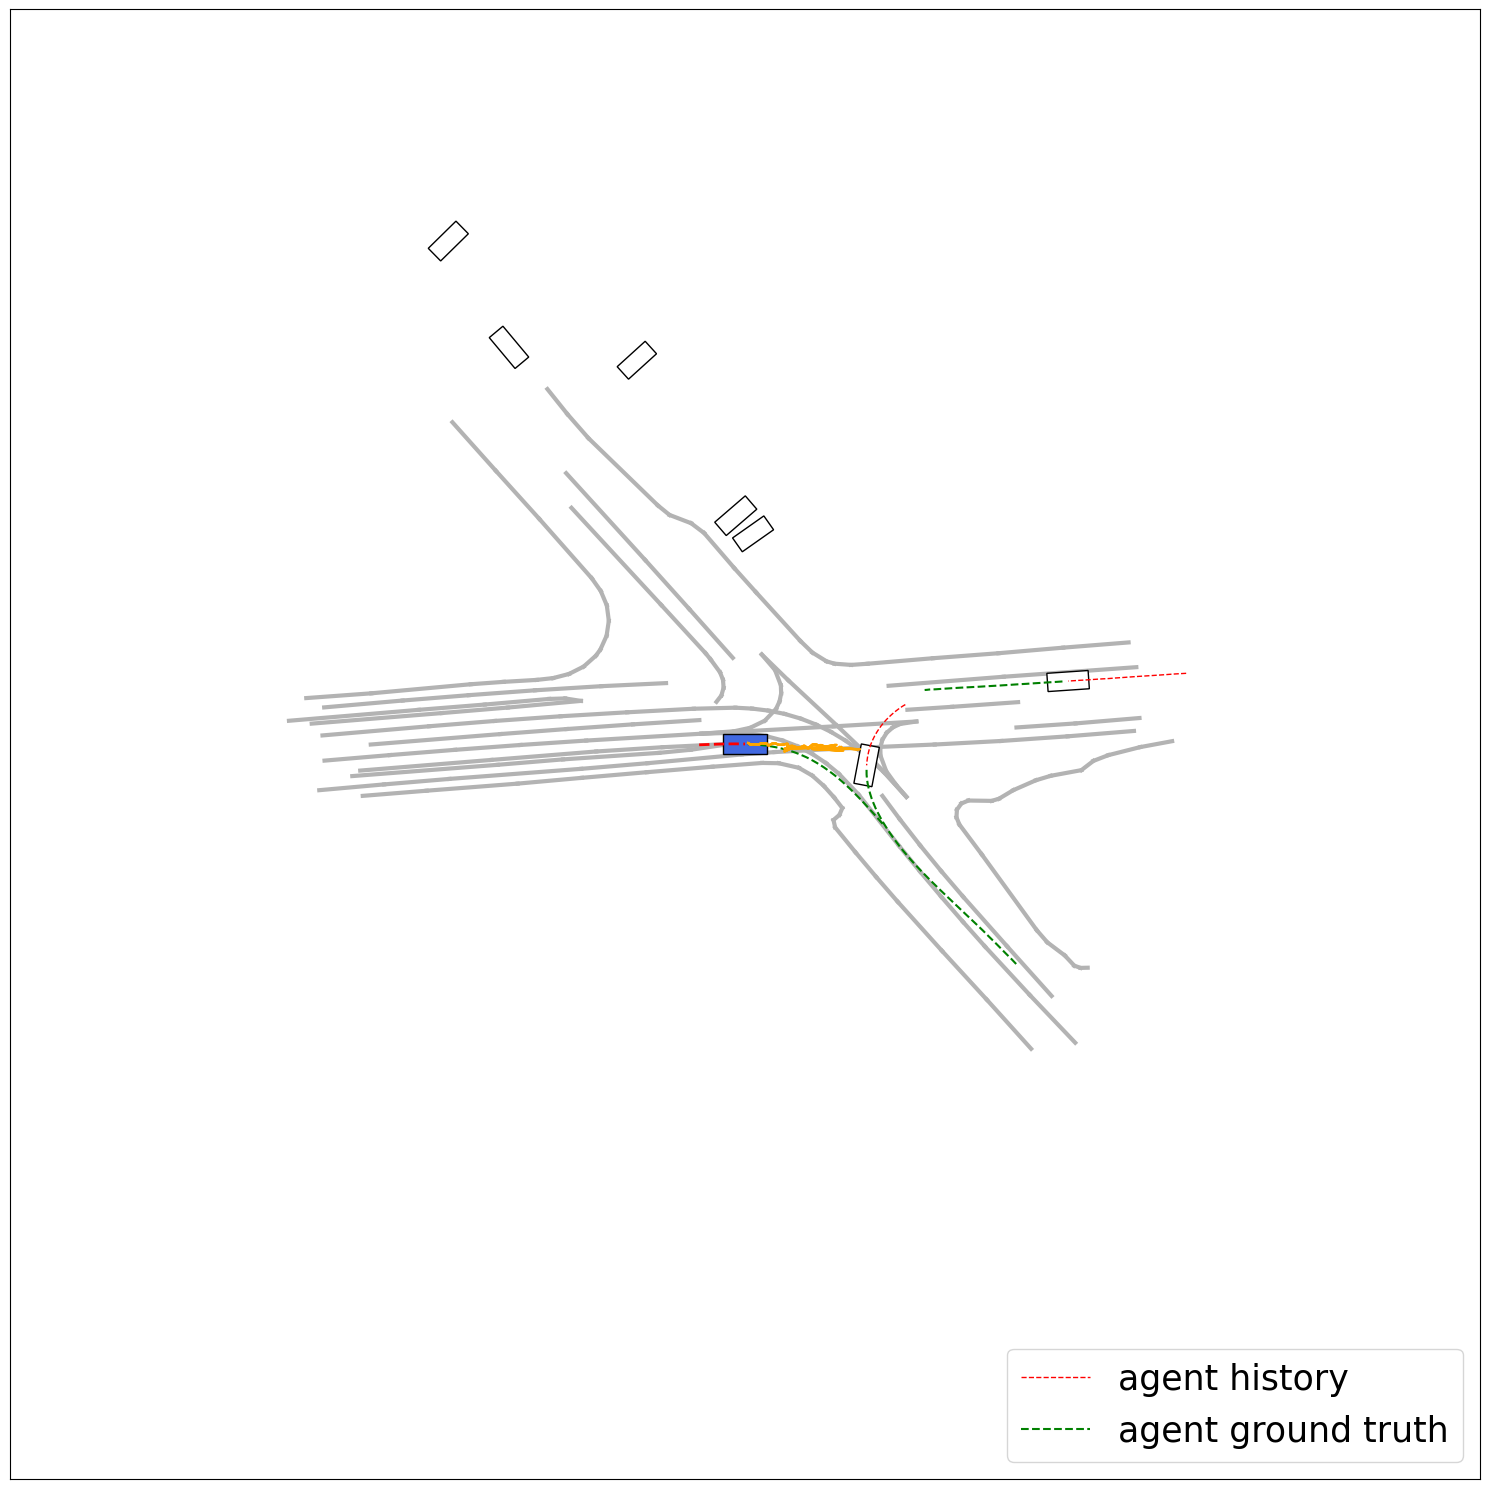

100%|██████████| 500/500 [00:53<00:00,  9.28it/s]
INFO:root:Epoch: 2, Last loss: 355.7945251464844
100%|█████████▉| 498/500 [00:52<00:00, 14.24it/s]

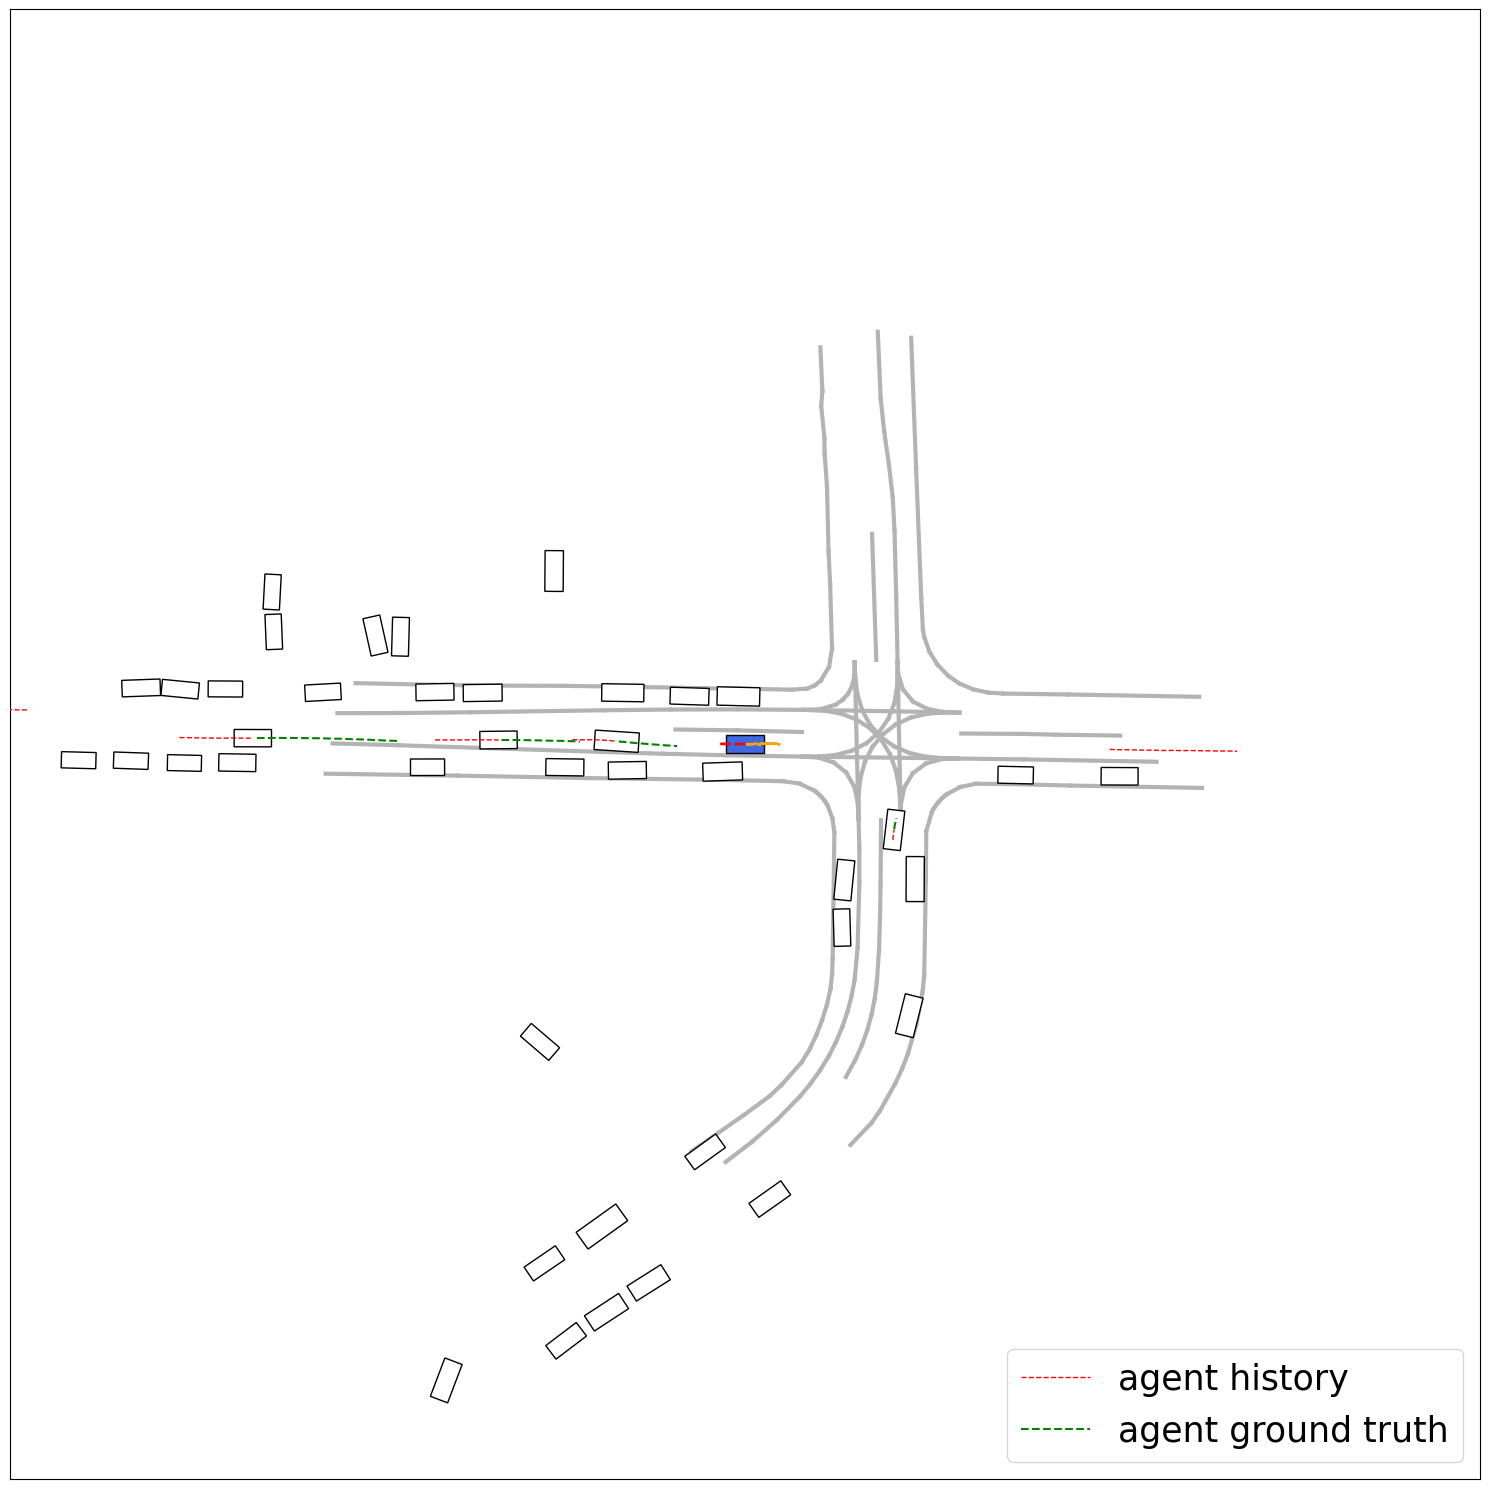

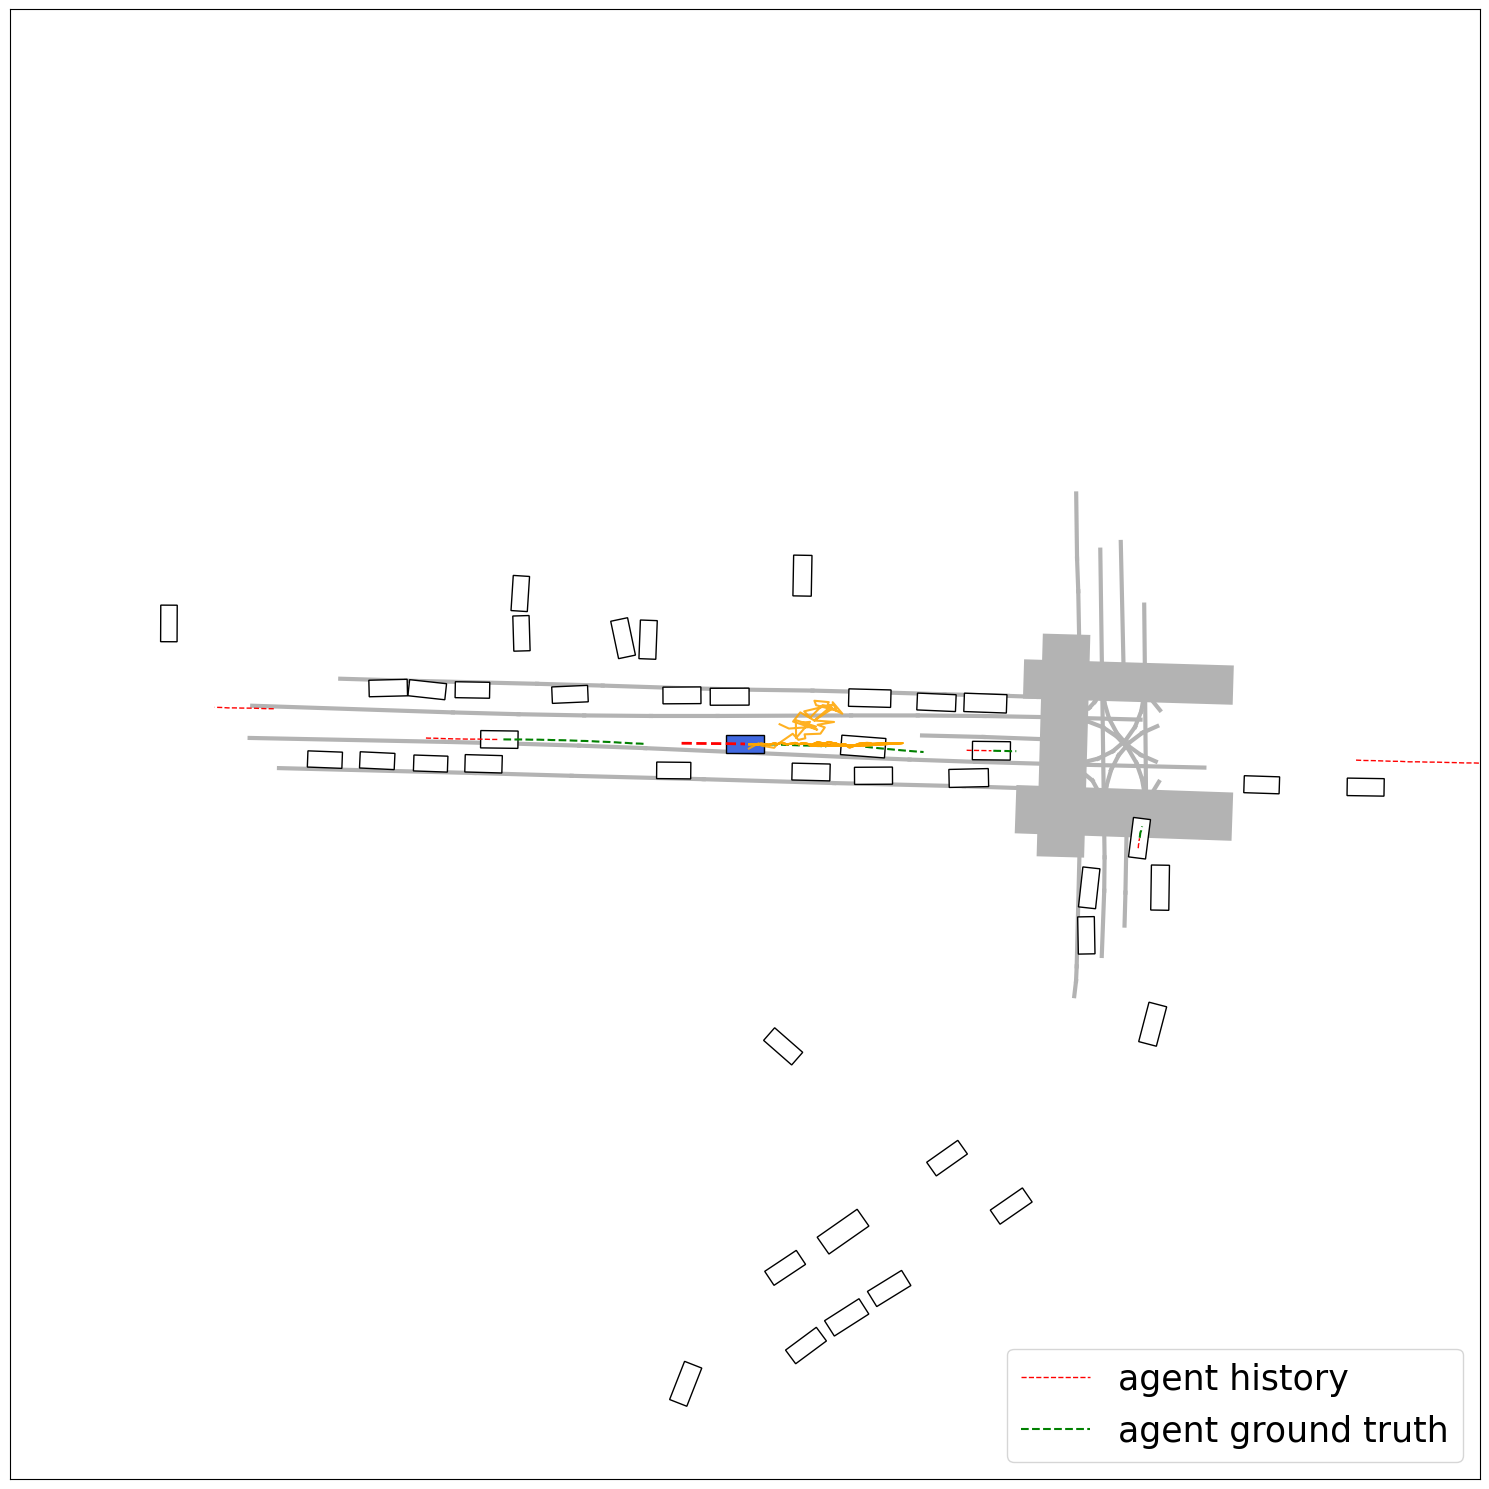

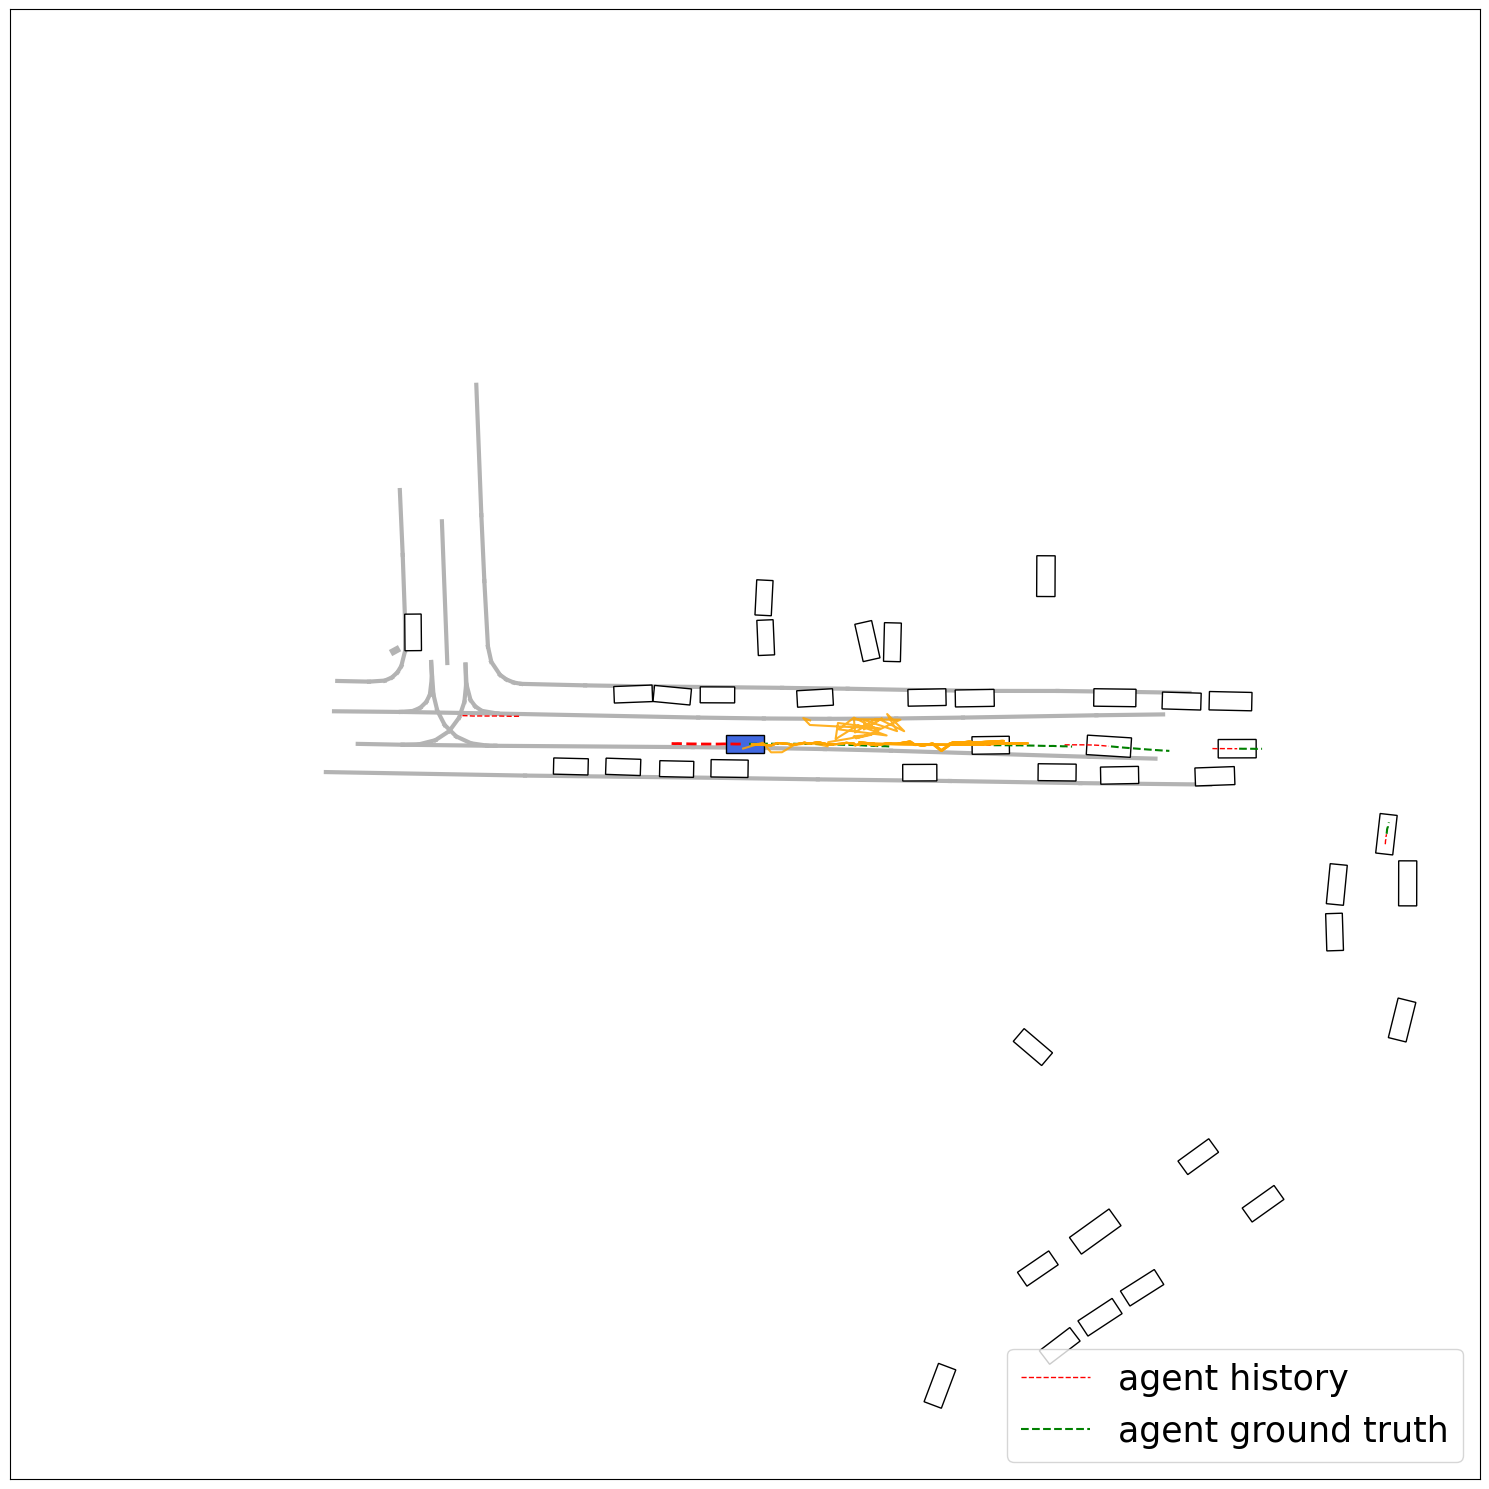

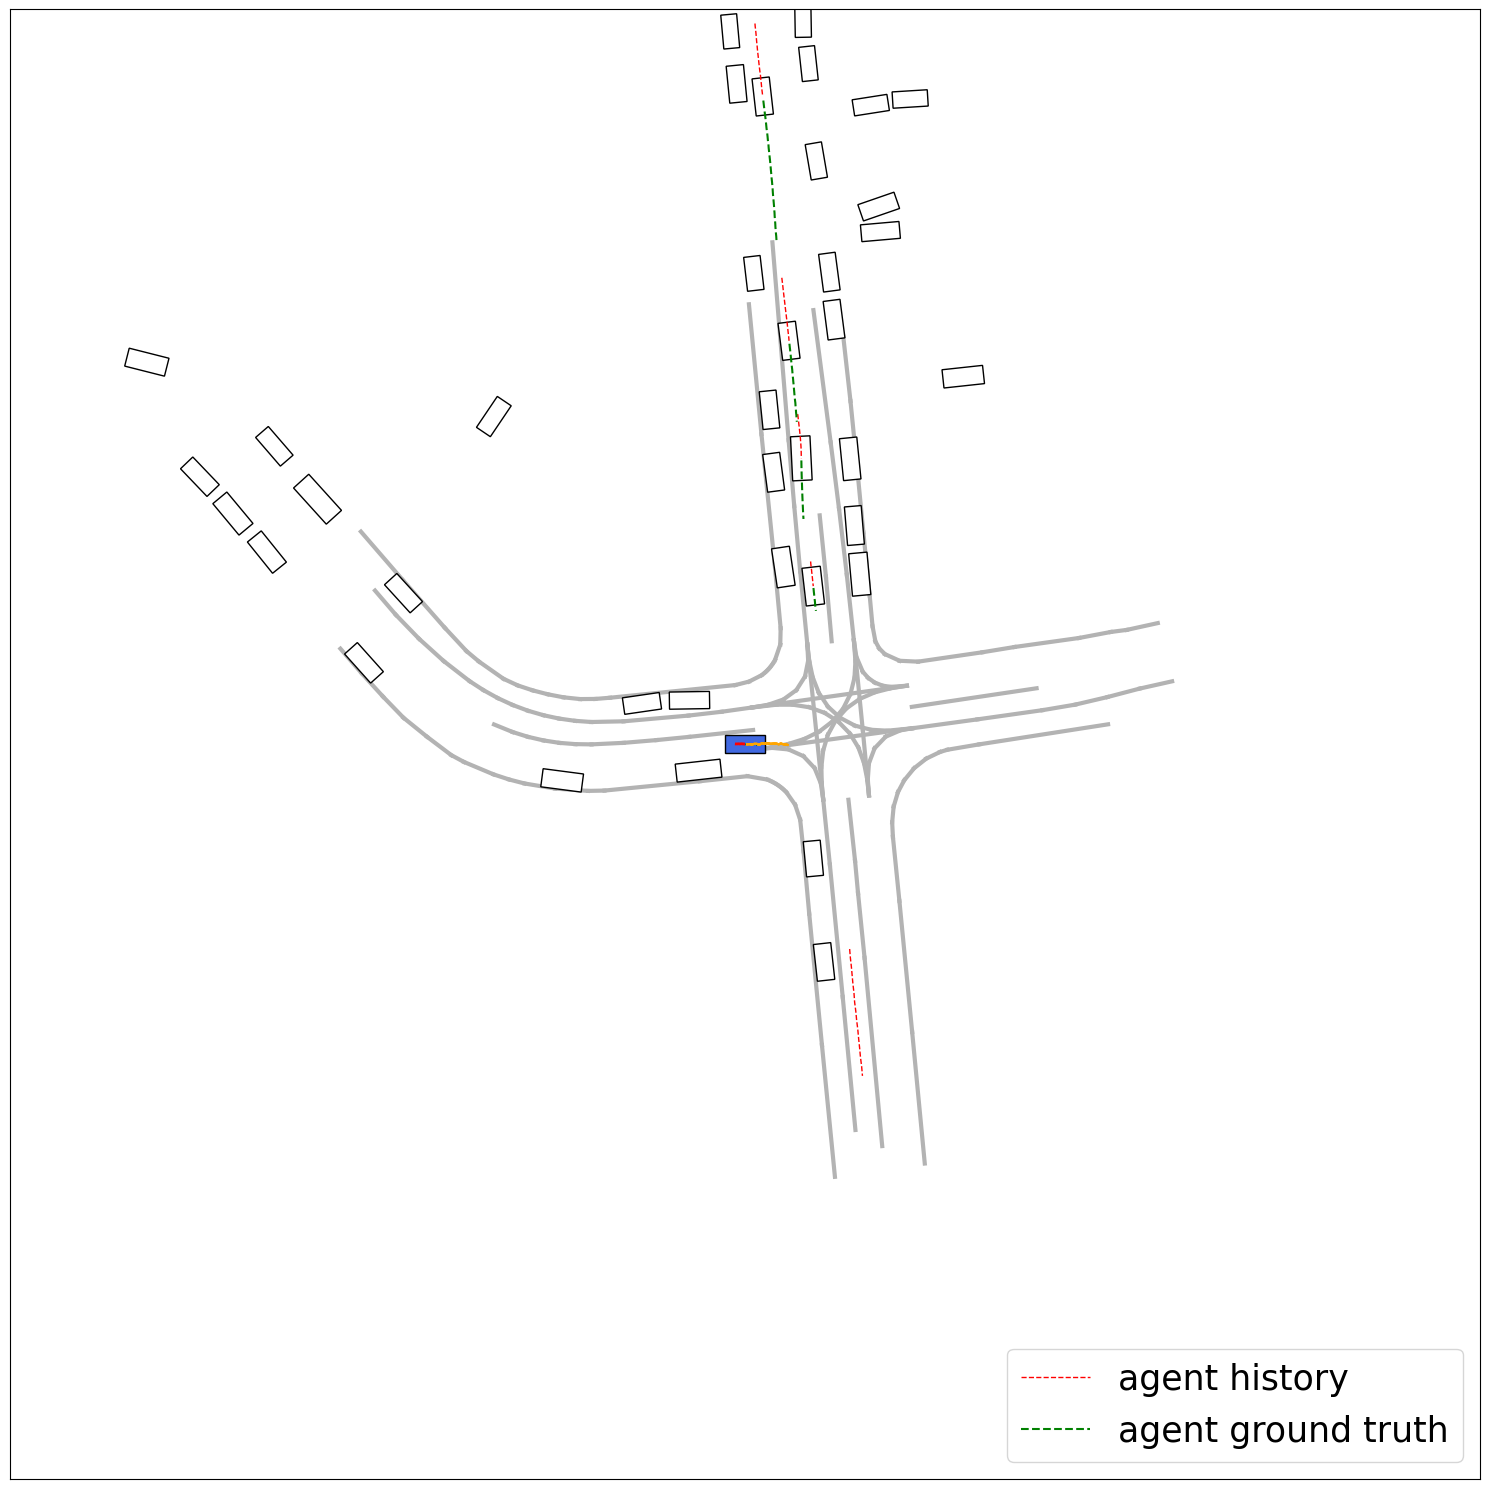

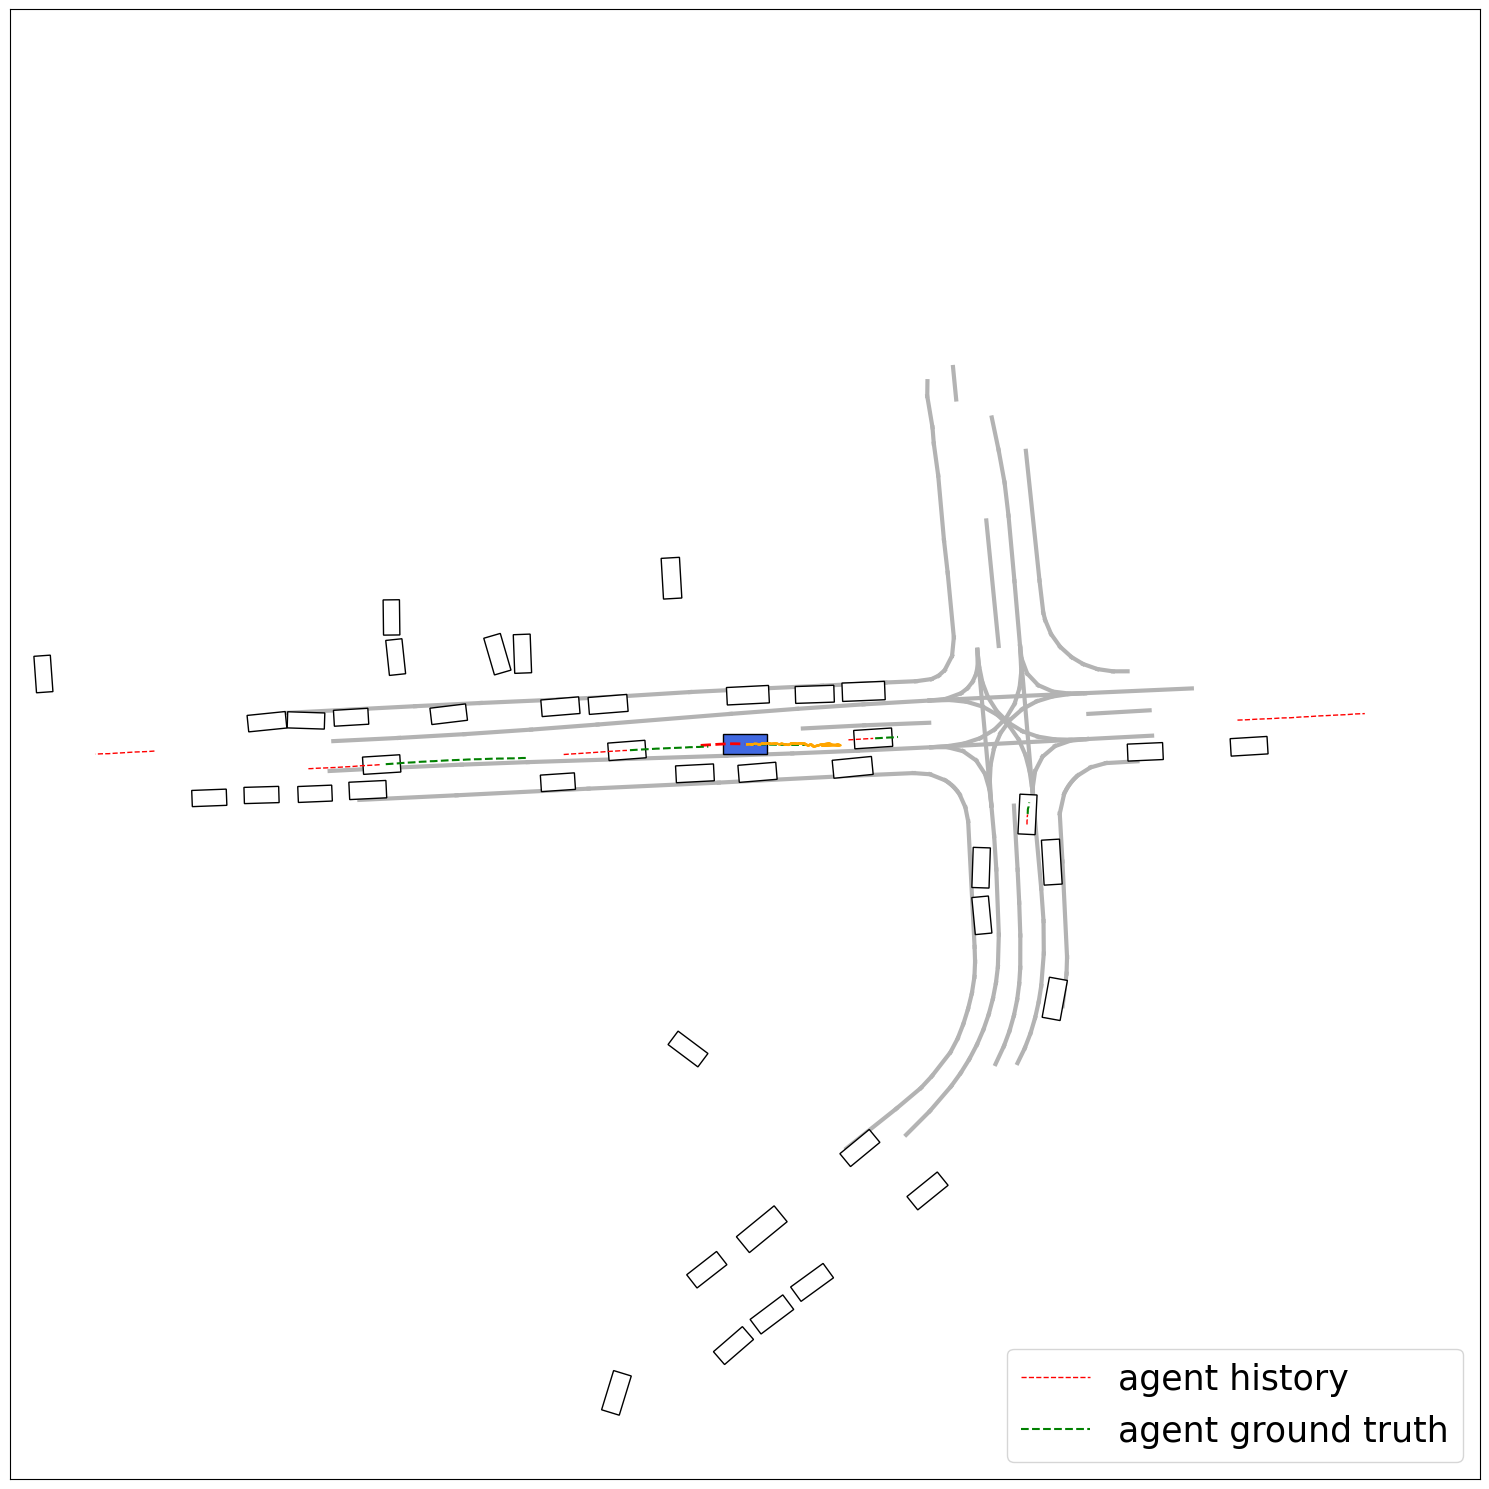

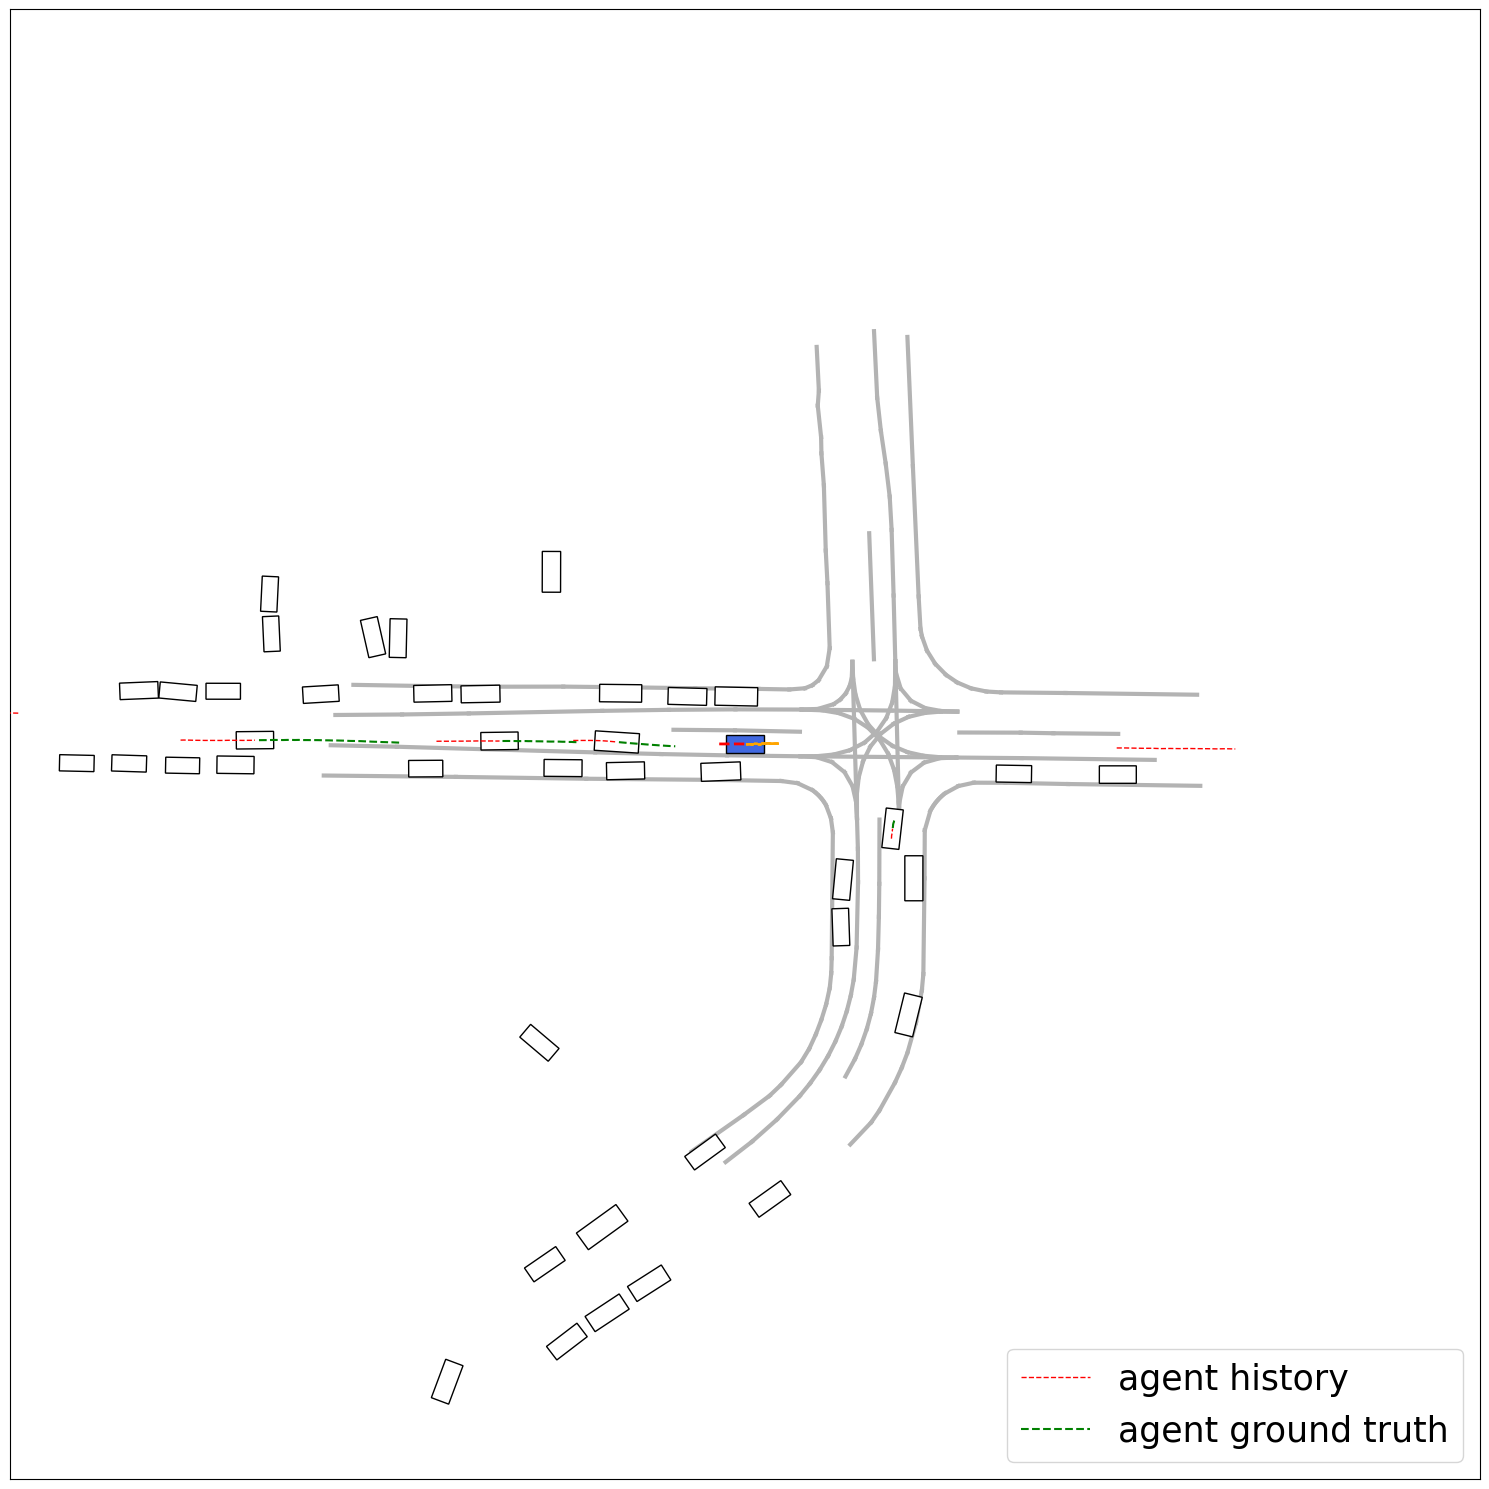

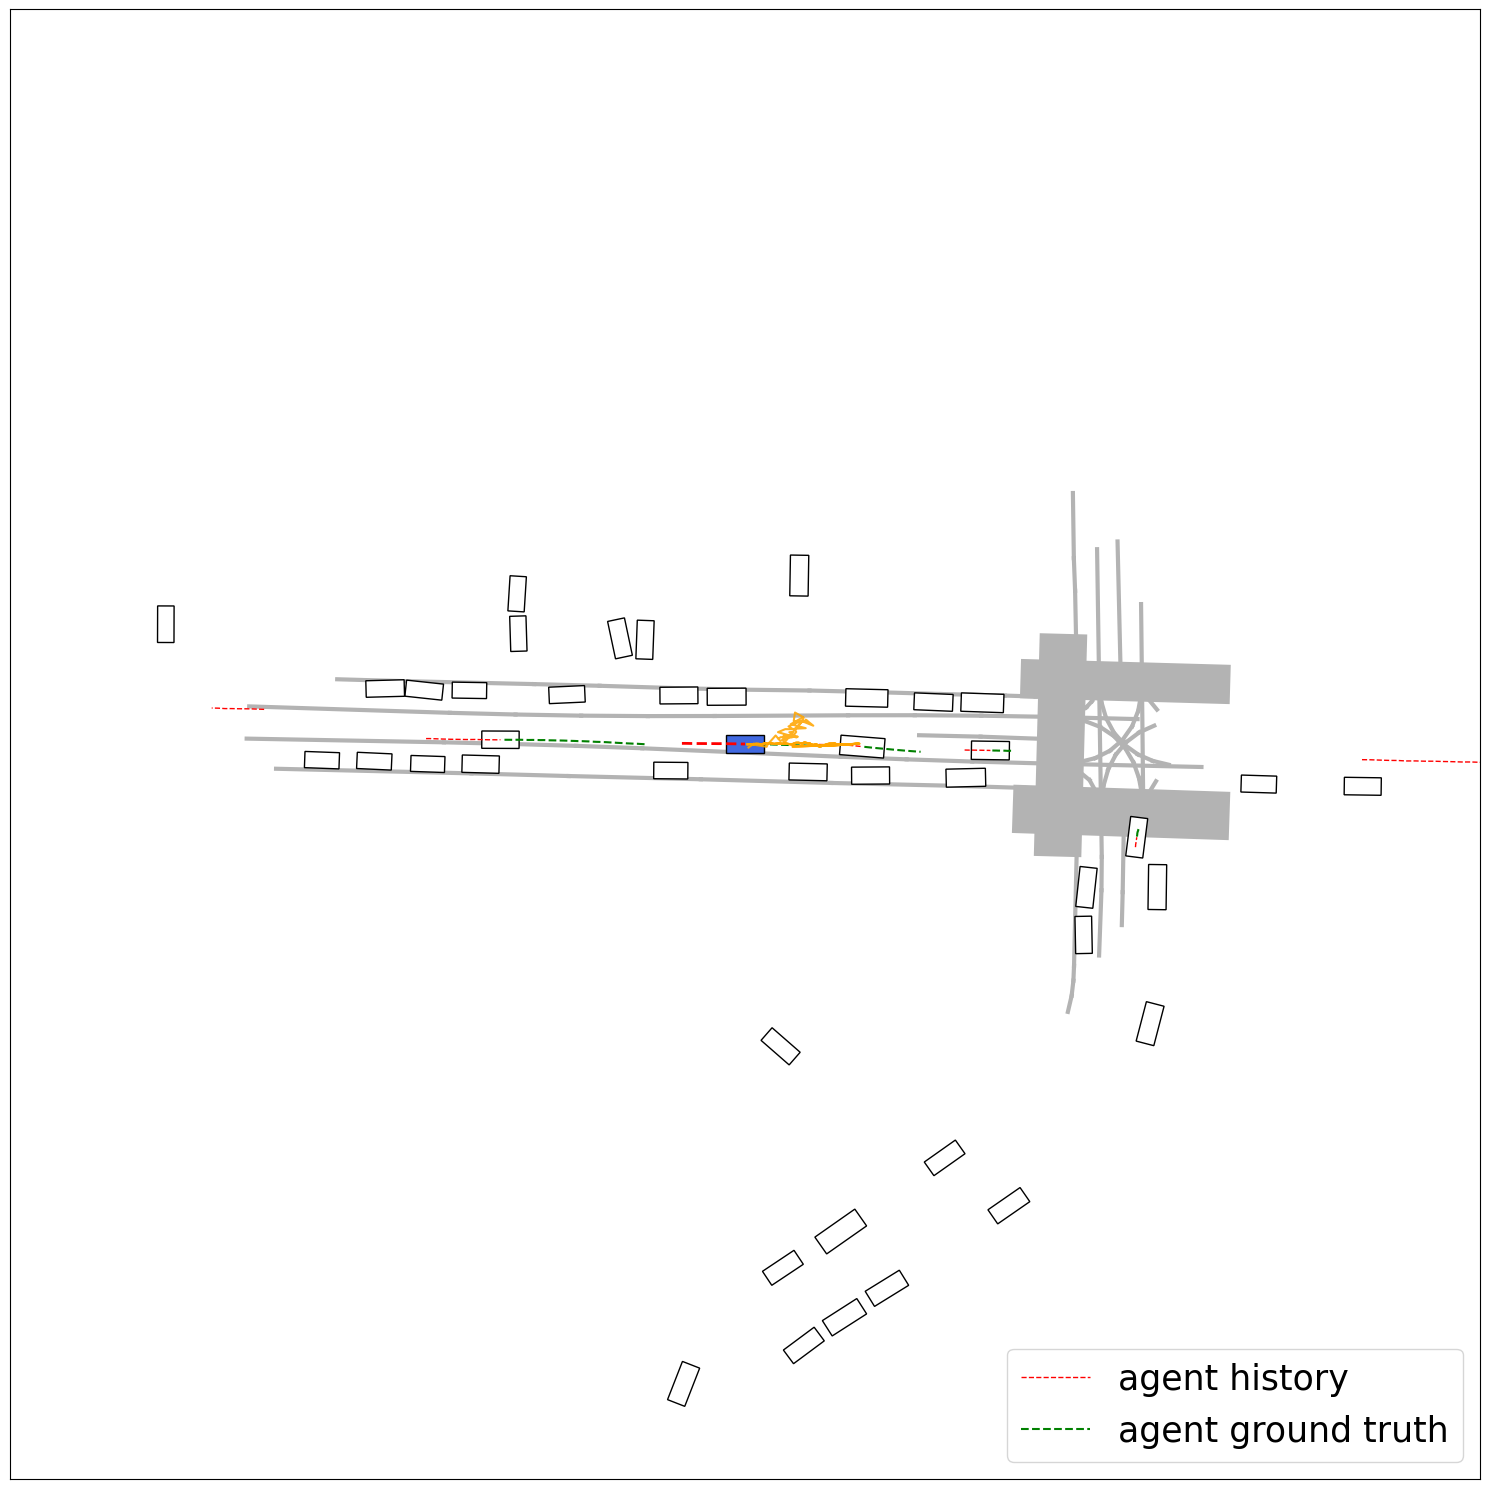

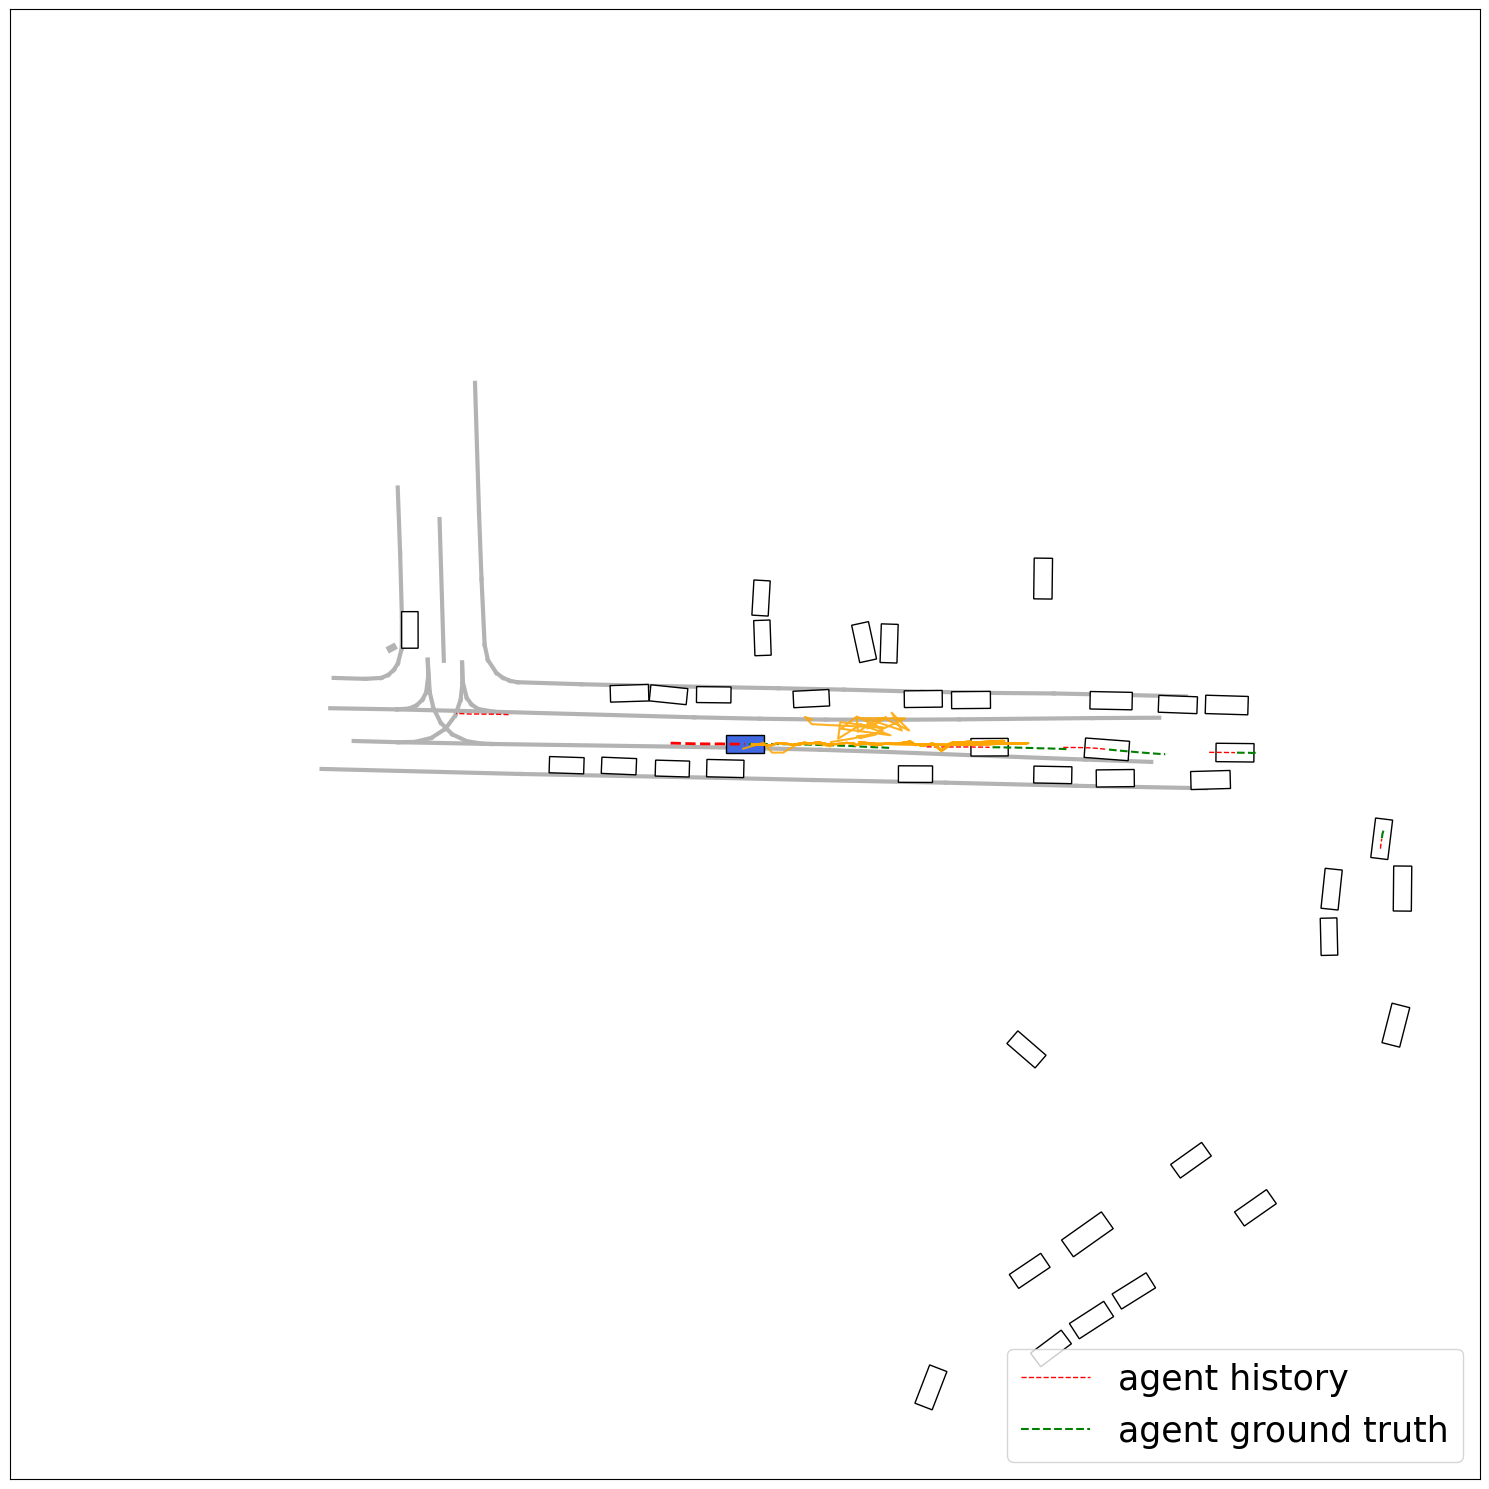

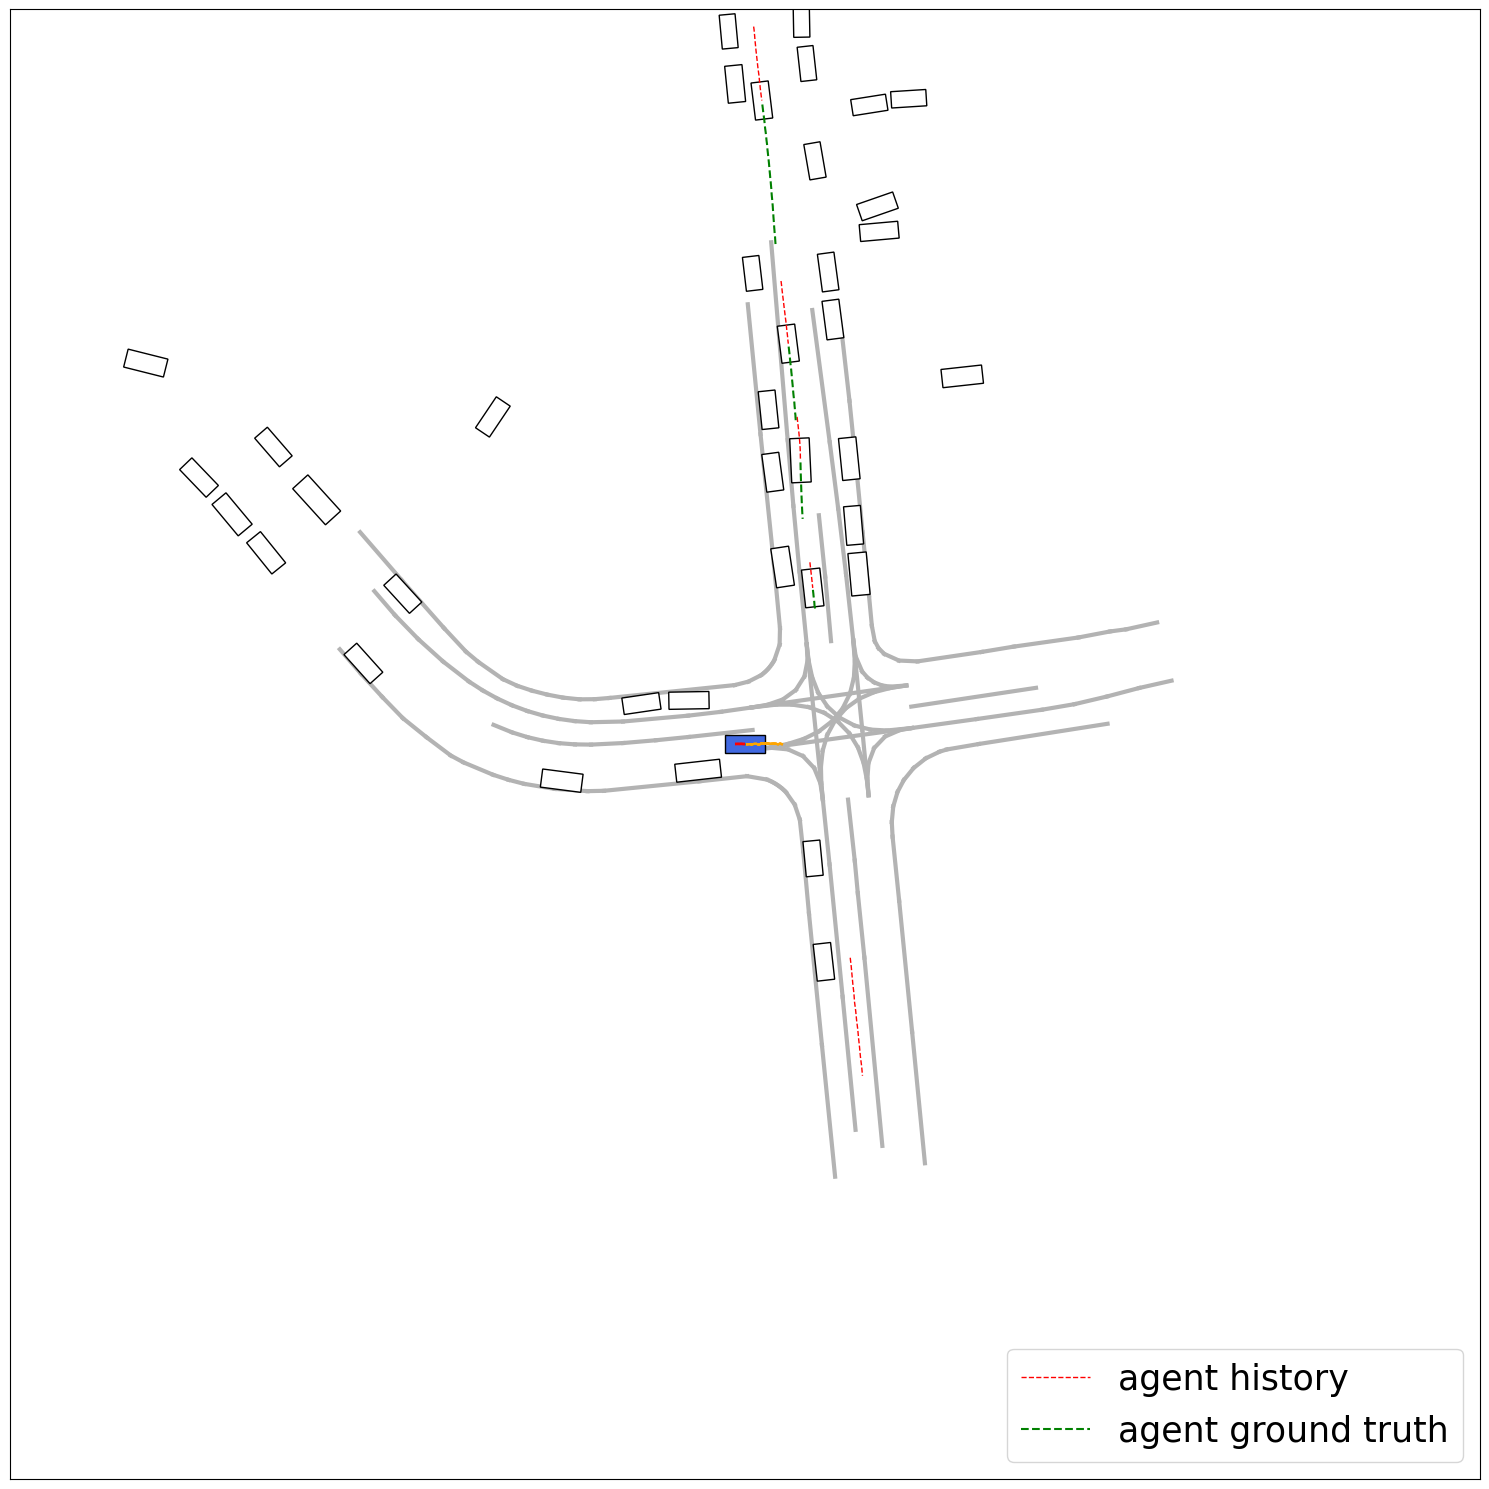

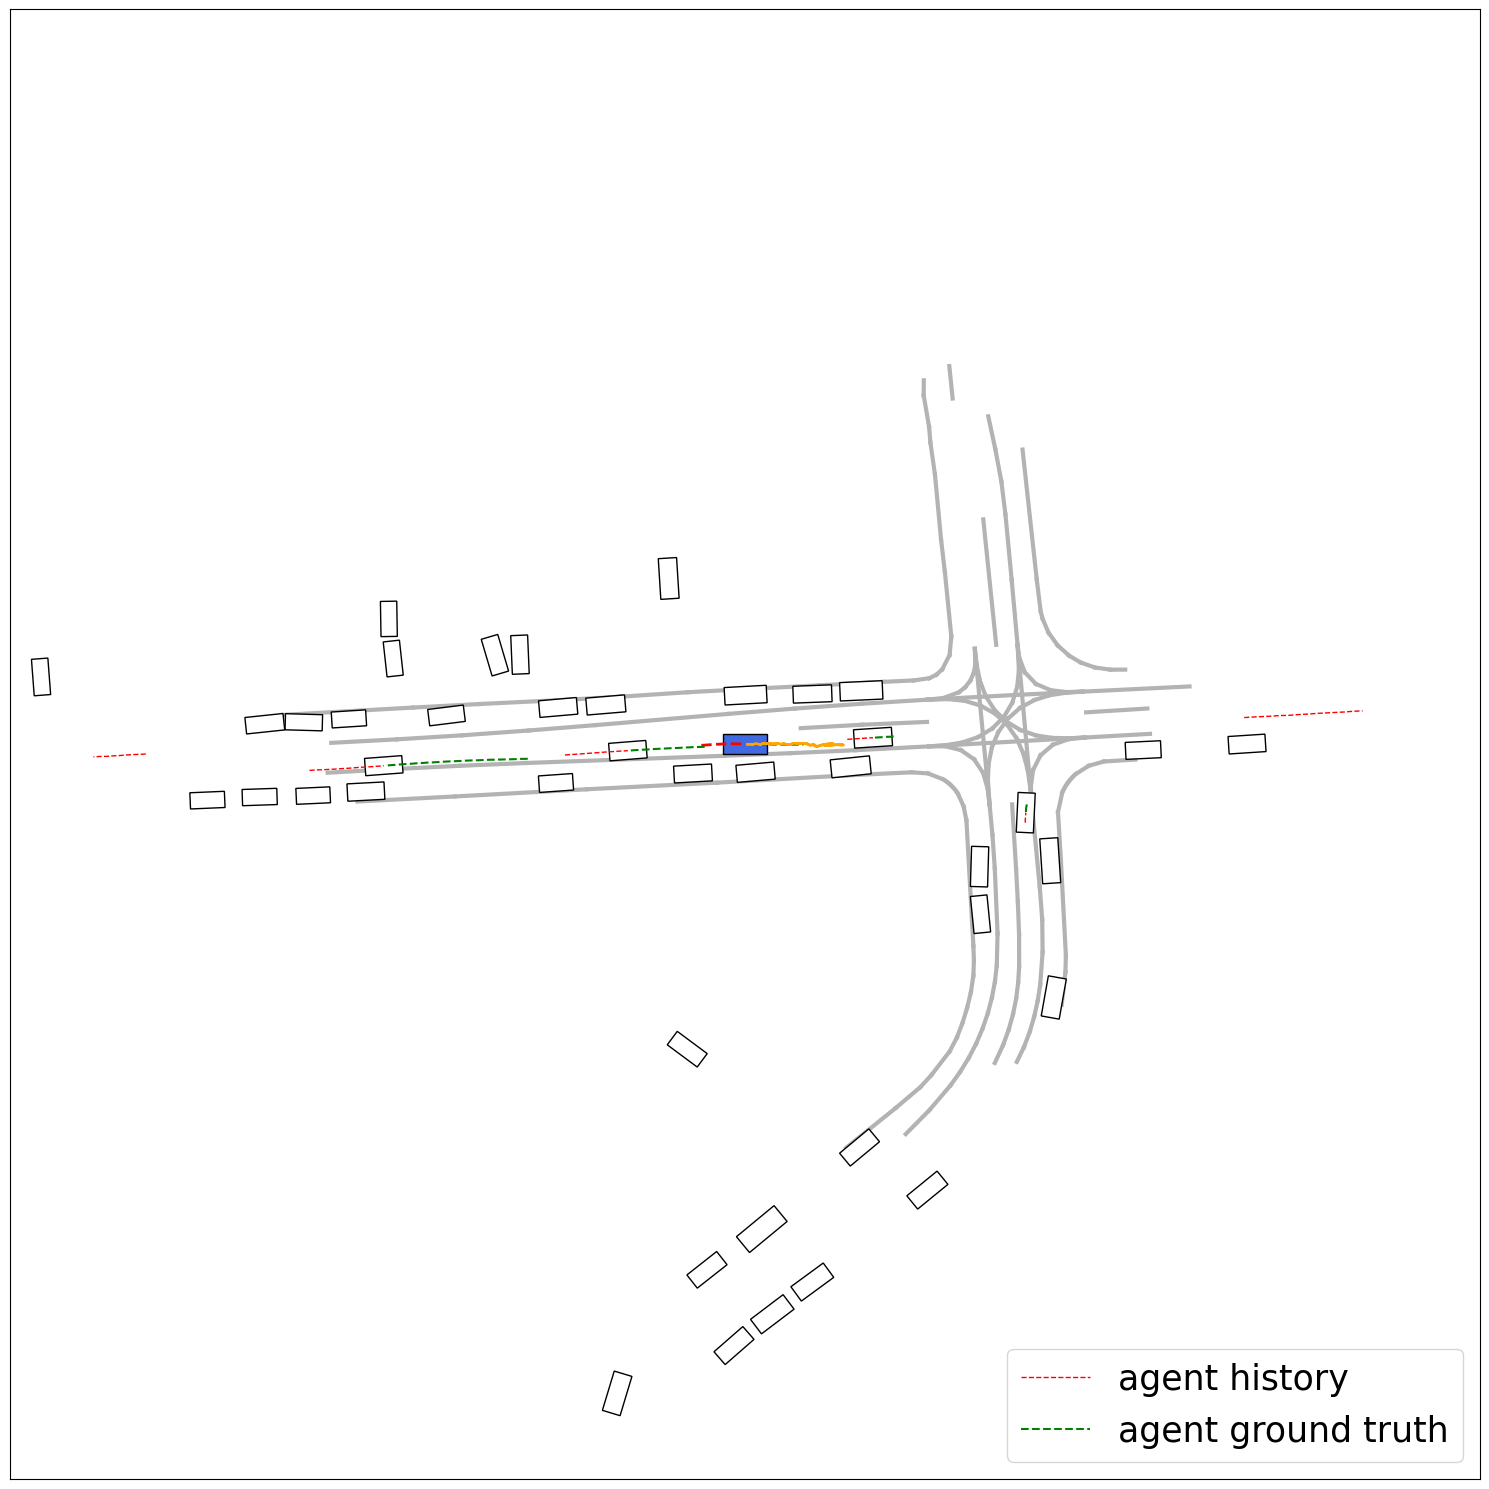

100%|██████████| 500/500 [00:55<00:00,  9.00it/s]
INFO:root:Epoch: 3, Last loss: 74.9793701171875
100%|█████████▉| 499/500 [00:52<00:00,  5.48it/s]

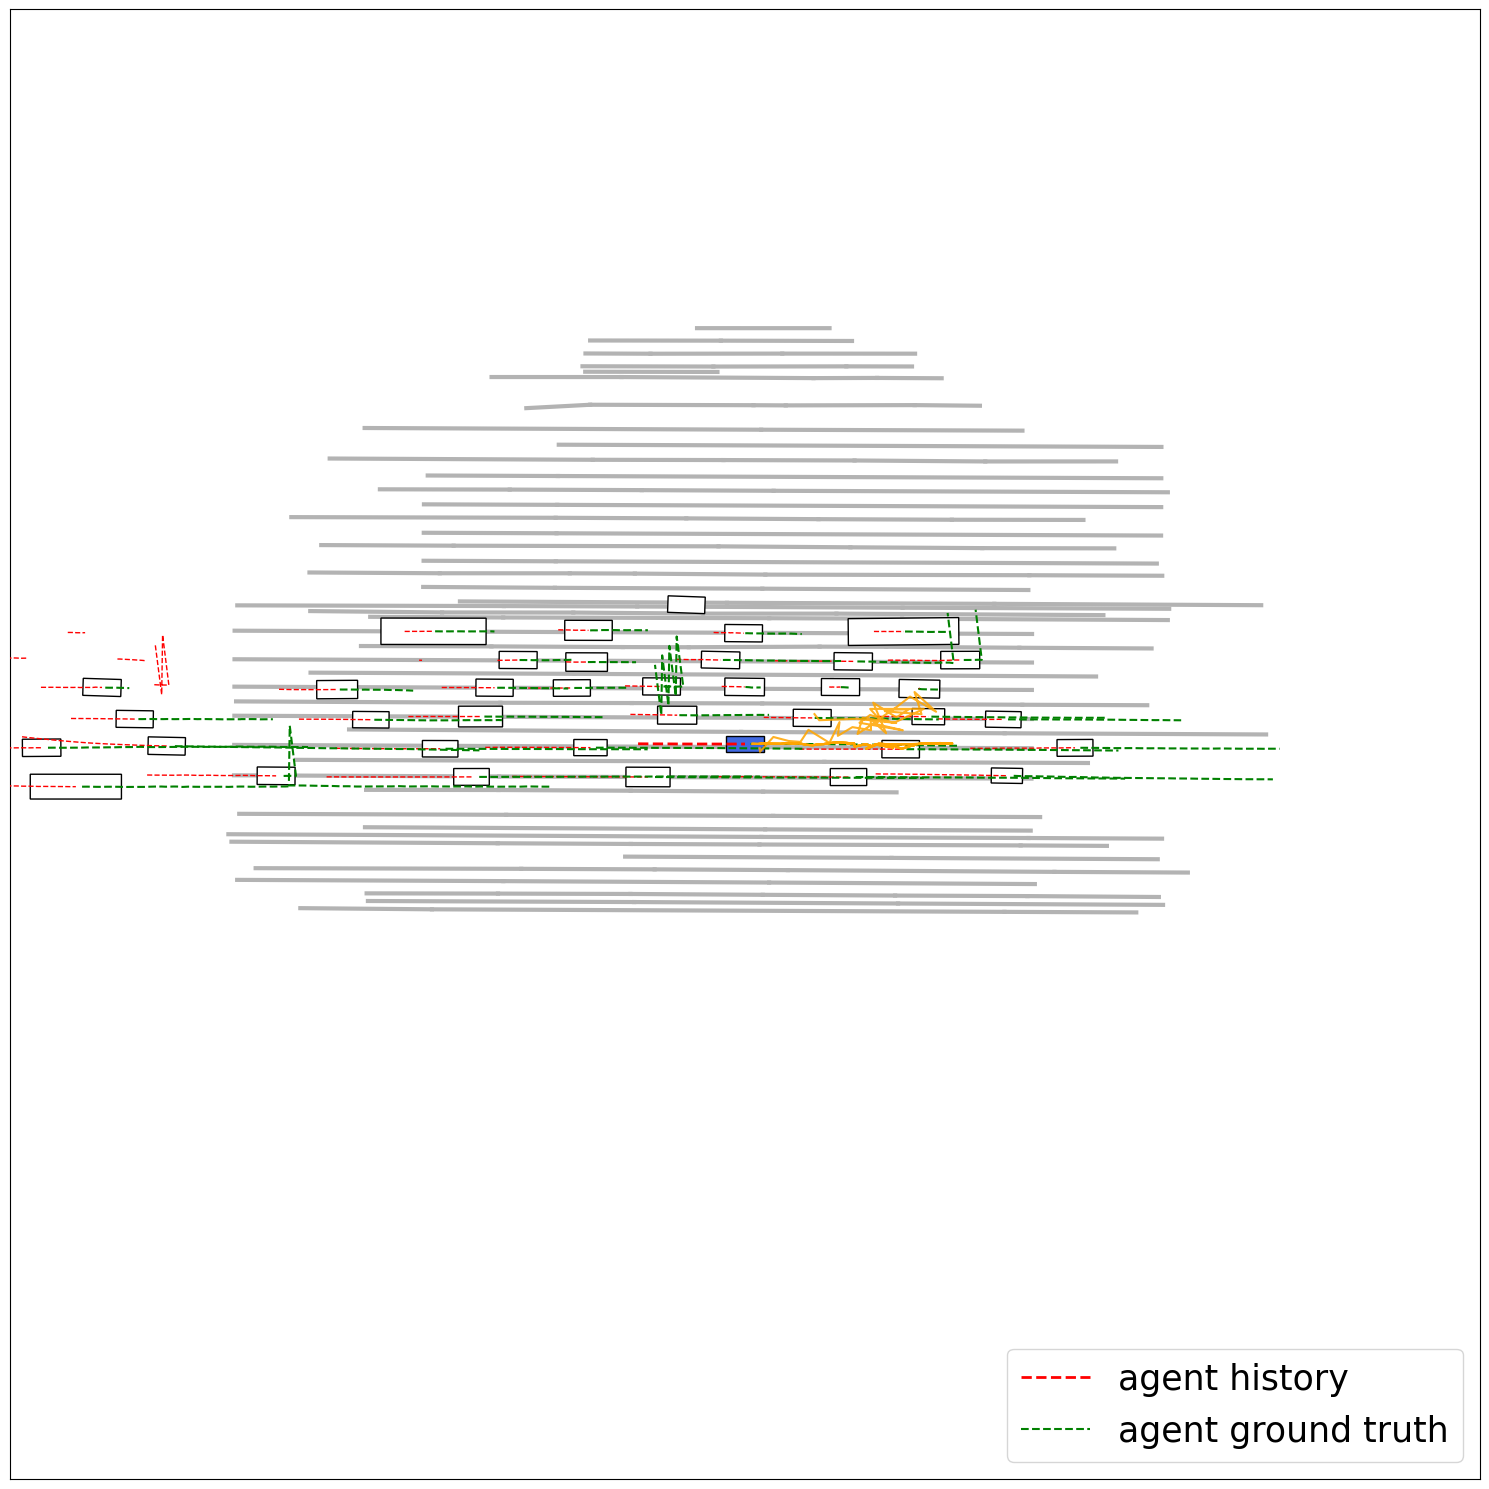

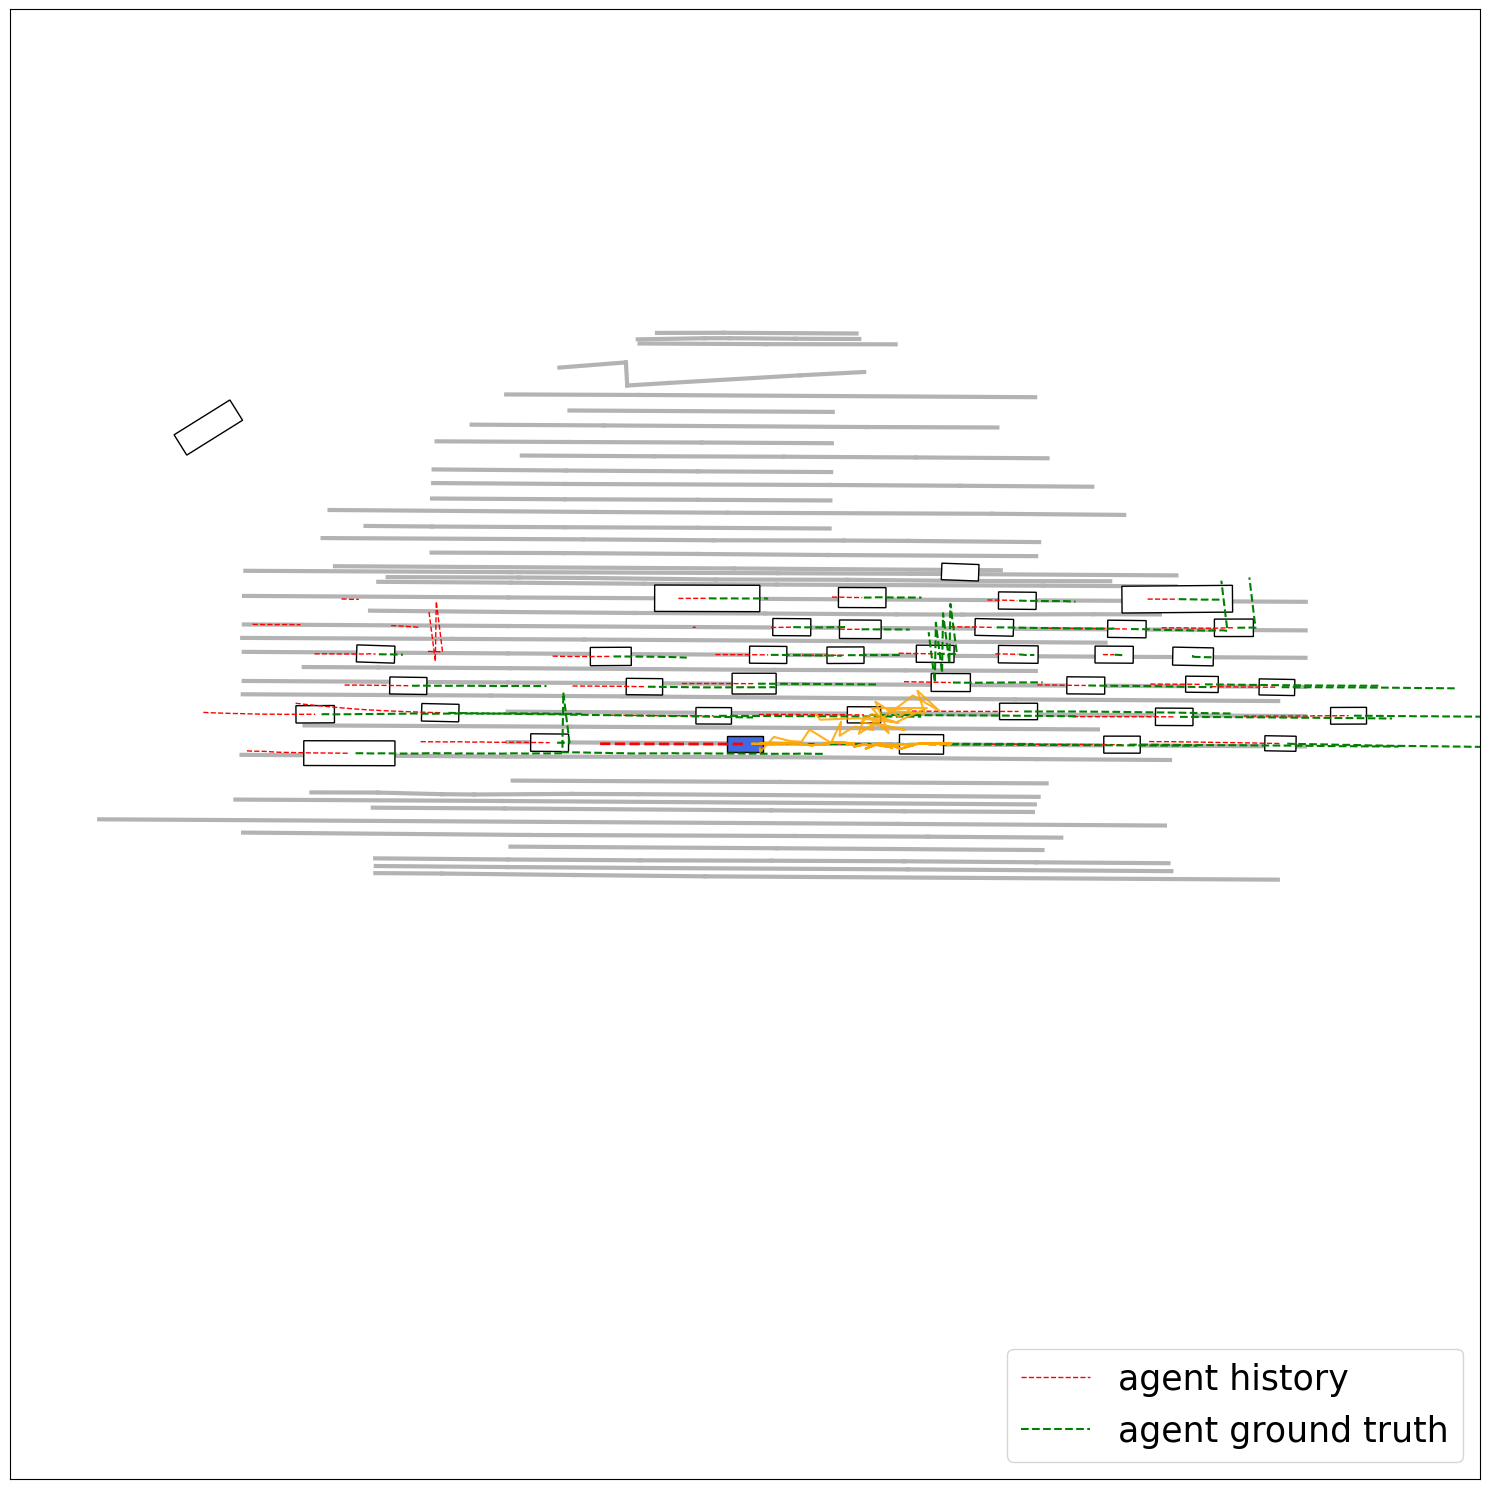

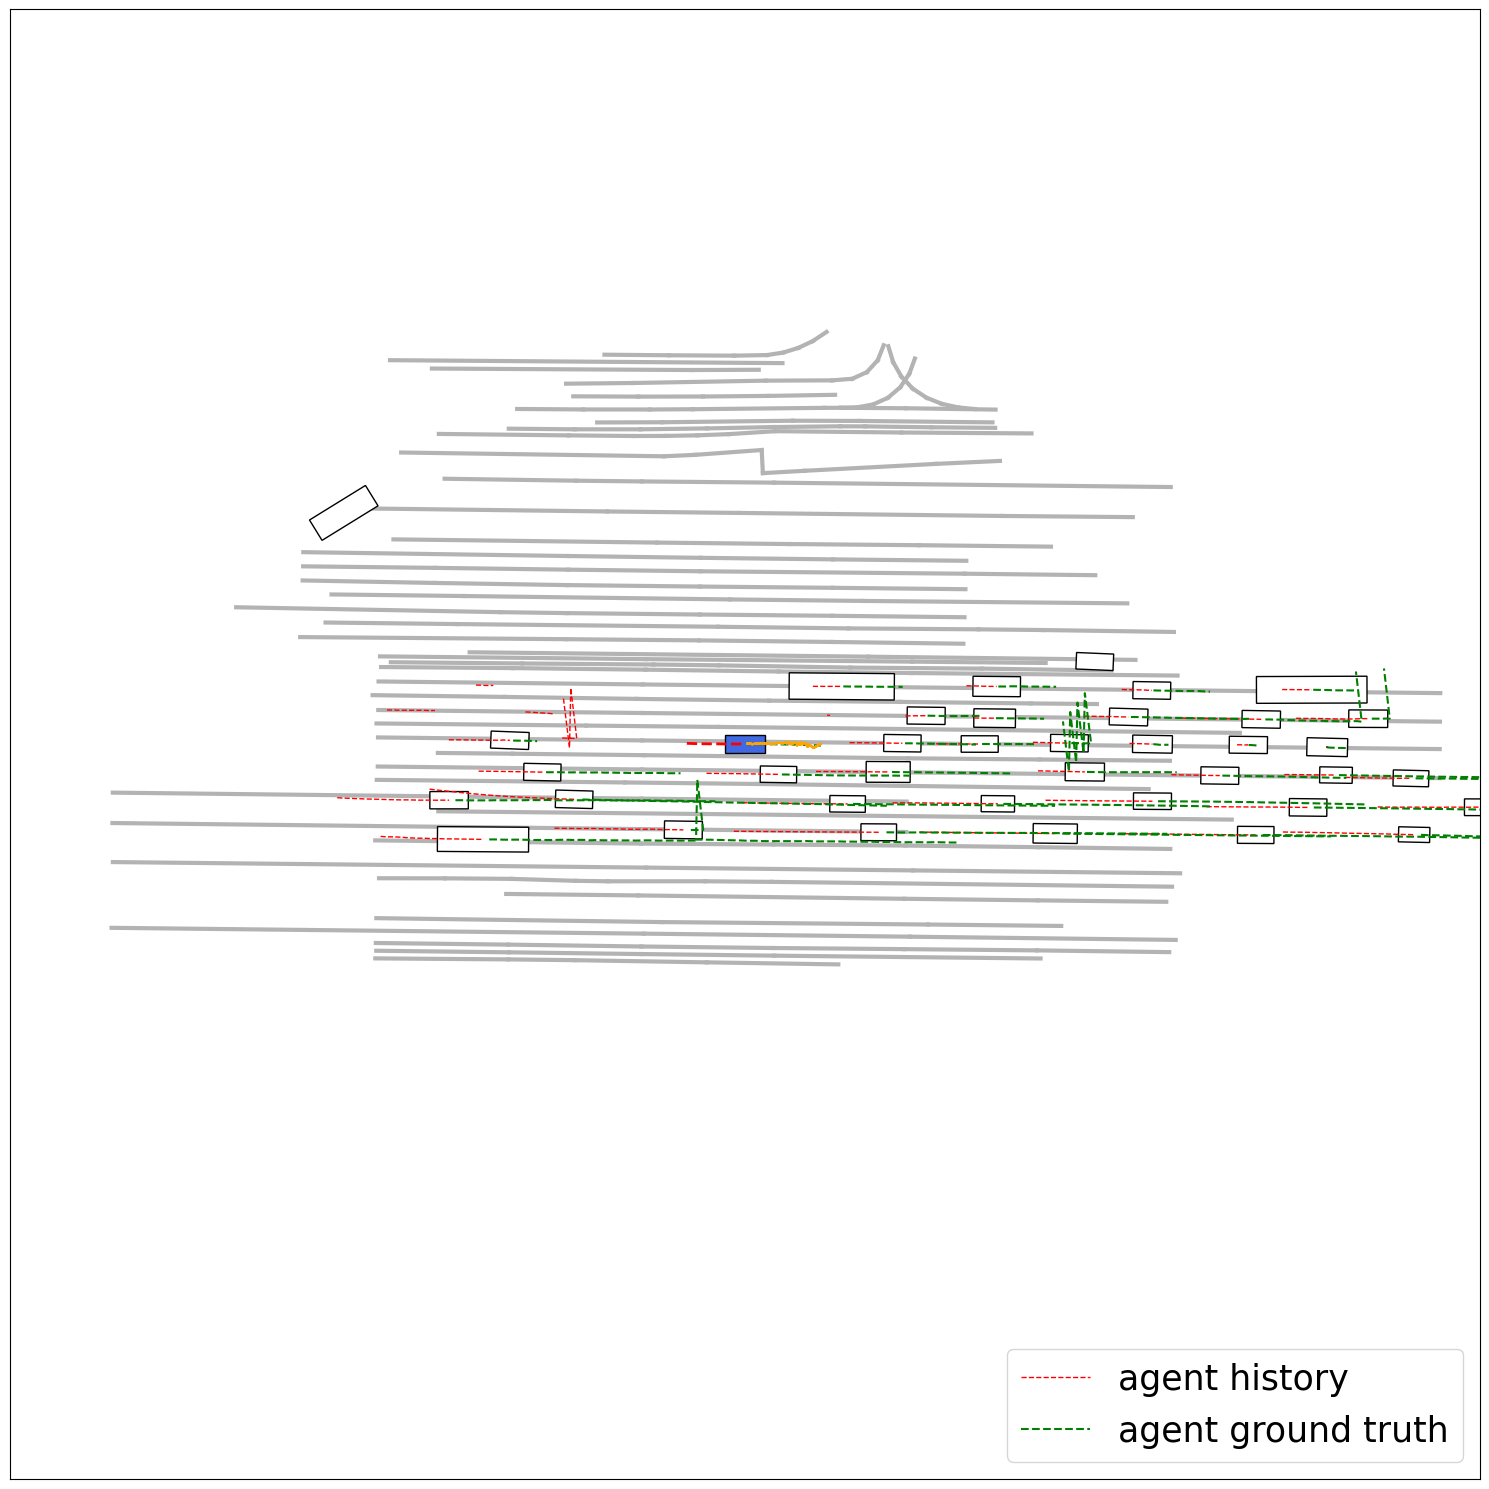

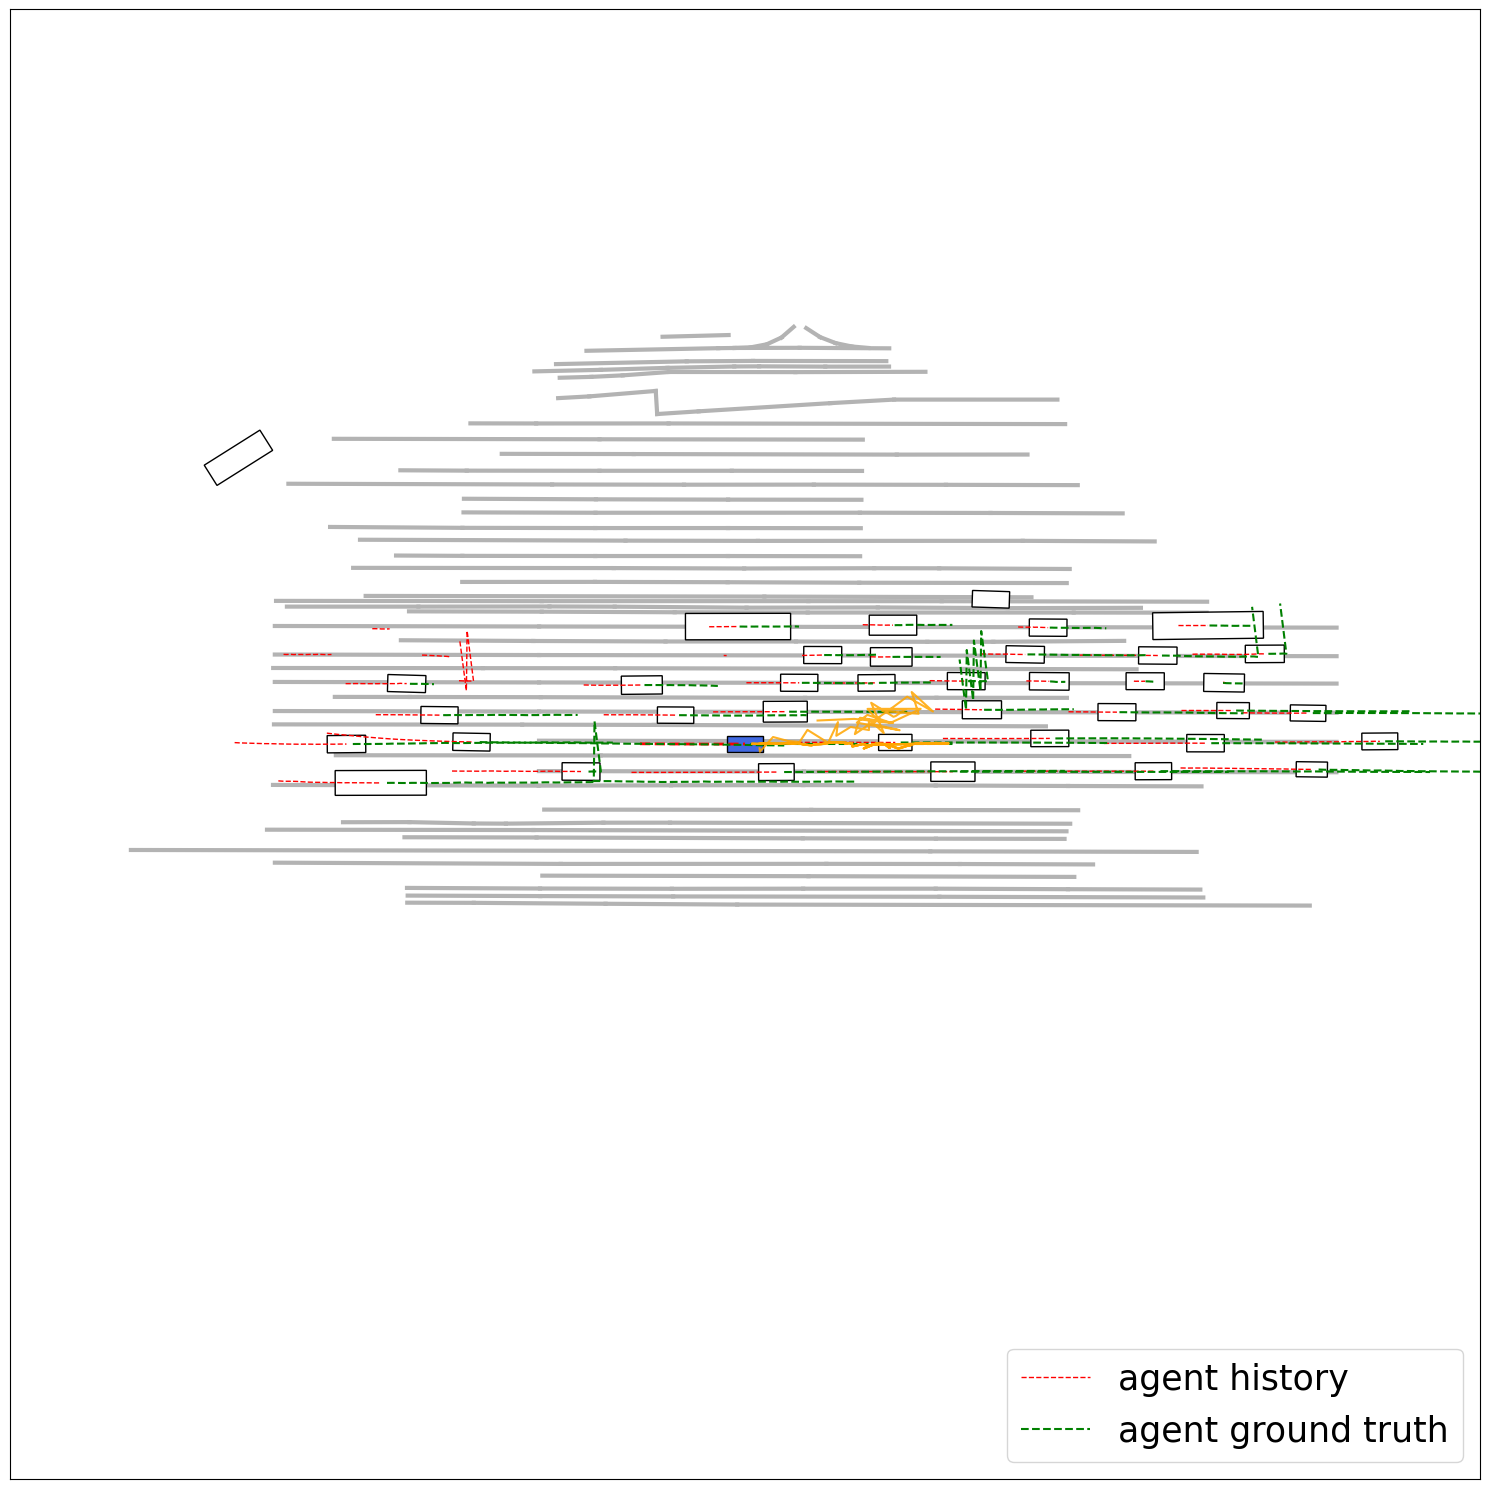

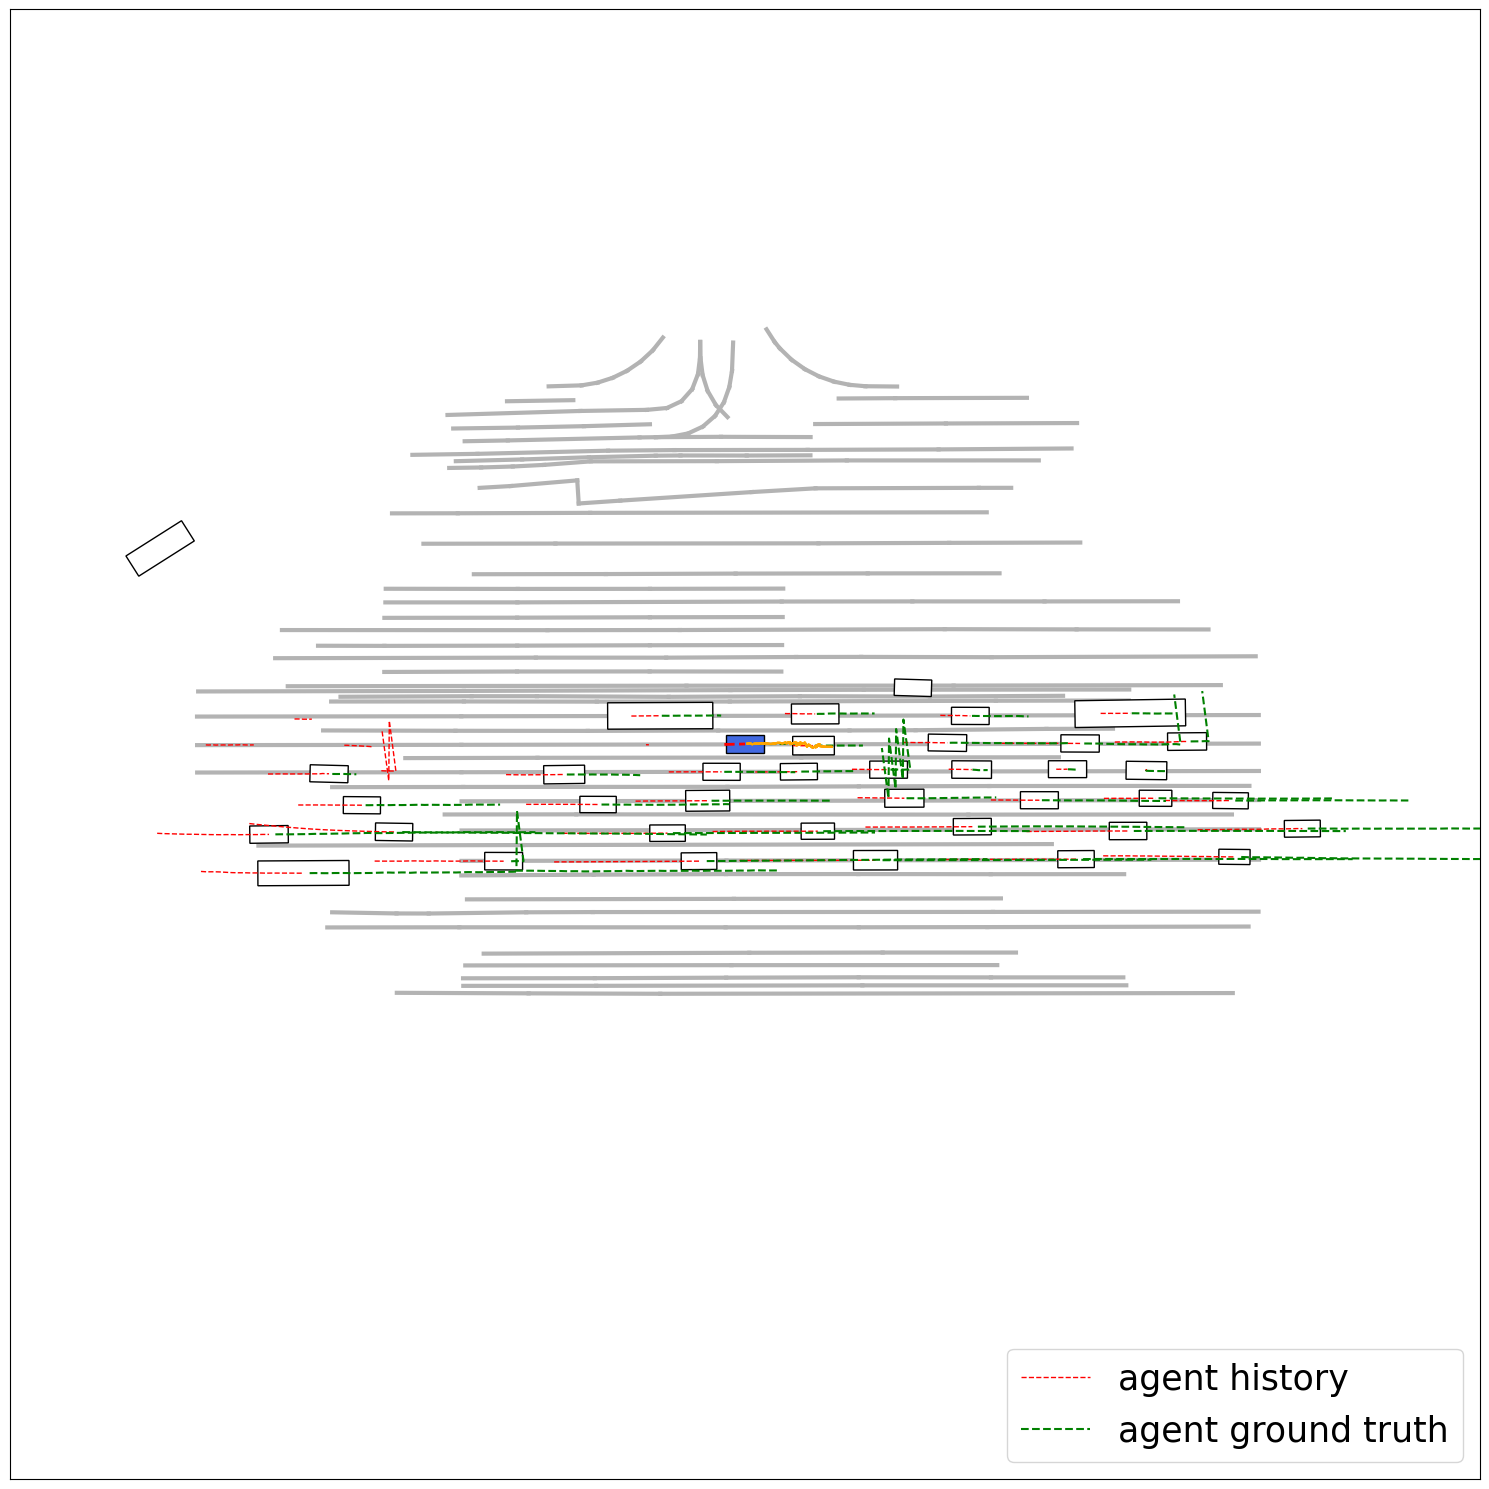

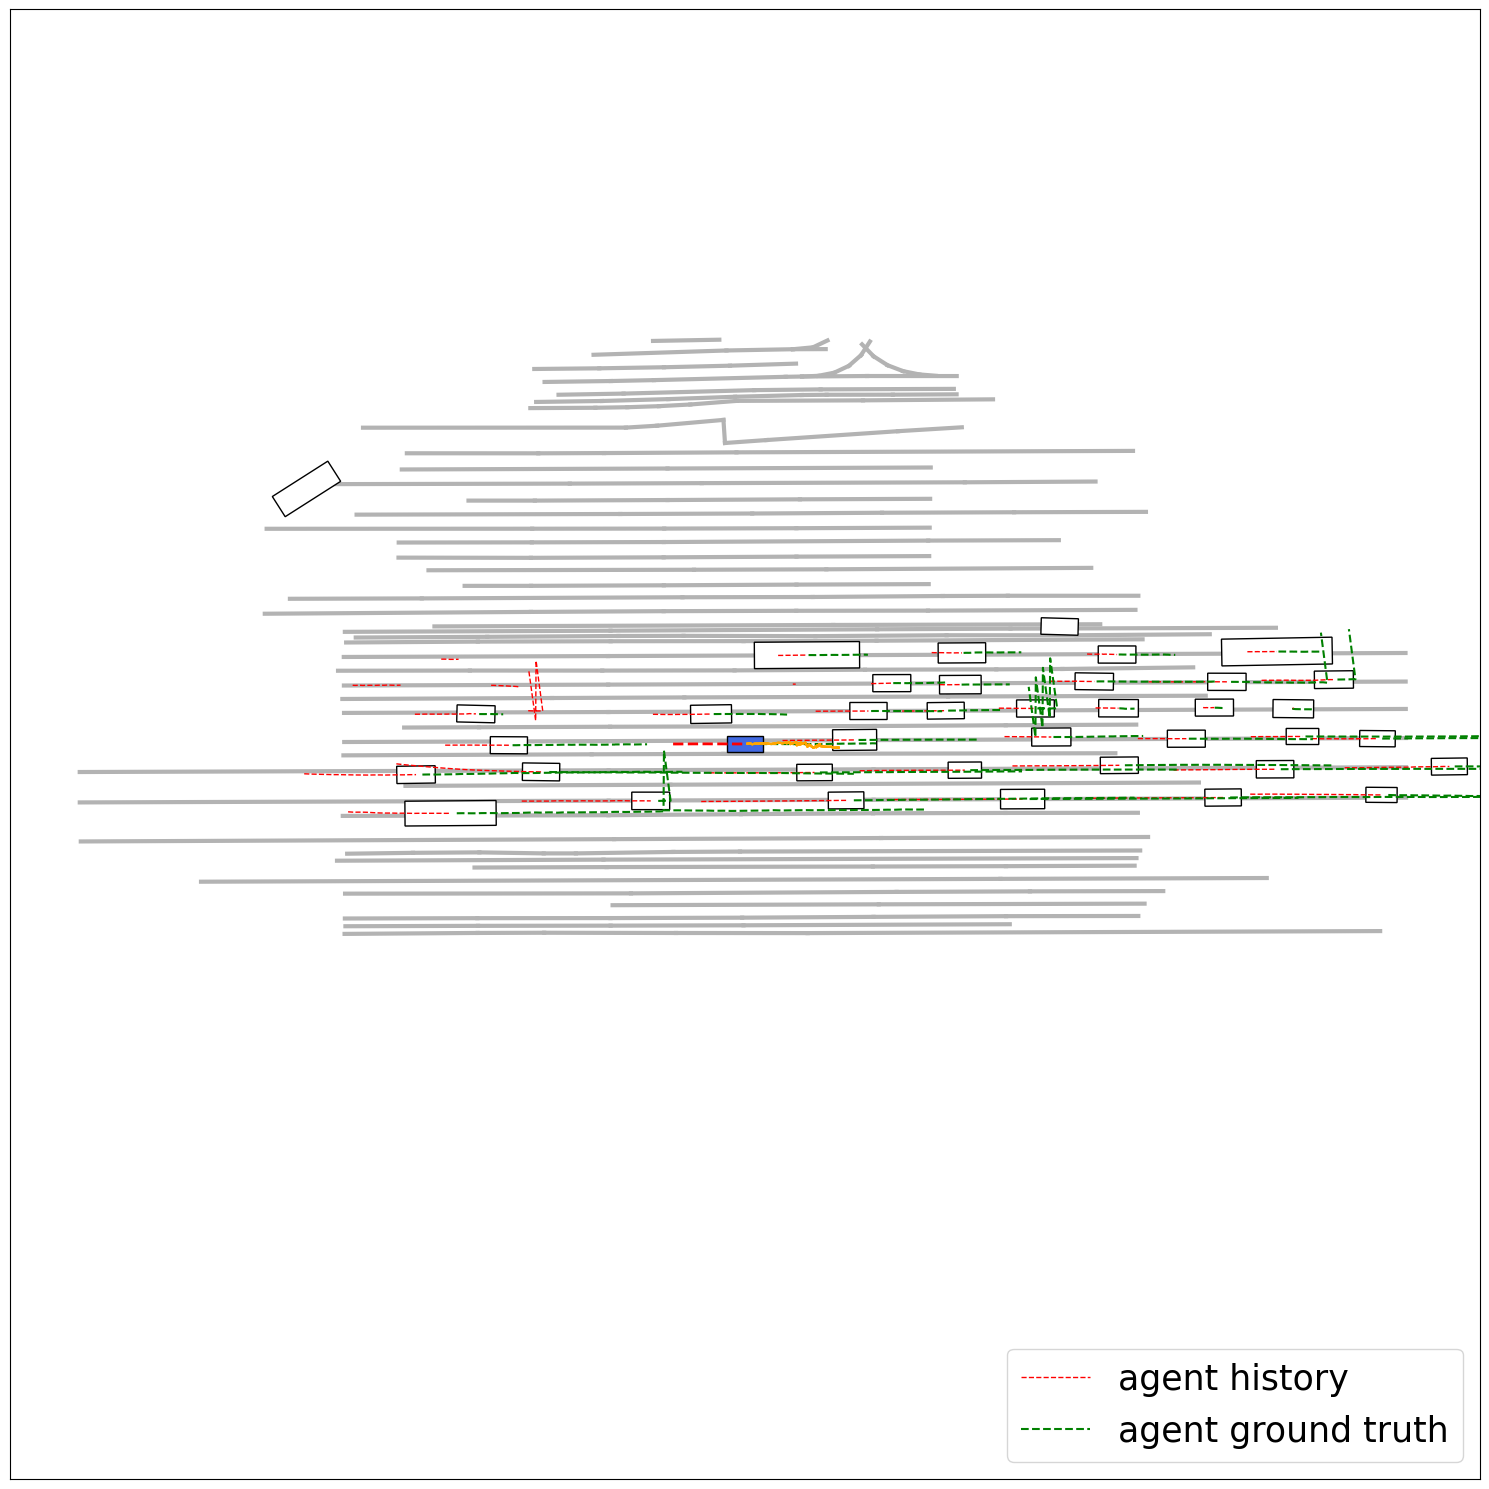

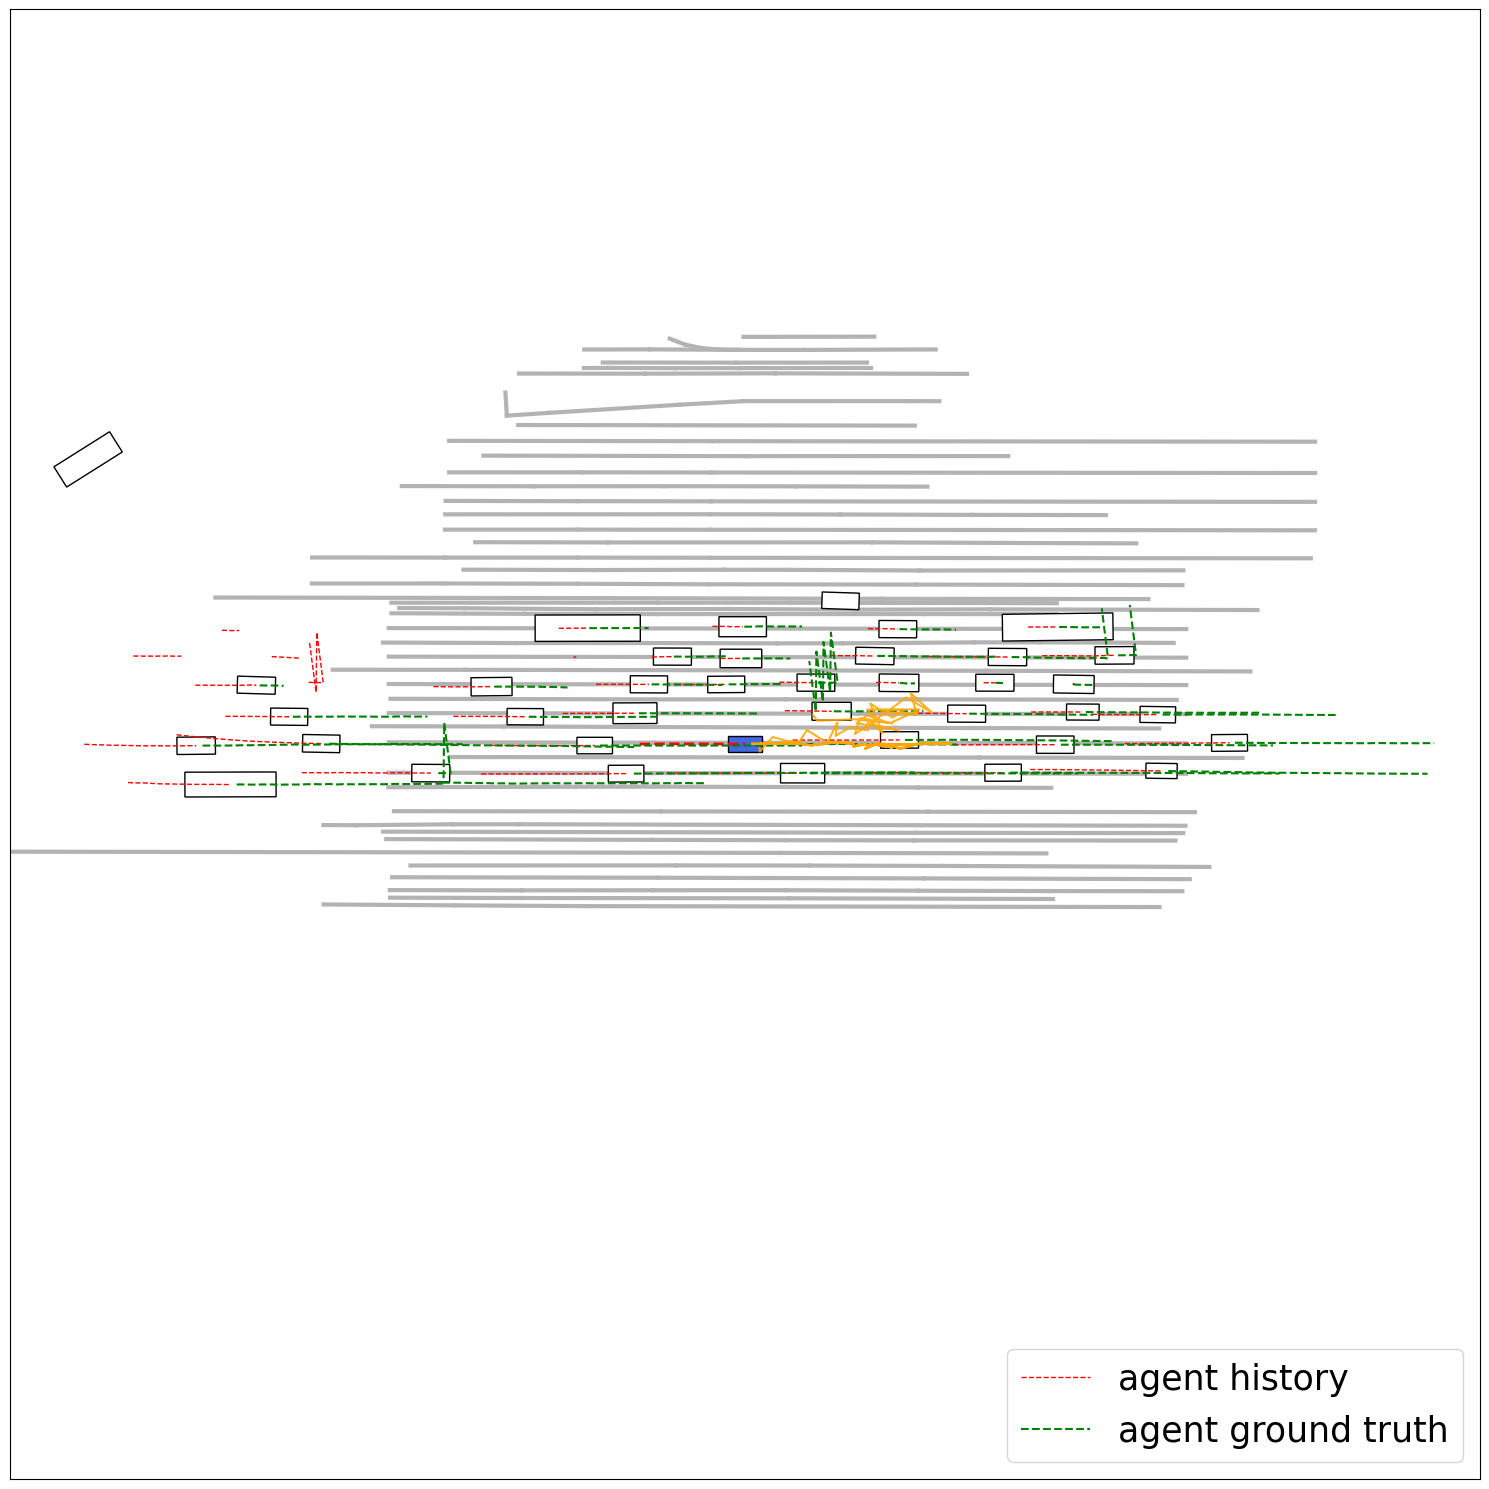

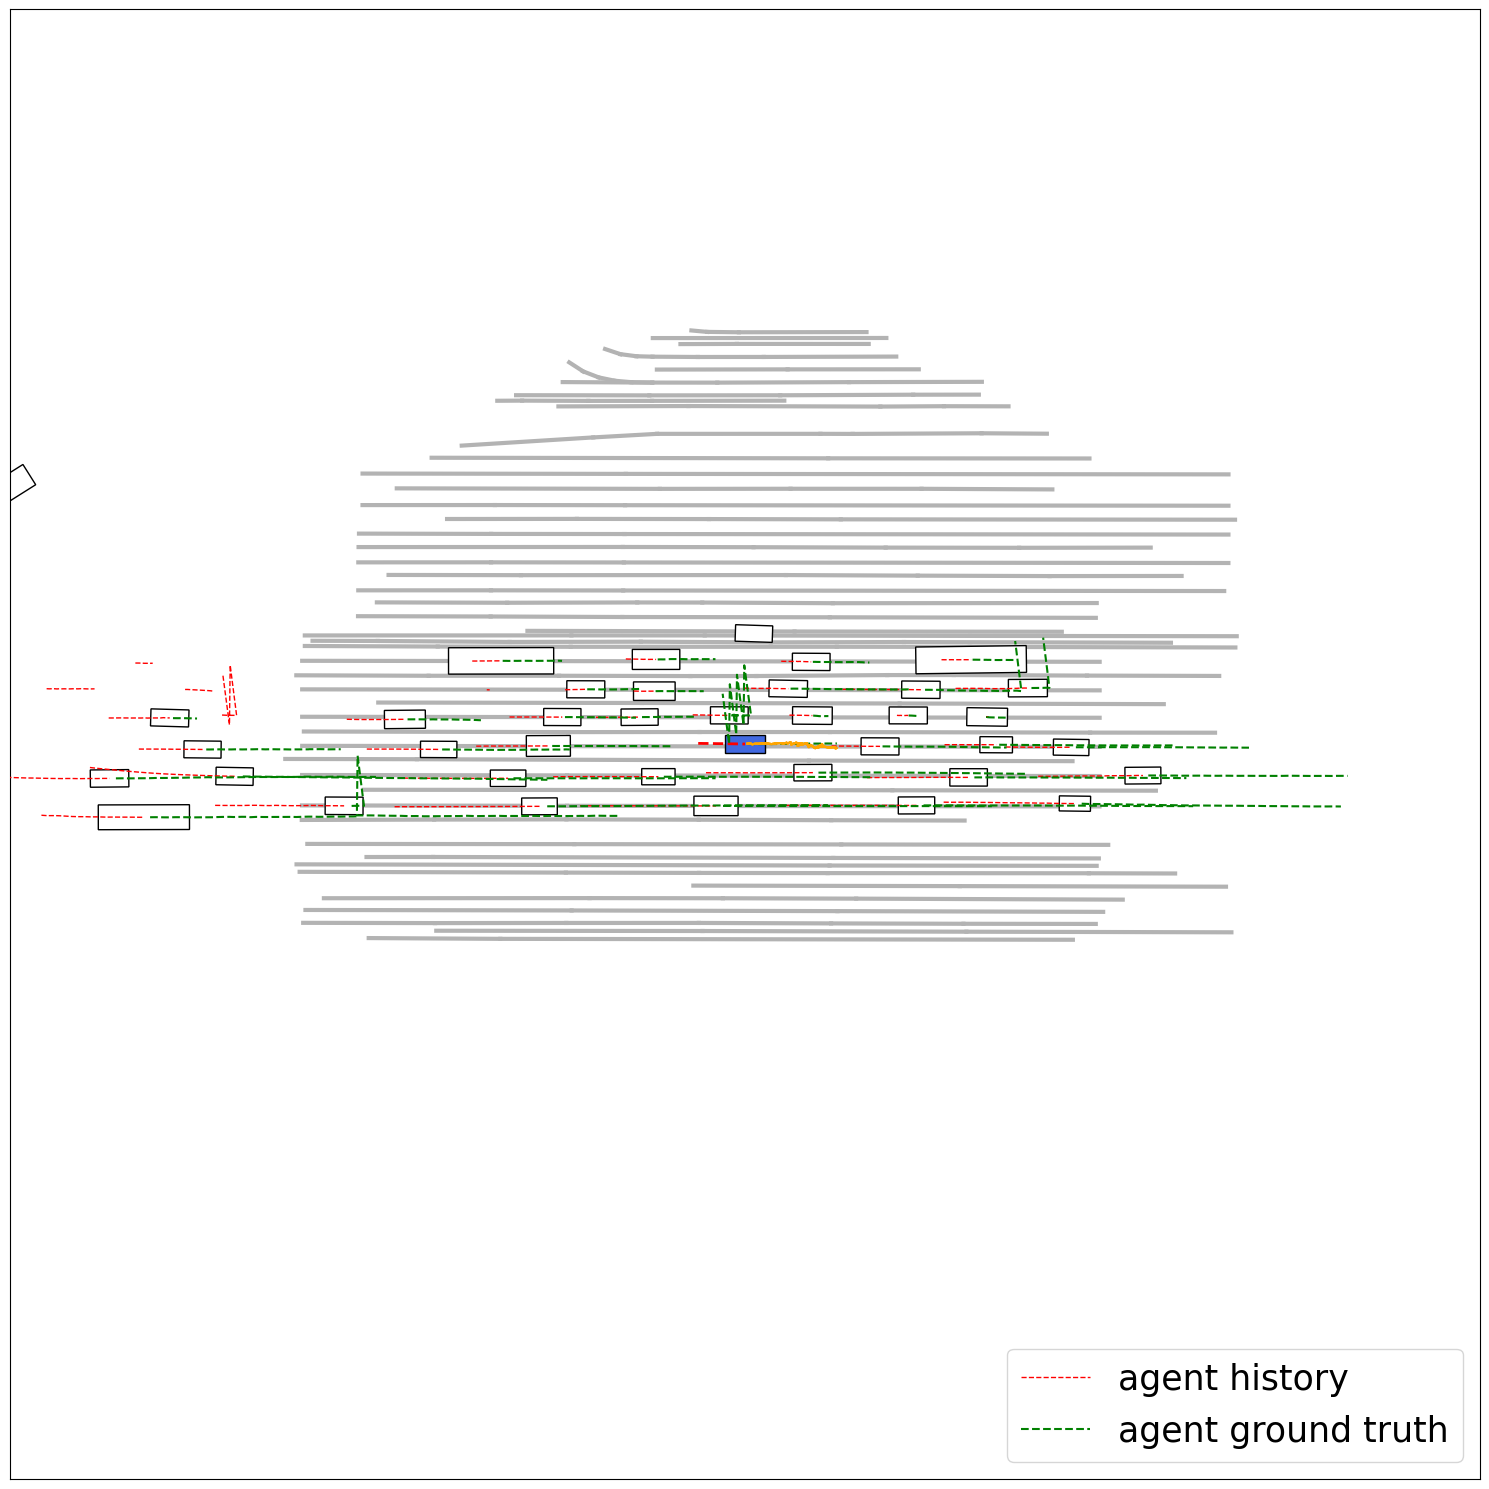

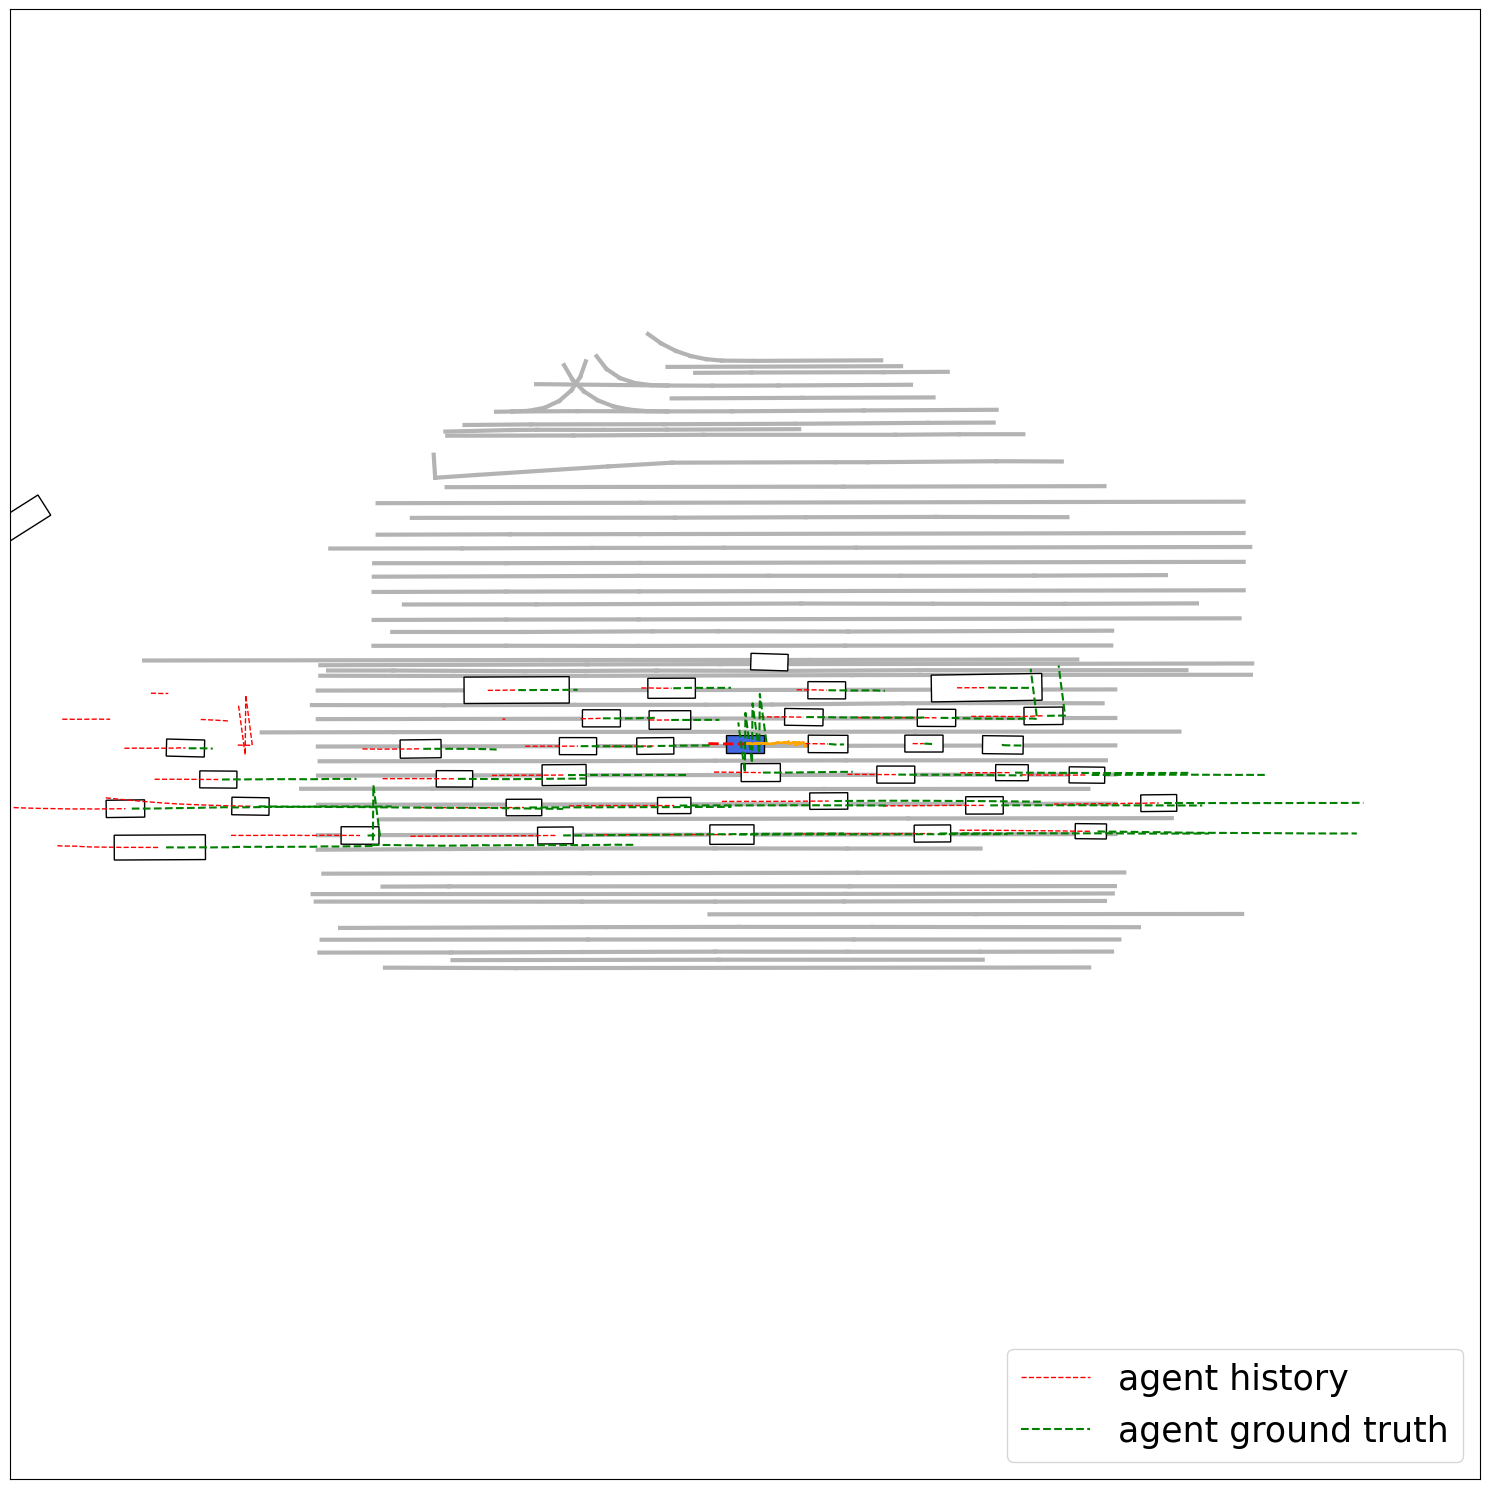

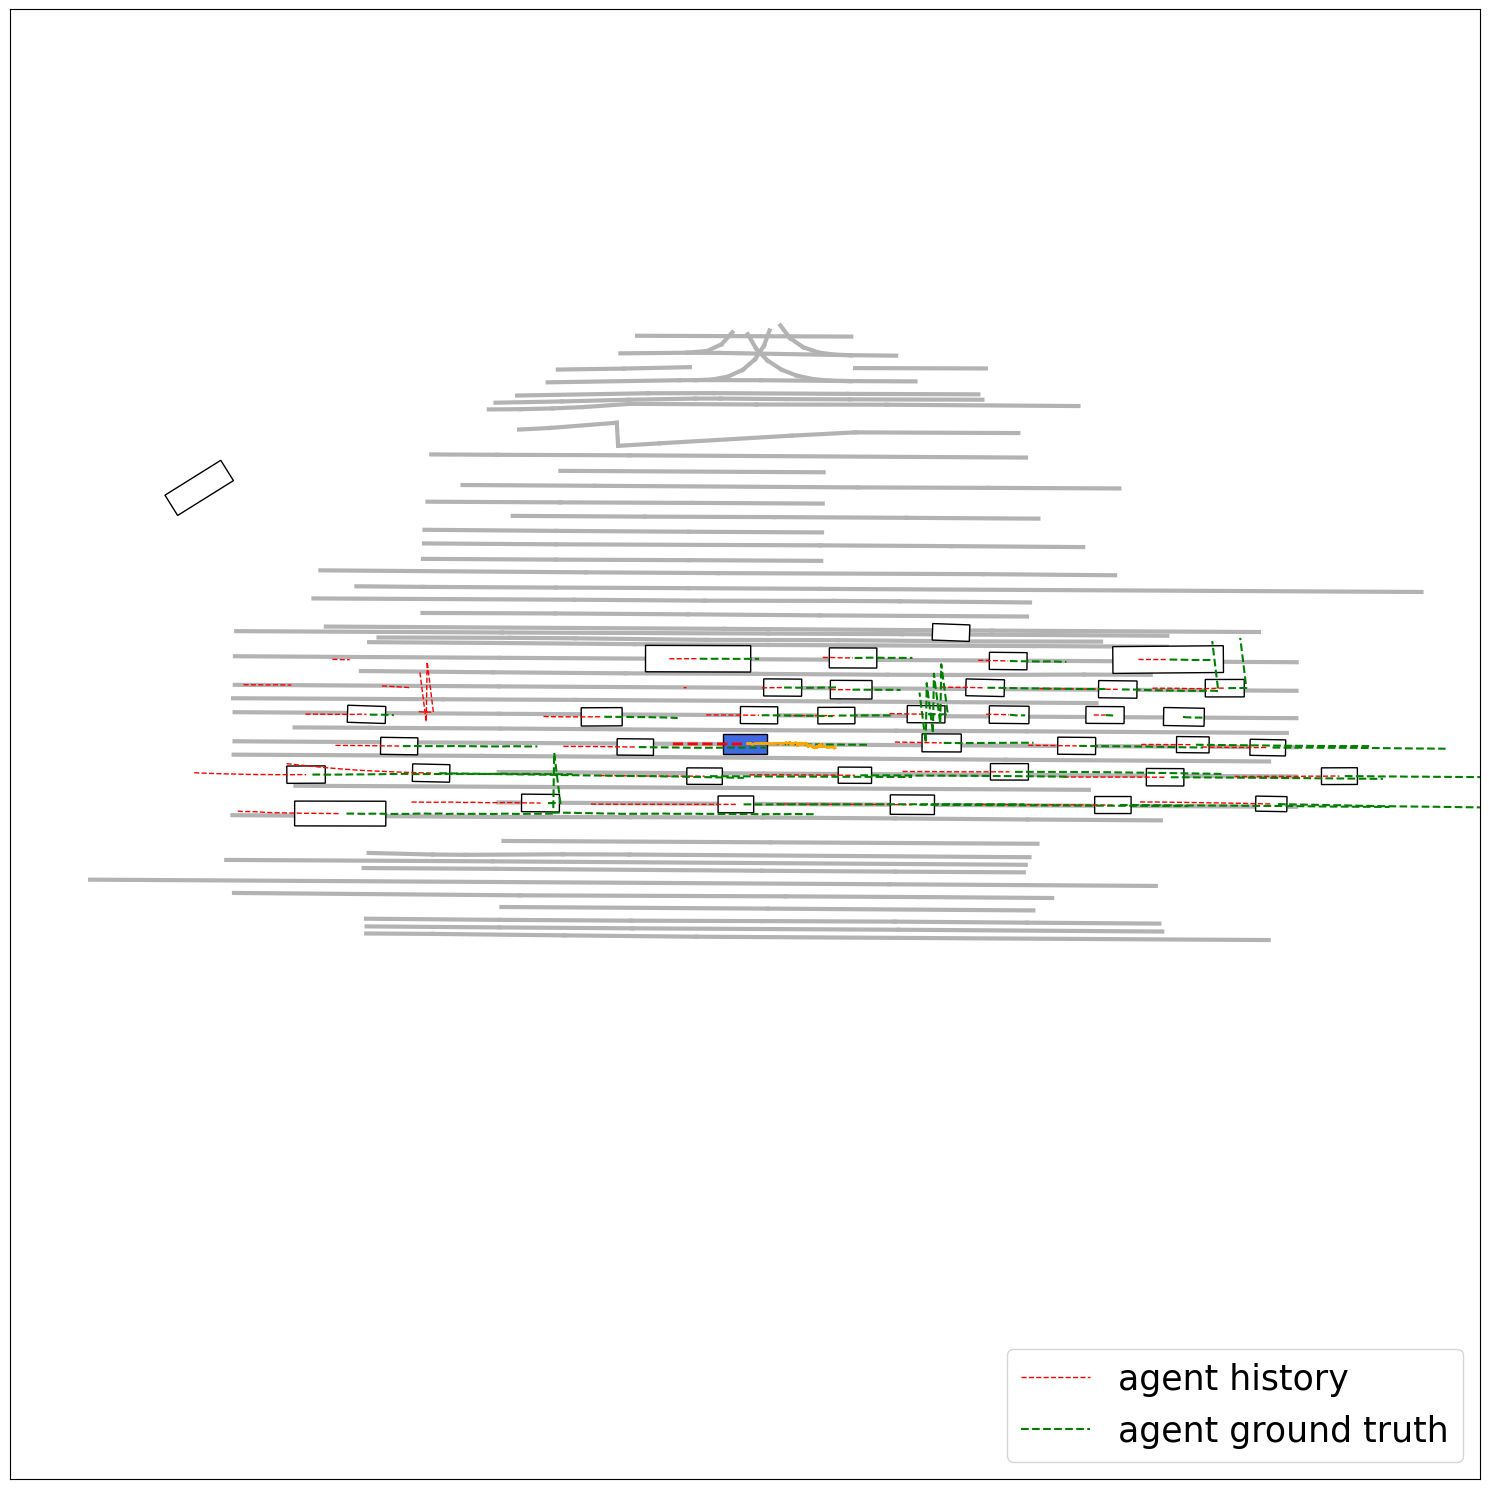

100%|██████████| 500/500 [00:54<00:00,  9.09it/s]
INFO:root:Epoch: 4, Last loss: 373.7908630371094
100%|█████████▉| 499/500 [00:50<00:00,  5.44it/s]

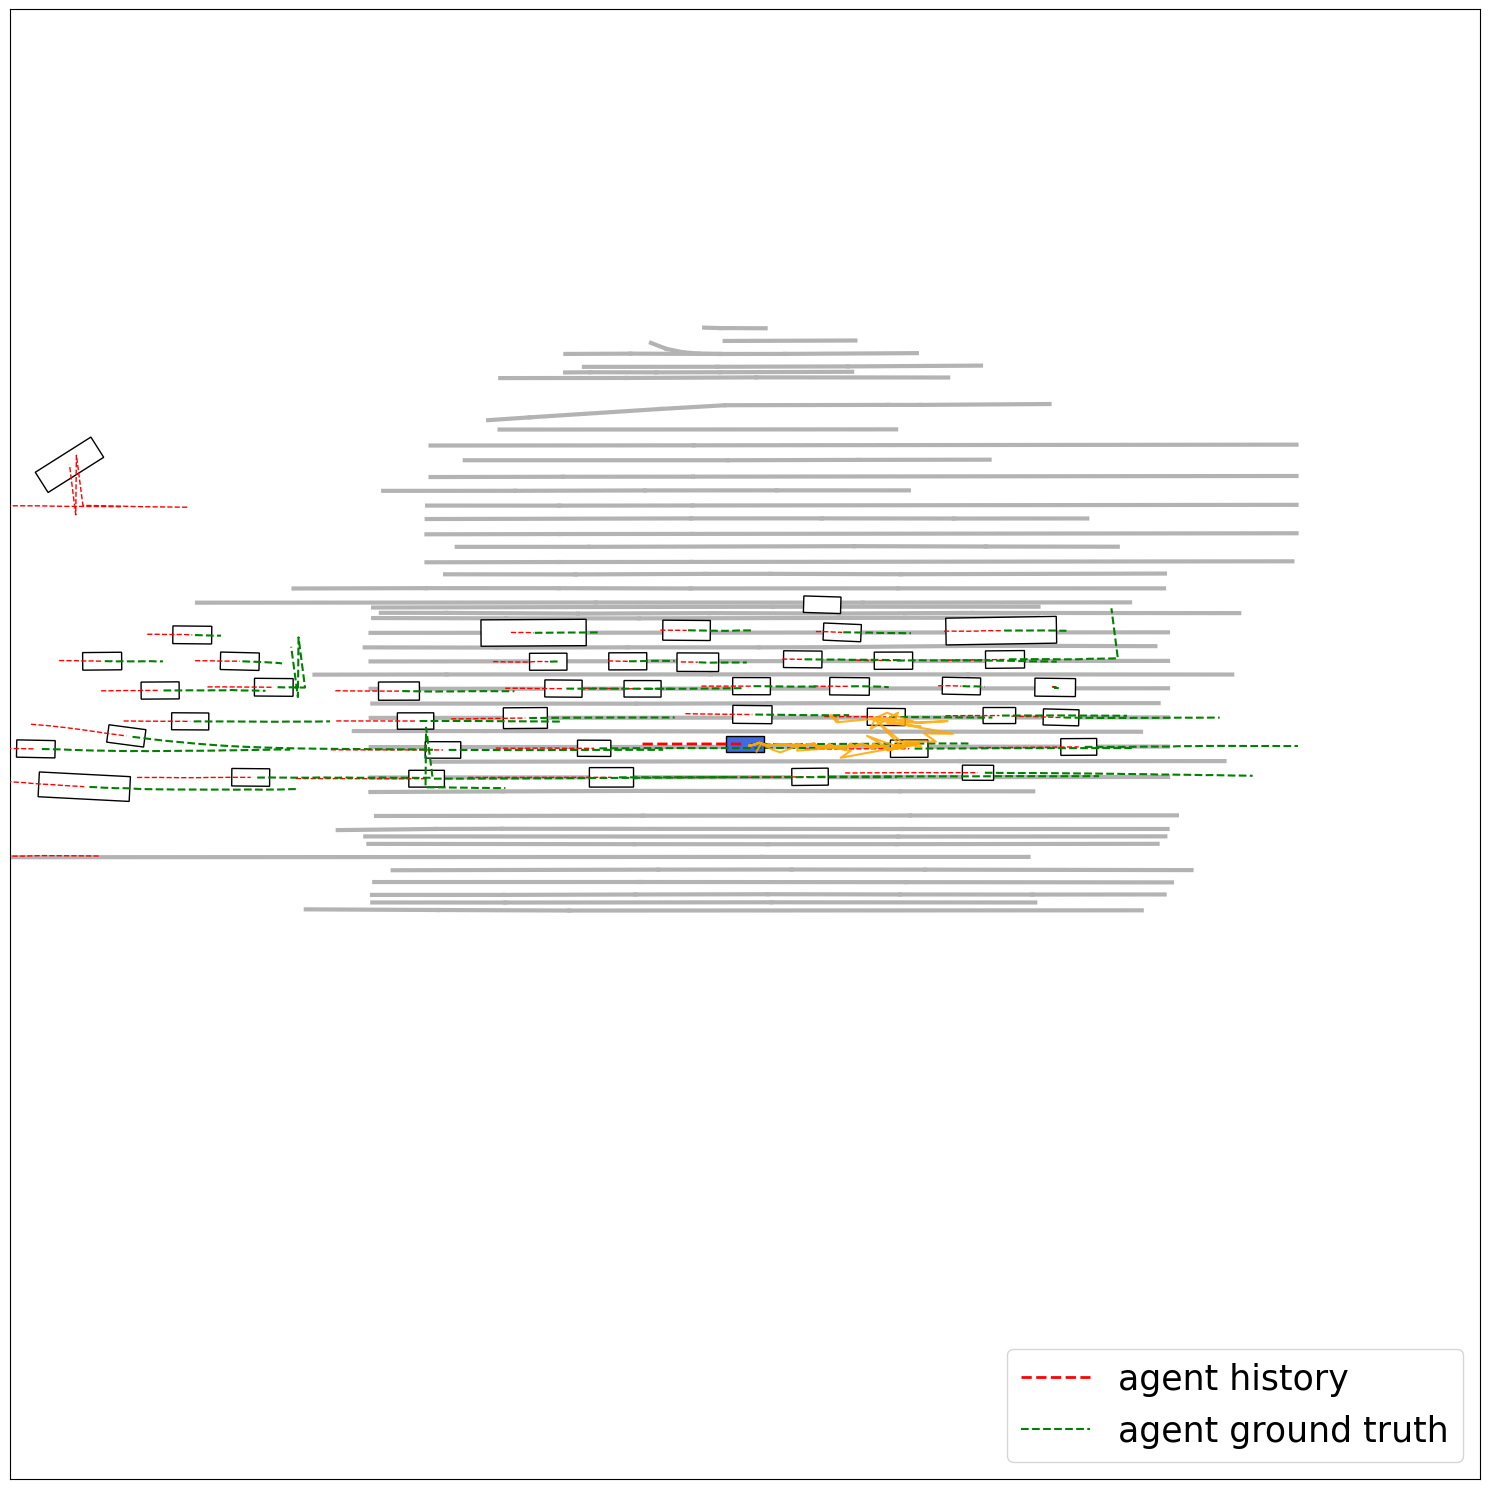

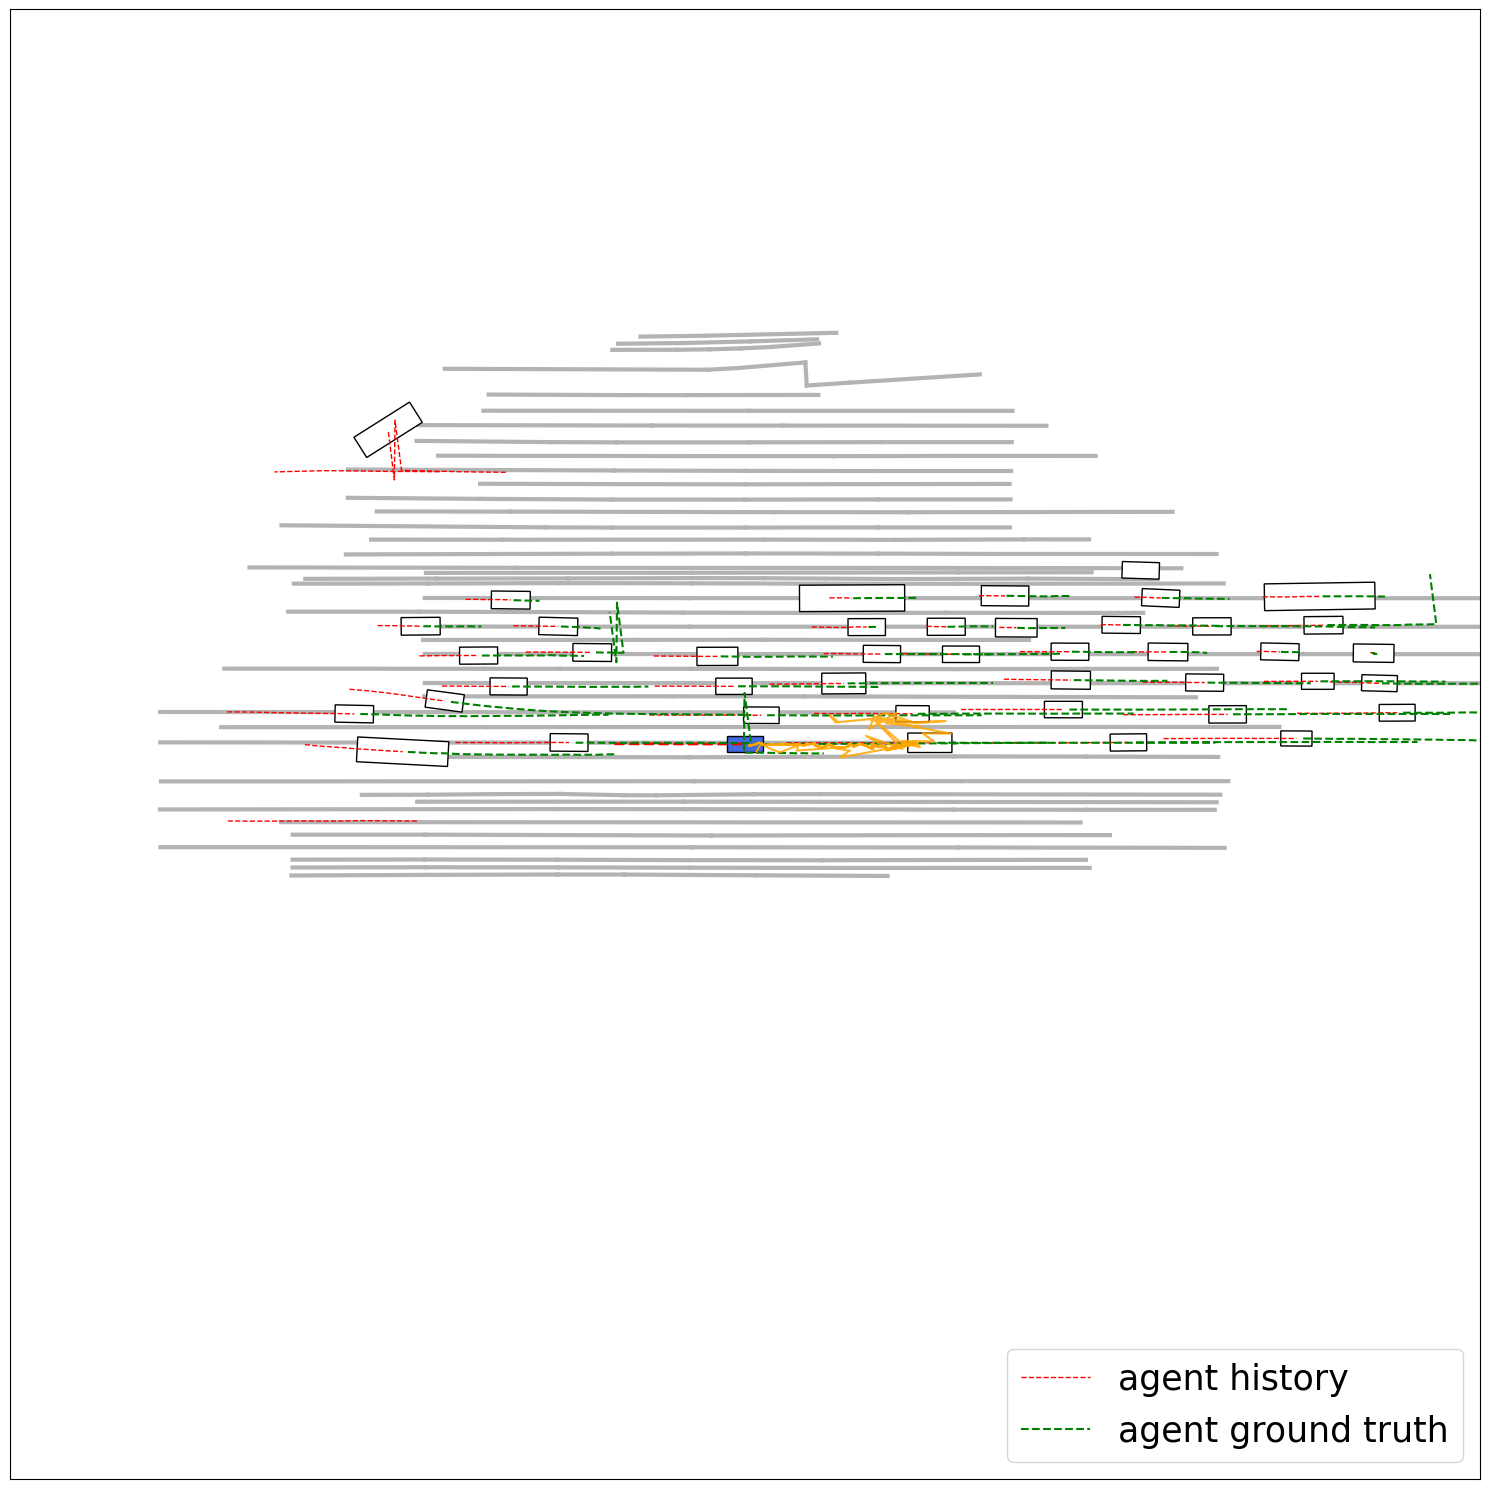

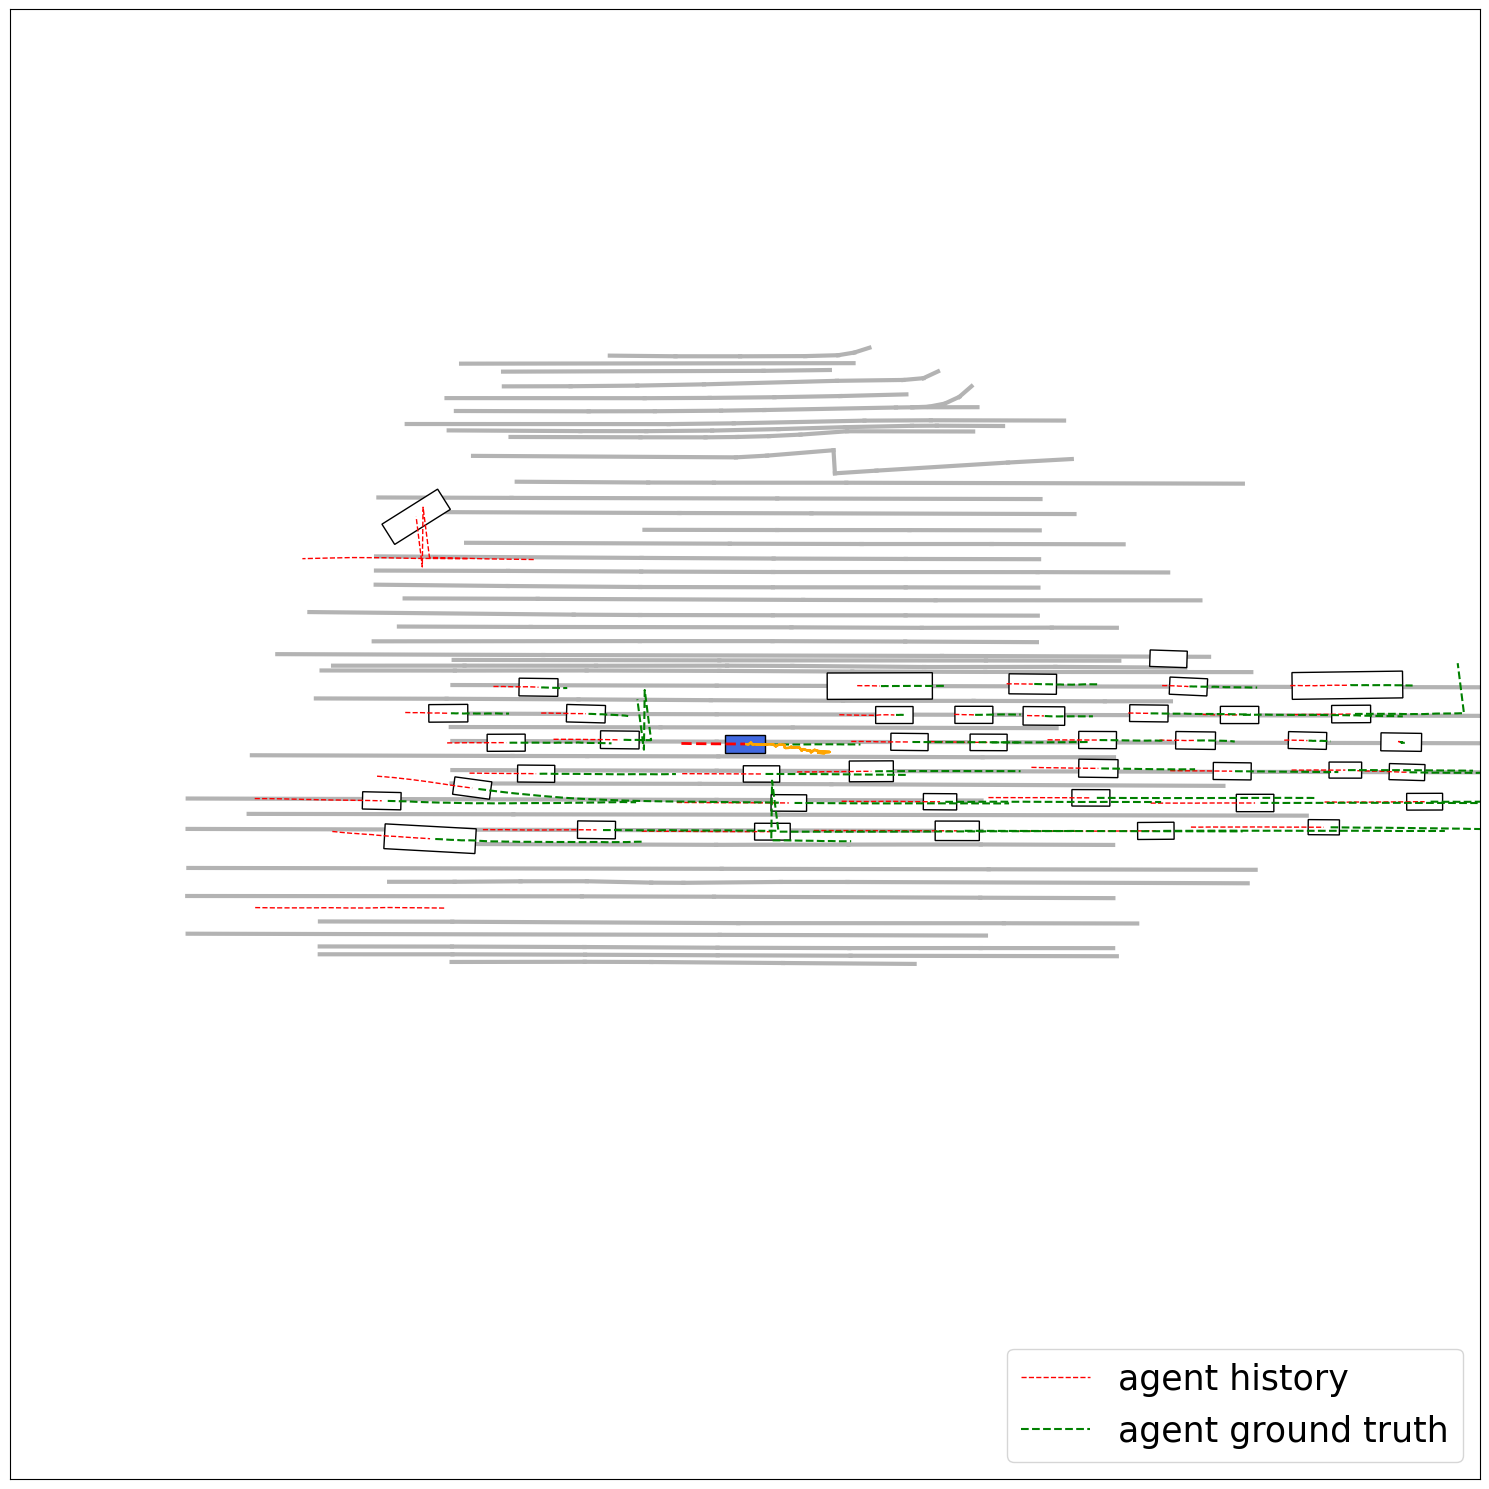

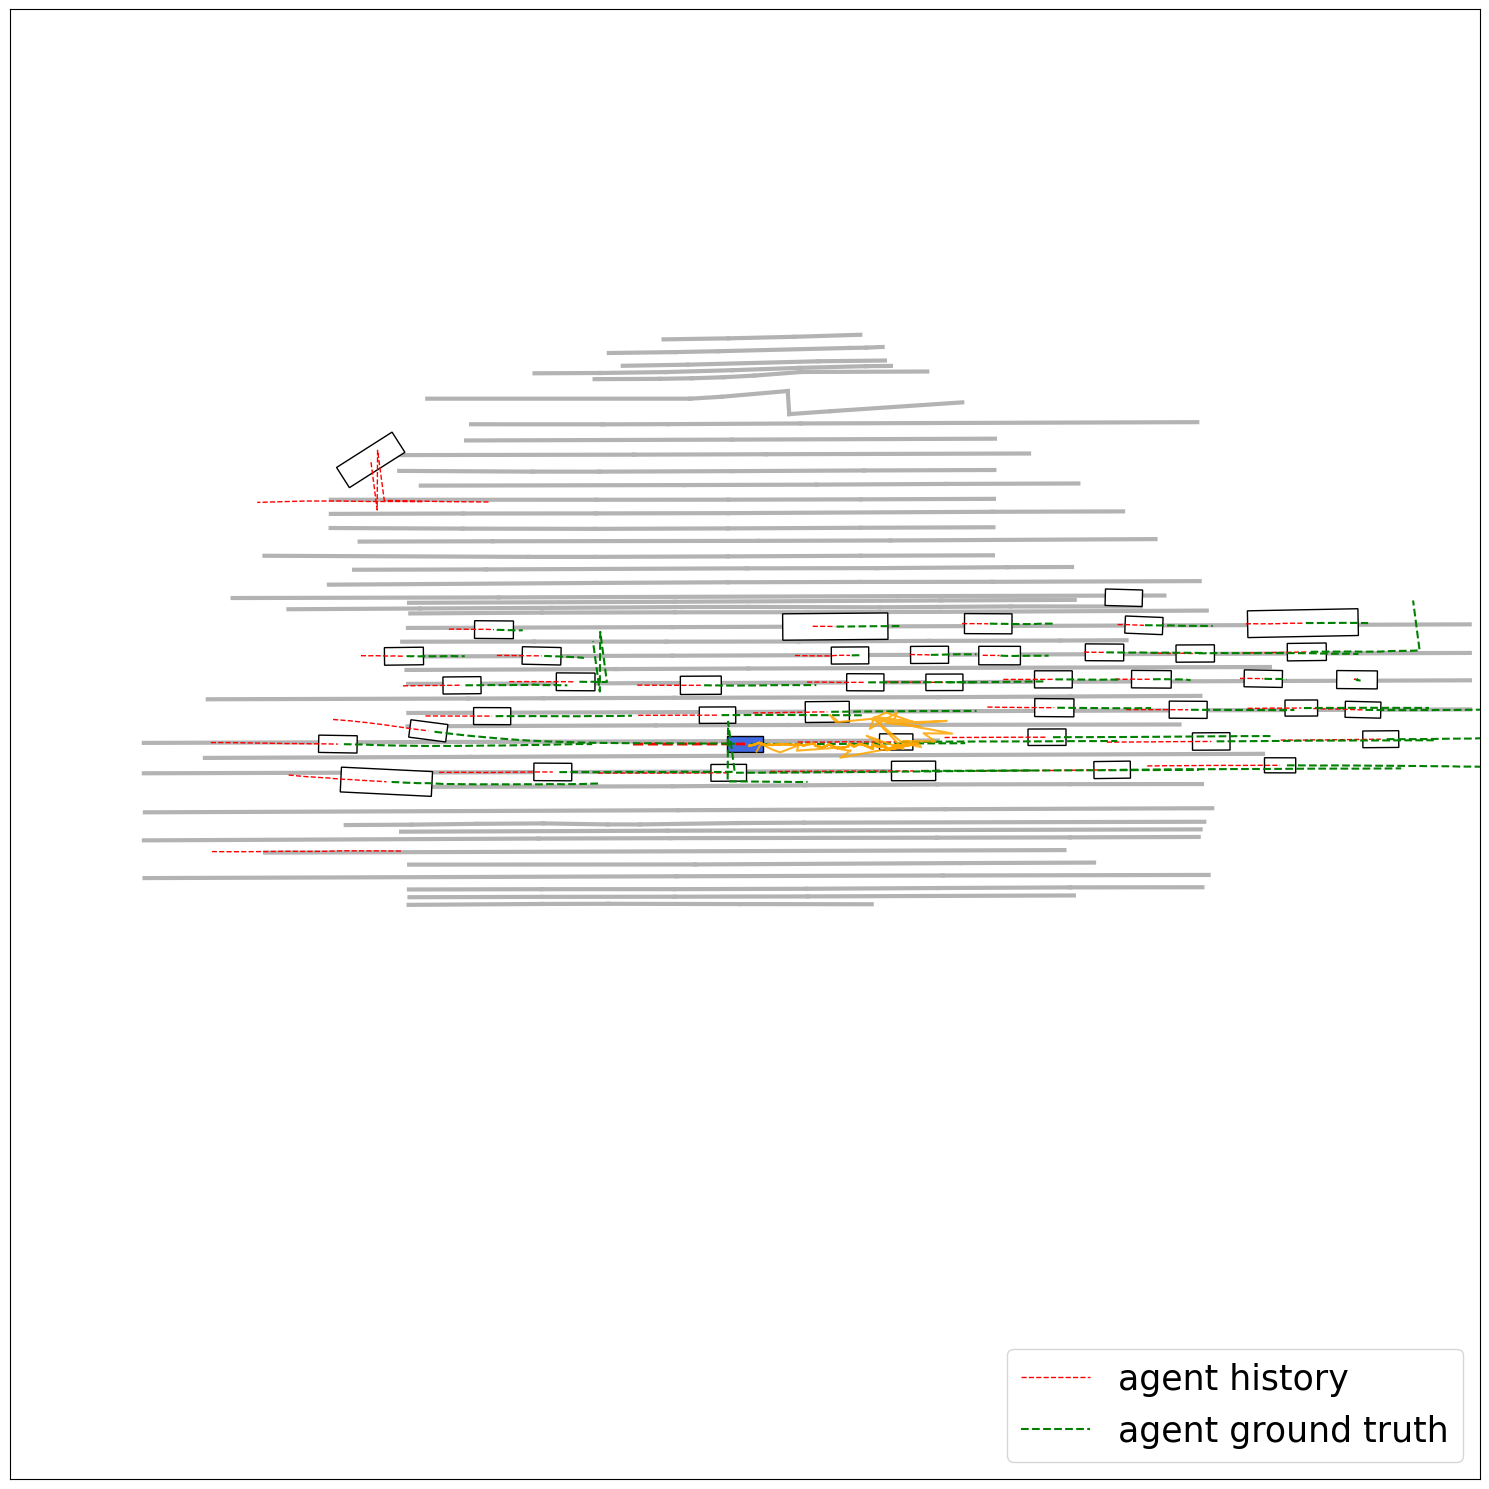

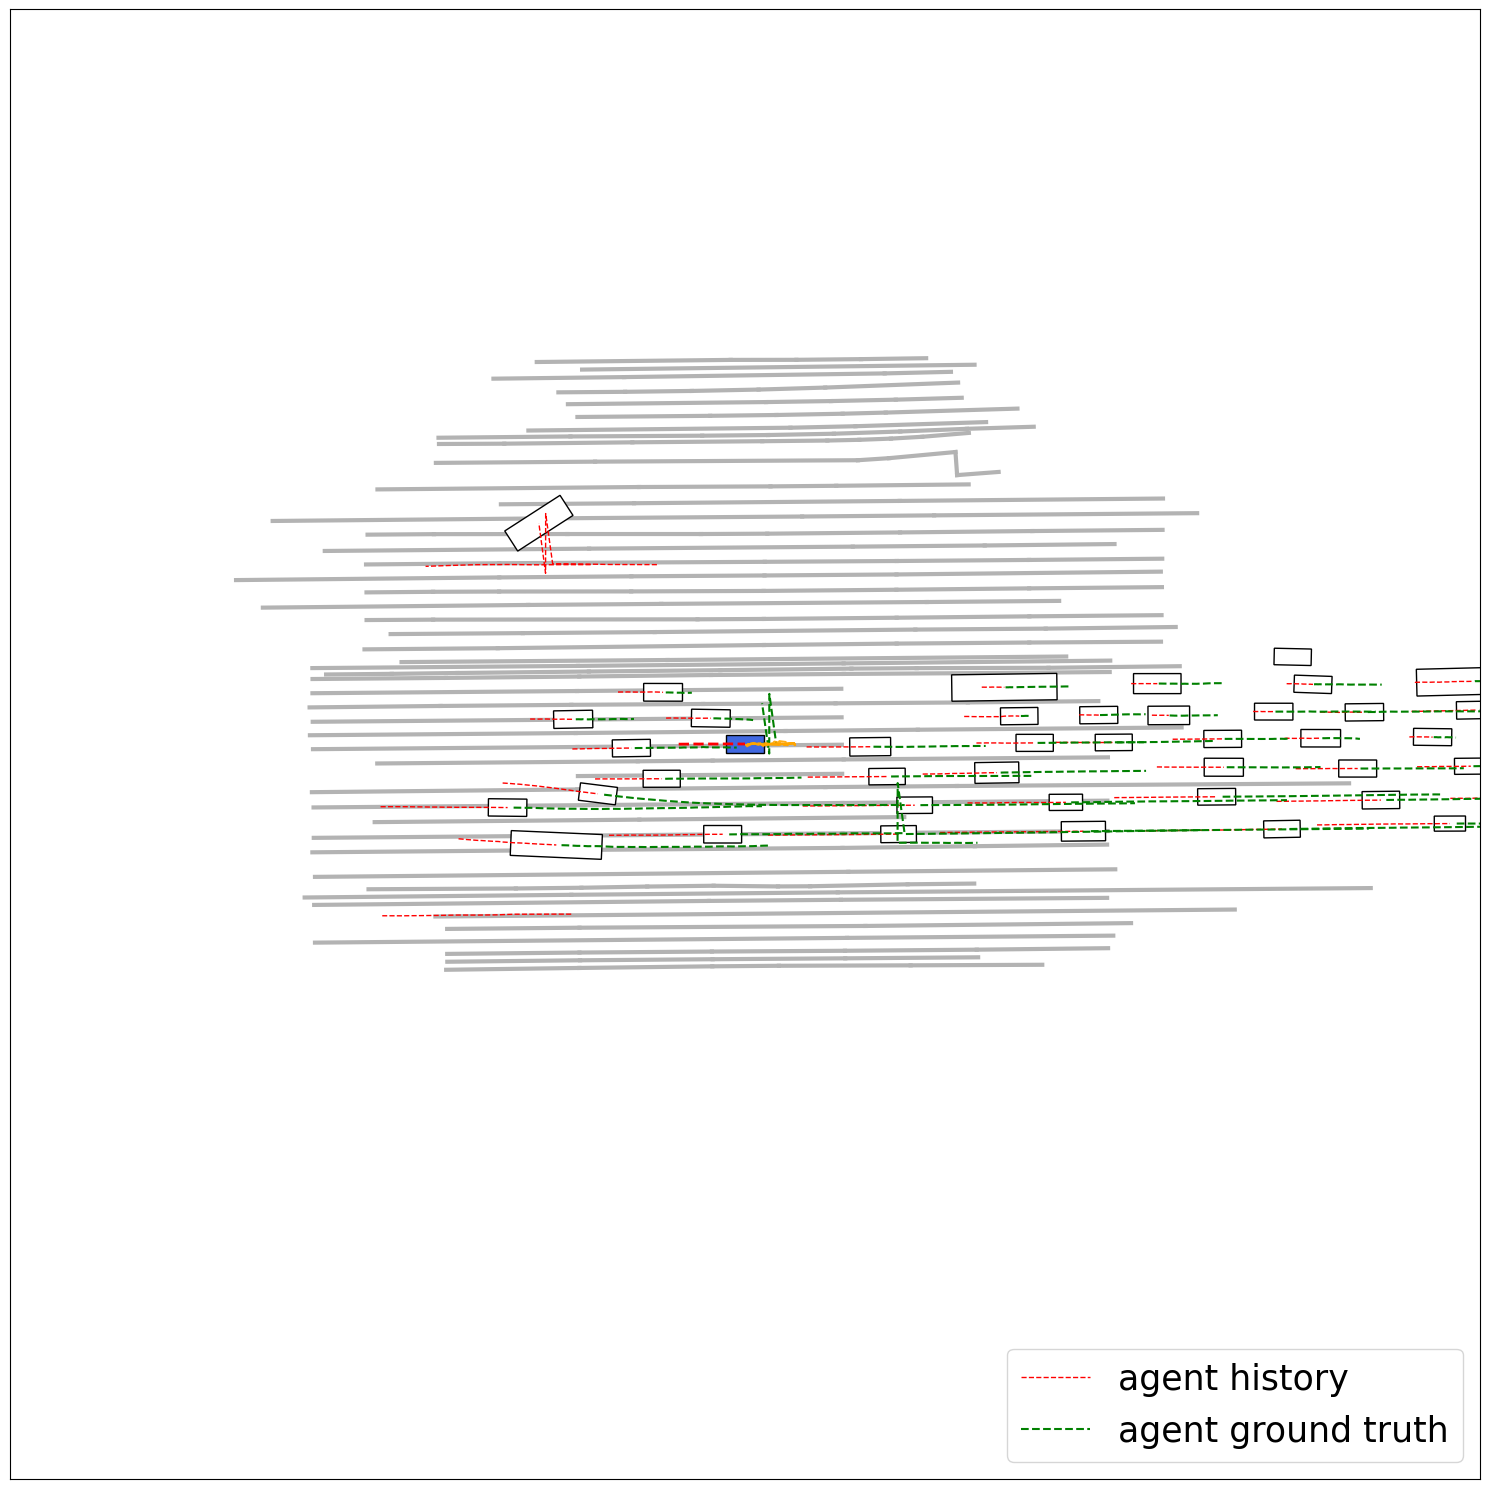

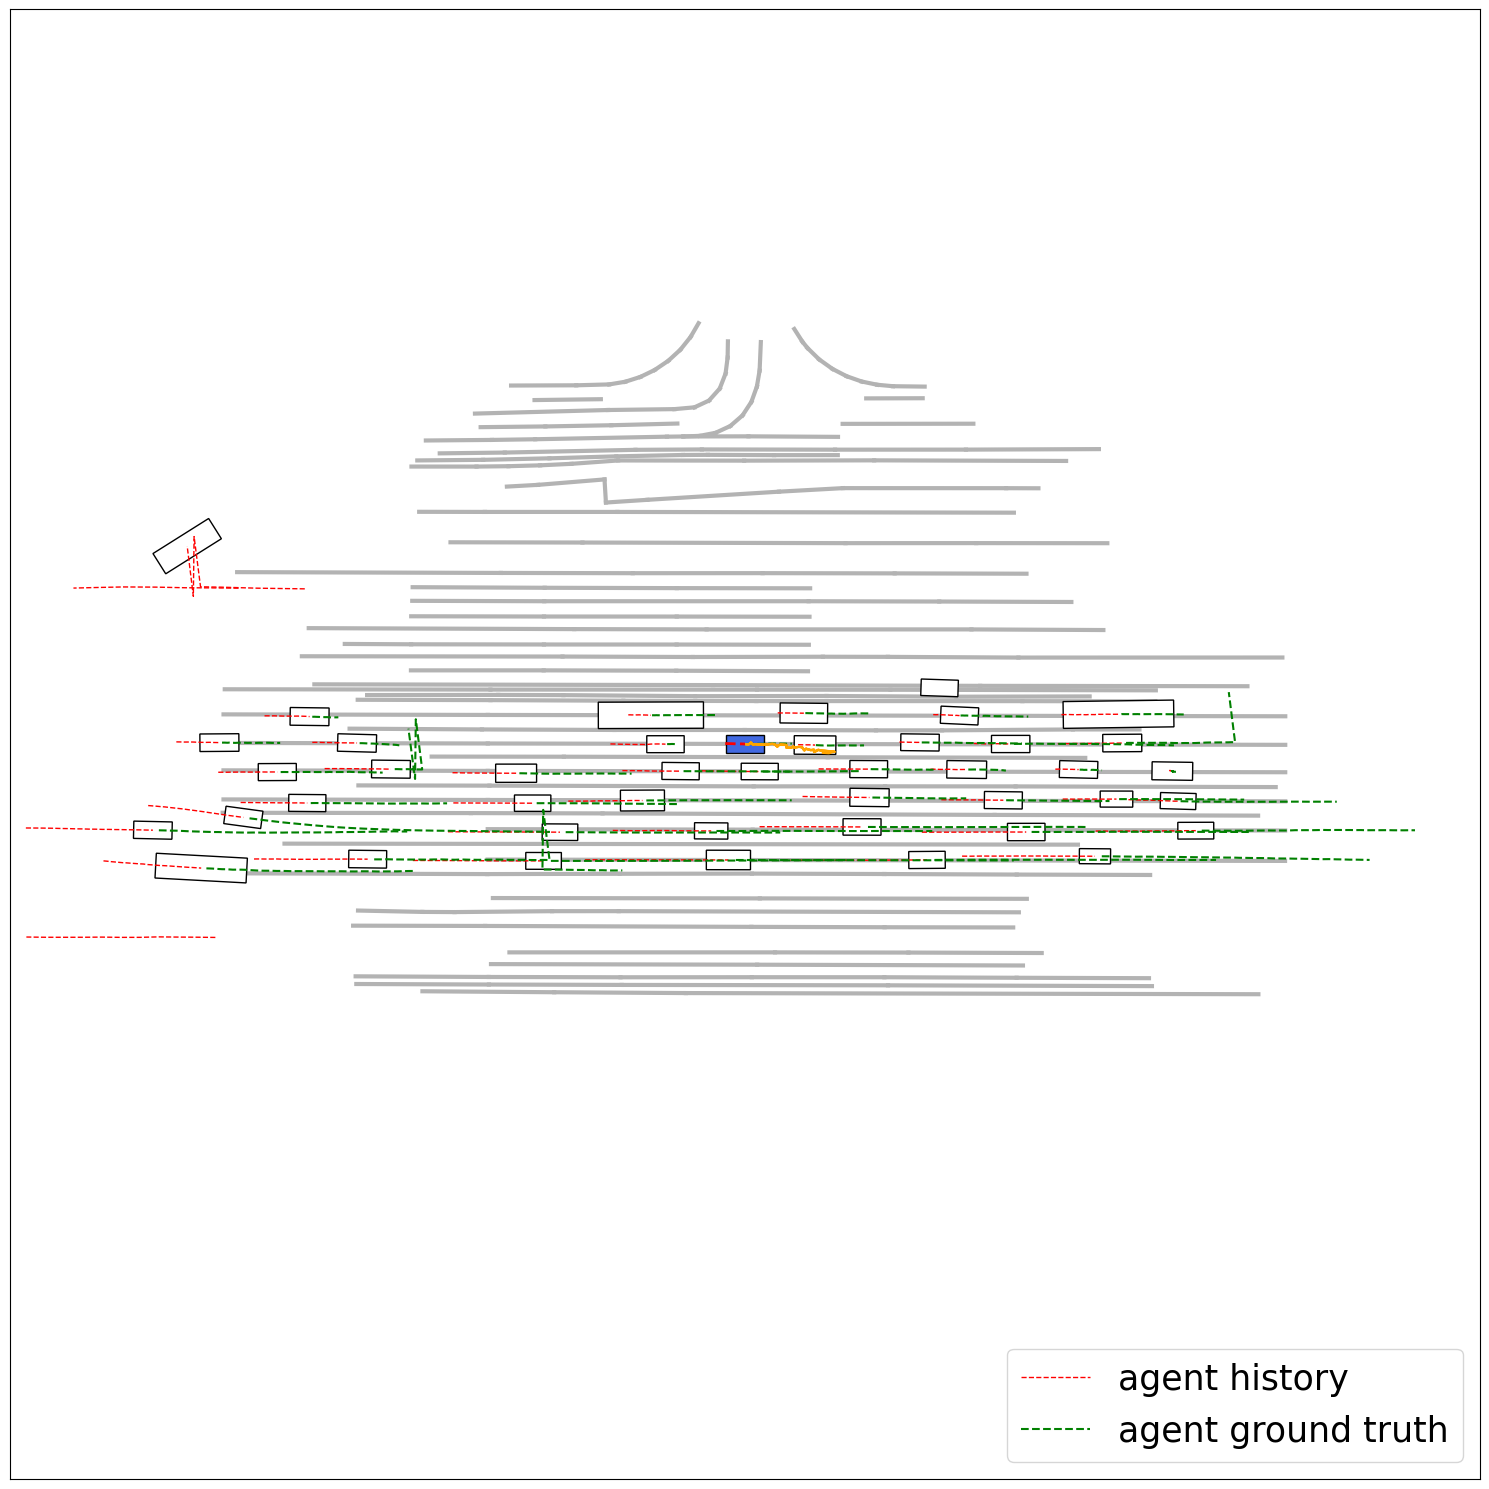

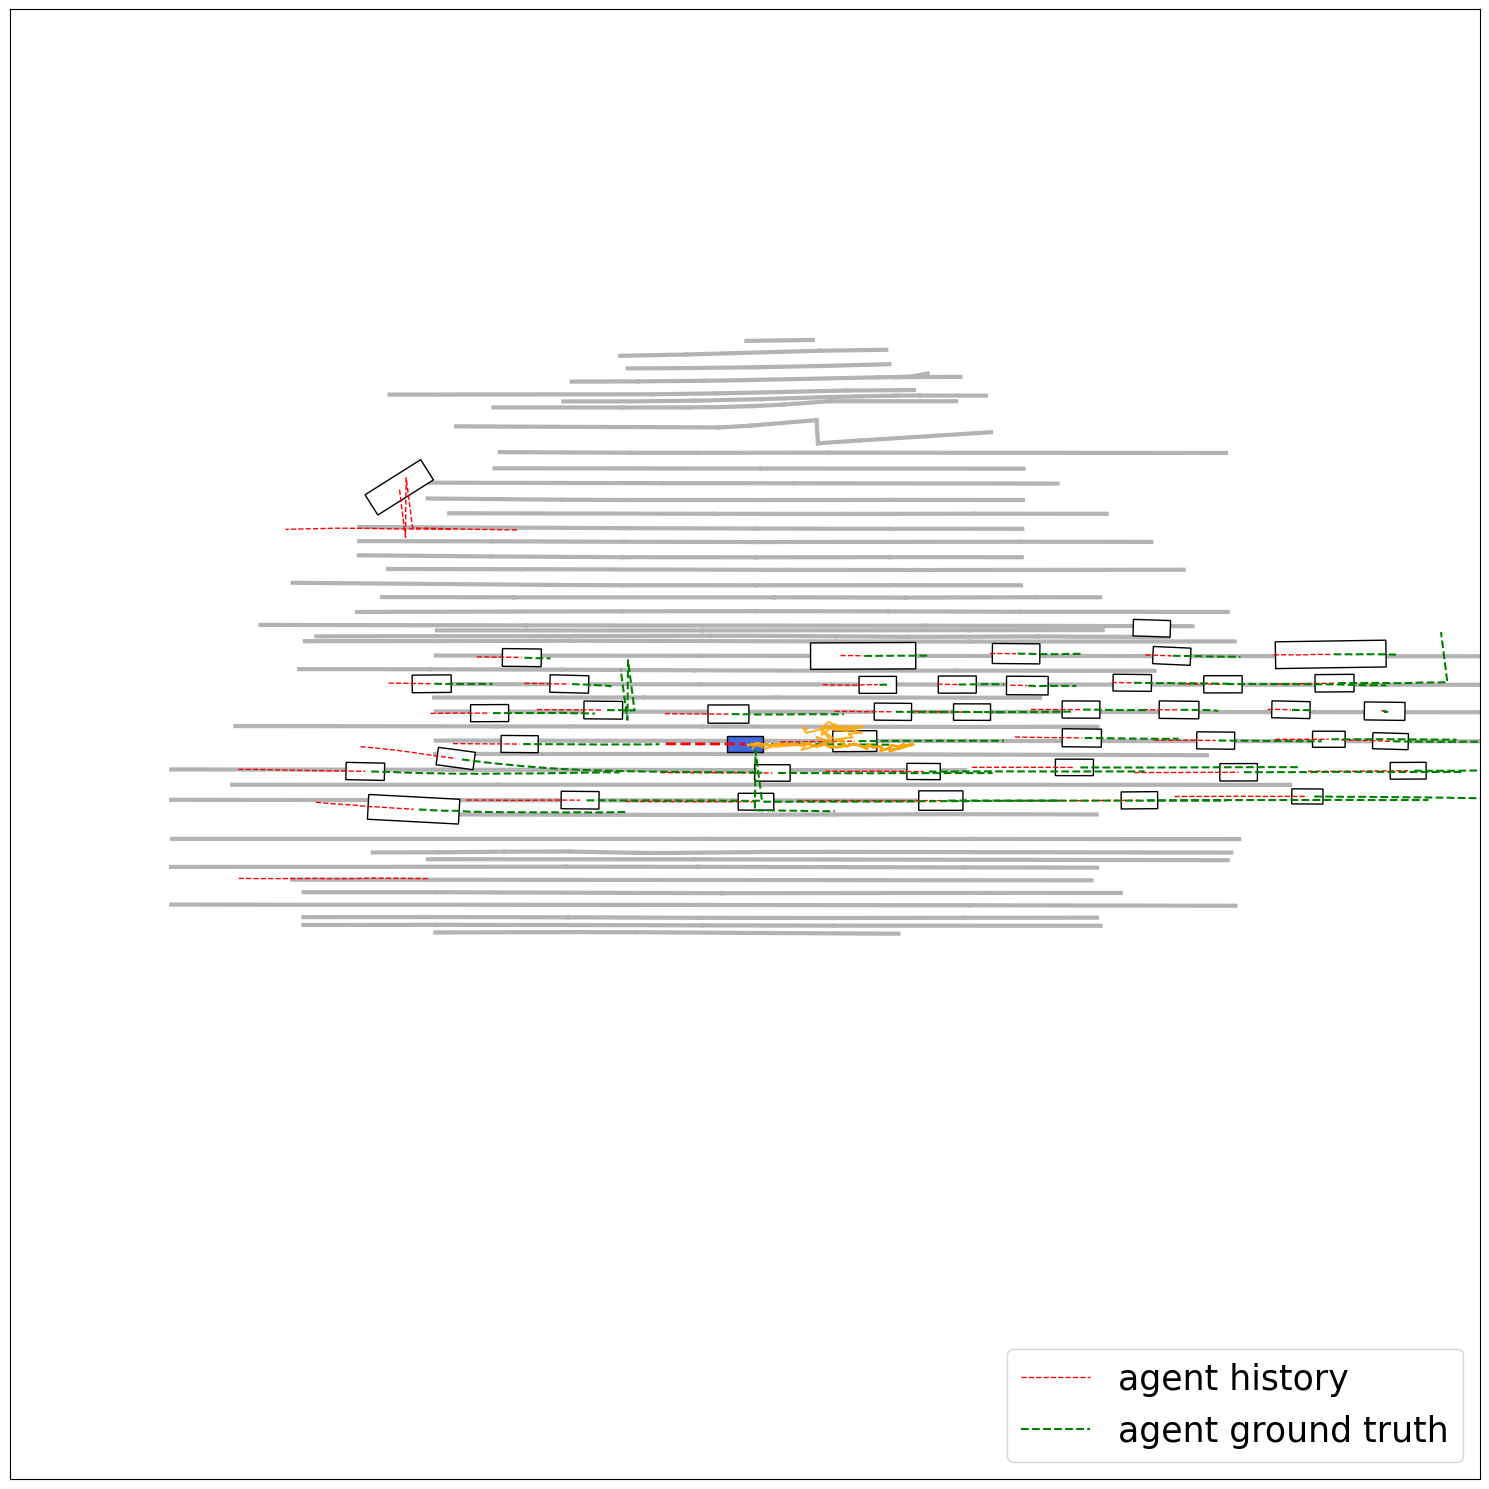

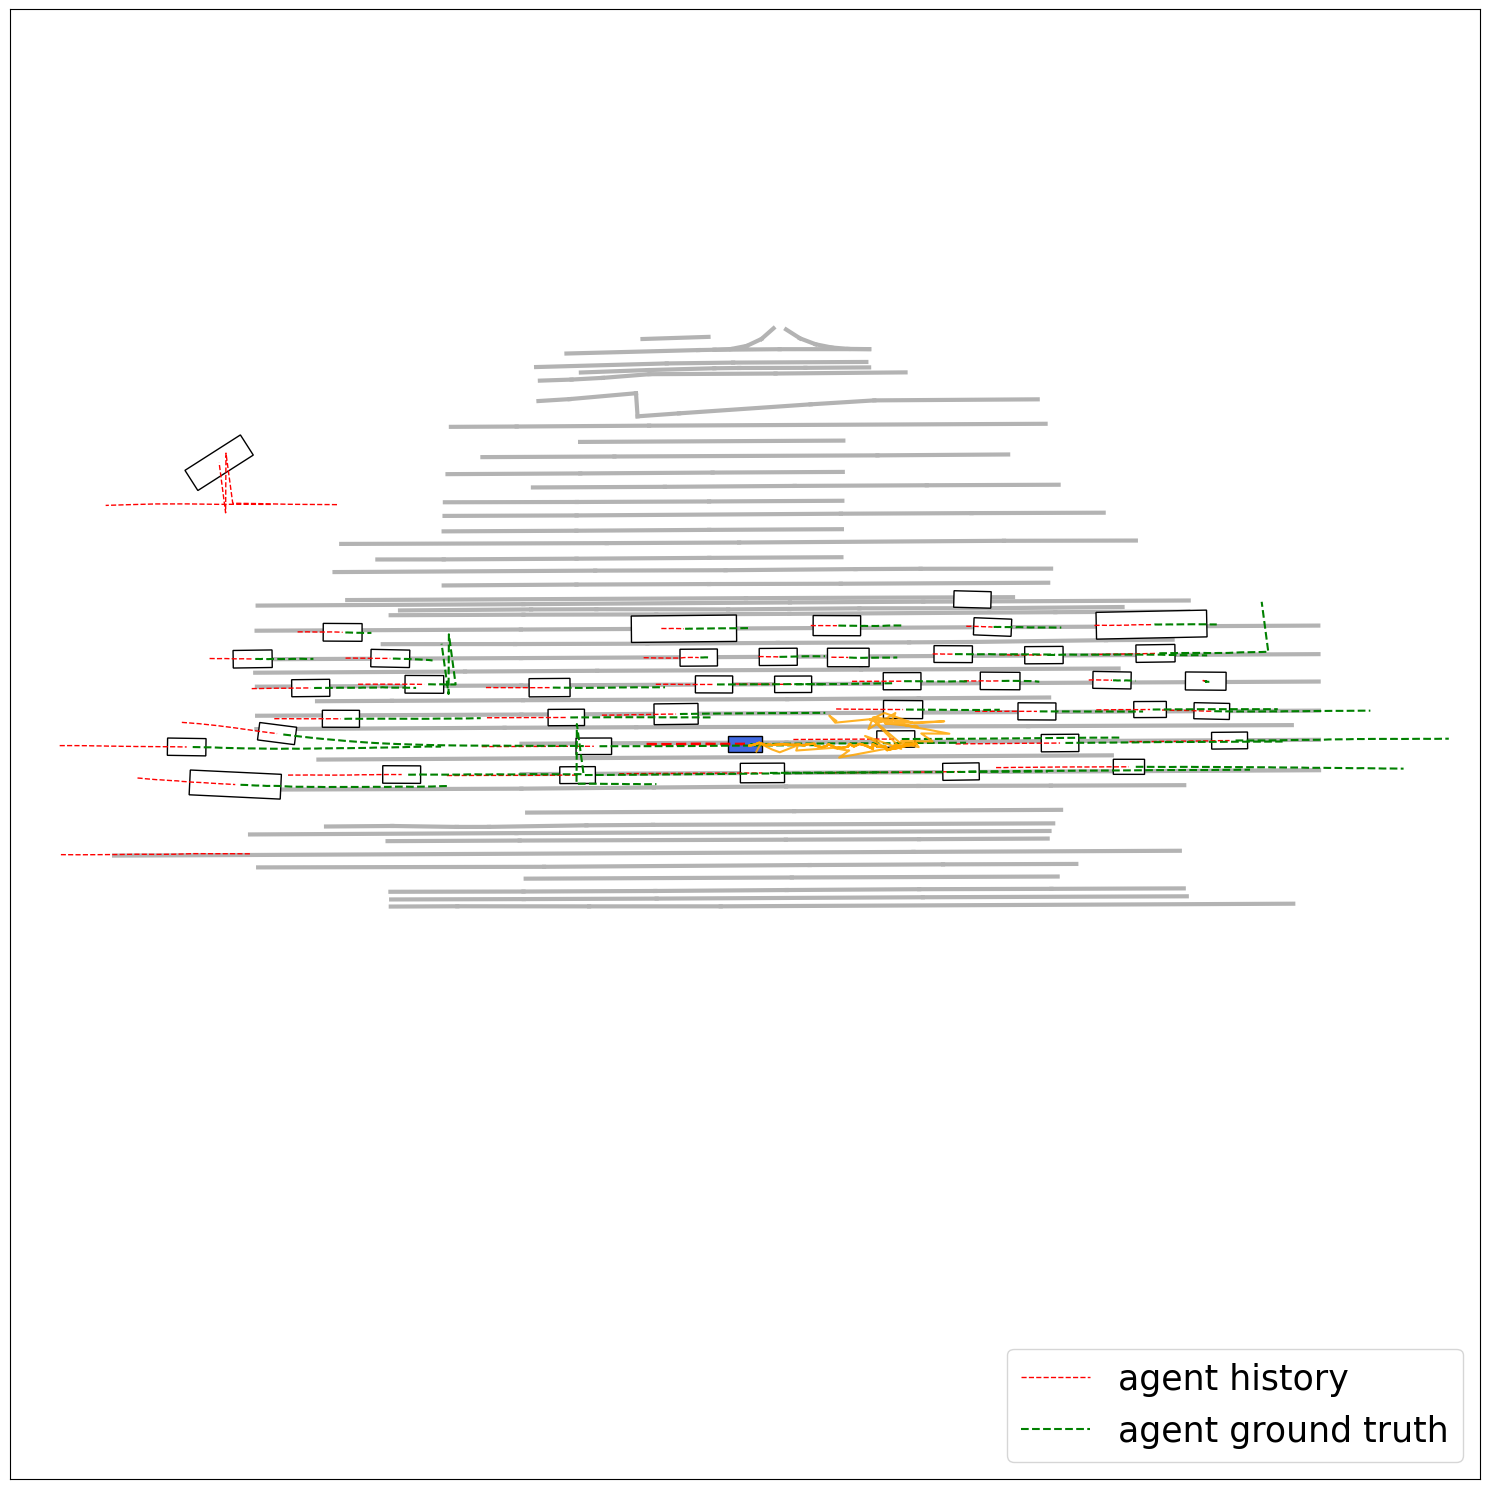

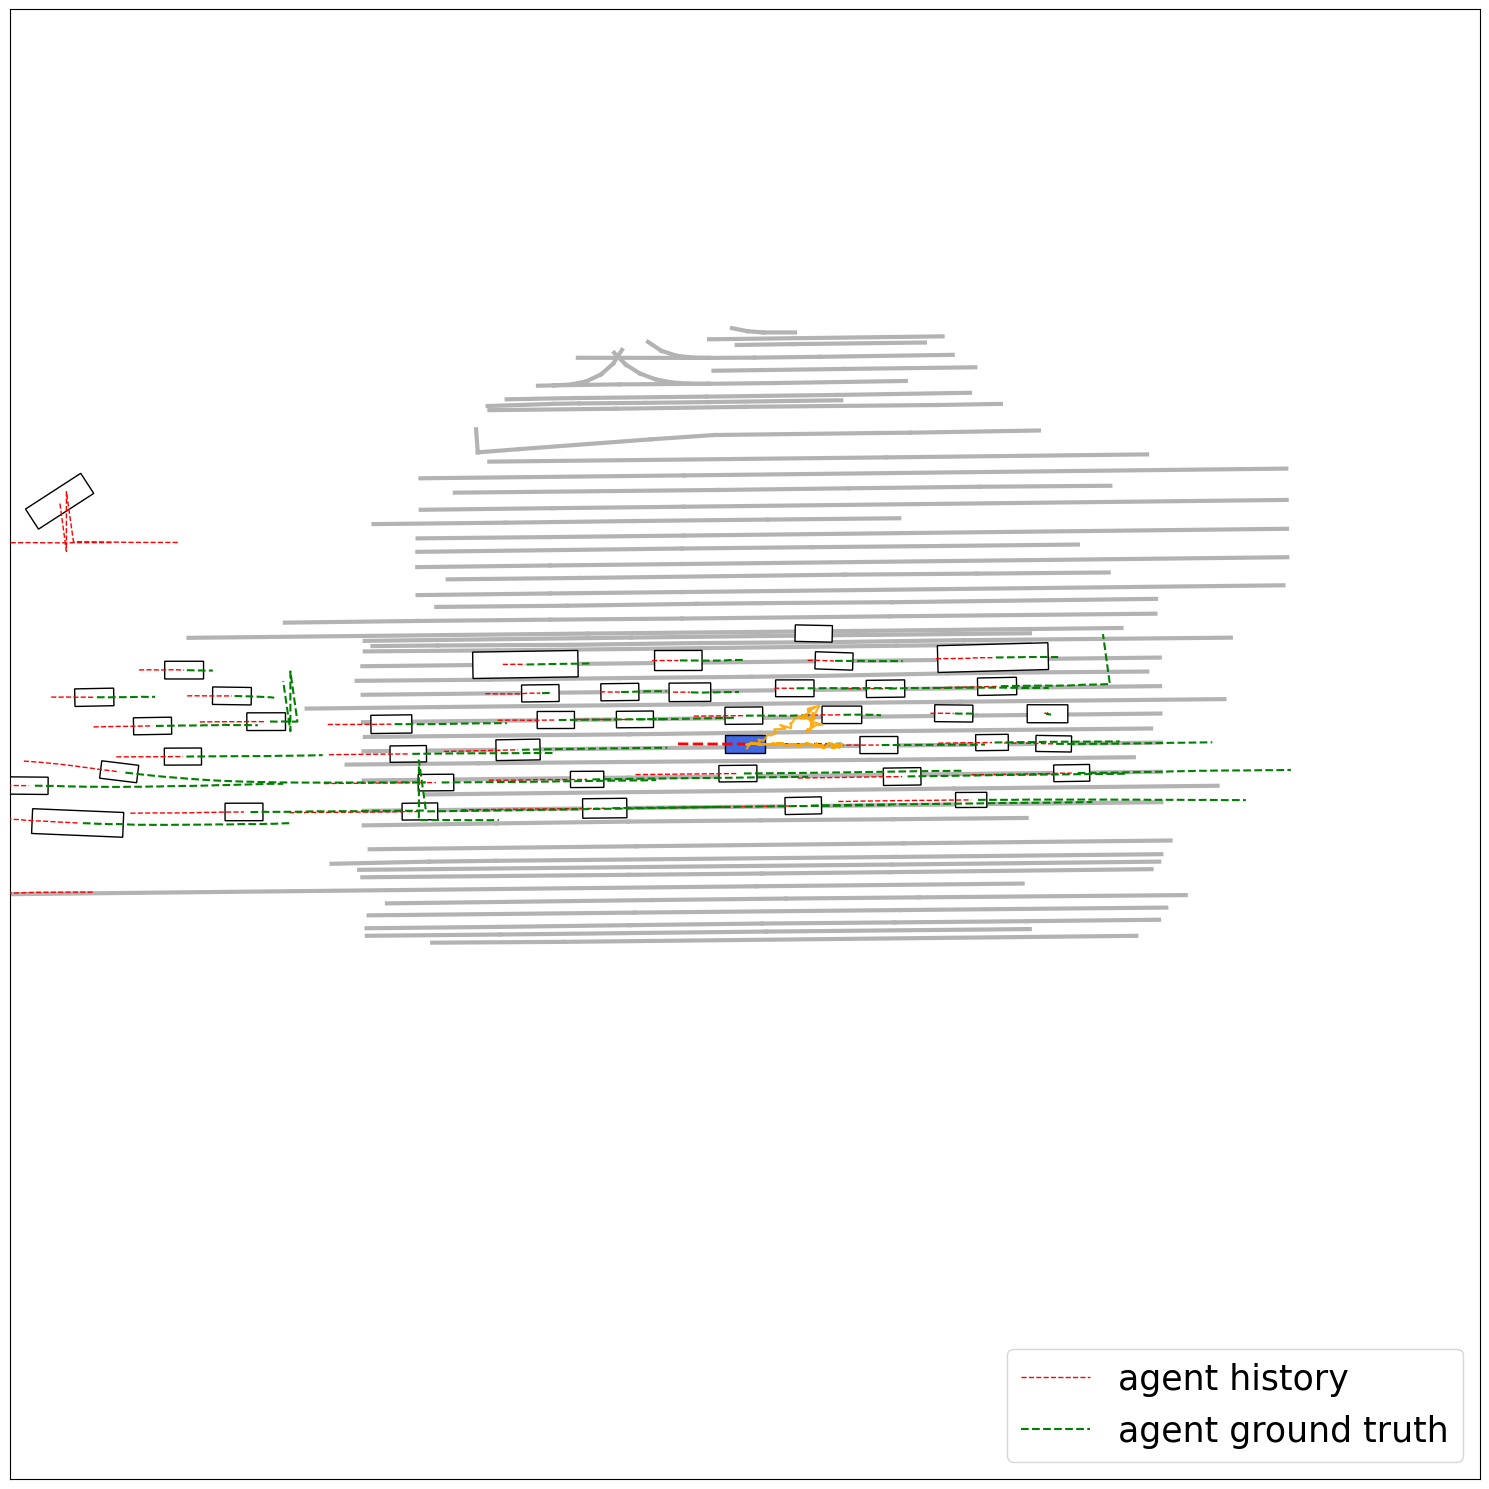

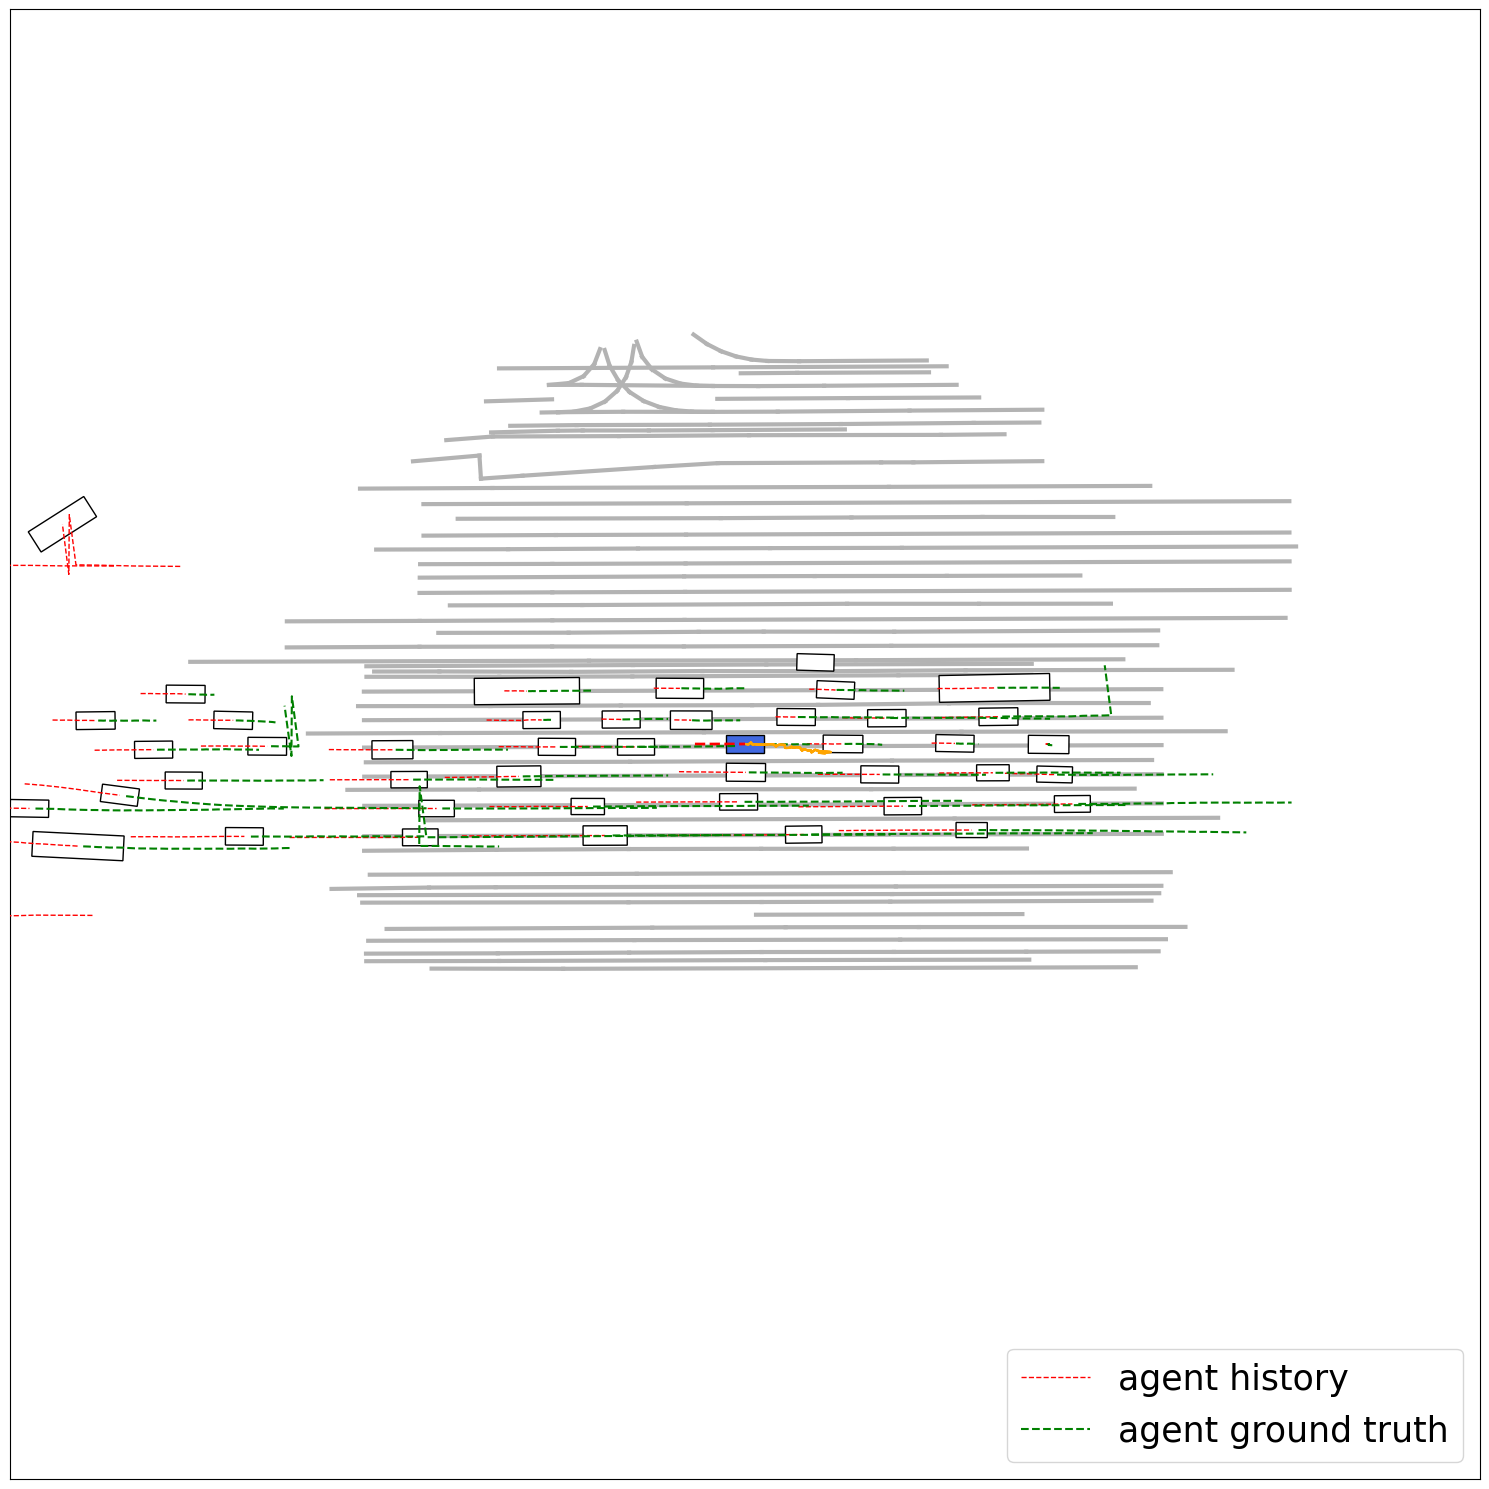

100%|██████████| 500/500 [00:53<00:00,  9.33it/s]
INFO:root:Epoch: 5, Last loss: 379.3703308105469


In [11]:
NUM_BATCH = 500
NUM_EPOCH = 5
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
batch_dicts = []

for epoch in range(NUM_EPOCH): 
    model.set_epoch(epoch)
    last_loss = None
    for batch_idx in tqdm(range(NUM_BATCH)): 
        batch_dict, actions, _, _ = next(train_iterator)
        loss, tb_dict, disp_dict, batch_dict = model(batch_dict)
        # loss = loss_fn(batch_dict['pred_list'][-1][1][:, 0, :, :2], batch_dict['input_dict']['center_gt_trajs'][..., :2].cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        last_loss = loss.item()
        # batch_dicts.append((loss.detach(), [batch_dict['pred_list'][-1][1][:, 0, :, :2].detach(), batch_dict['input_dict']['center_gt_trajs'][..., :2]]))
        if (batch_idx == NUM_BATCH-1): 
            plot_scenario(
                input_dict=batch_dict['input_dict'],
                forward_ret_dict=batch_dict['forward_ret_dict'],
                num_samples=10,
                plot_object_history=True, 
                plot_object_gt_future=True,
                plot_ego_object_pred_future=True,
            )
            plt.show()

    logging.info(f"Epoch: {epoch + 1}, Last loss: {last_loss}")

In [12]:
control_mask = env.cont_agent_mask

obs = env.reset(control_mask)

In [13]:
# Extract full expert trajectory
expert_actions, _, _, _ = env.get_expert_actions()

expert_actions.shape # Shape: (num_envs, num_steps, num_agents, num_actions)

torch.Size([4, 64, 91, 3])

In [14]:
# Reset environment
obs = env.reset(control_mask)
done_envs = []

frames = {f"env_{i}": [] for i in range(NUM_ENVS)}

# Step through the scene
for t in range(env.episode_len):

    env.step_dynamics(expert_actions[:, :, t, :])
    
    dones = env.get_dones()
    
    # Render the scenes
    env_indices = [i for i in range(NUM_ENVS) if i not in done_envs]
    figs = env.vis.plot_simulator_state(
        env_indices=env_indices,
        time_steps=[t]*NUM_ENVS,
        zoom_radius=100,
        #center_agent_indices=[0]*NUM_ENVS,
    )
    for i, env_id in enumerate(env_indices):
        frames[f"env_{env_id}"].append(img_from_fig(figs[i])) 
    
    # Check if done
    for env_id in range(NUM_ENVS):
        if dones[env_id].all():
            done_envs.append(env_id)


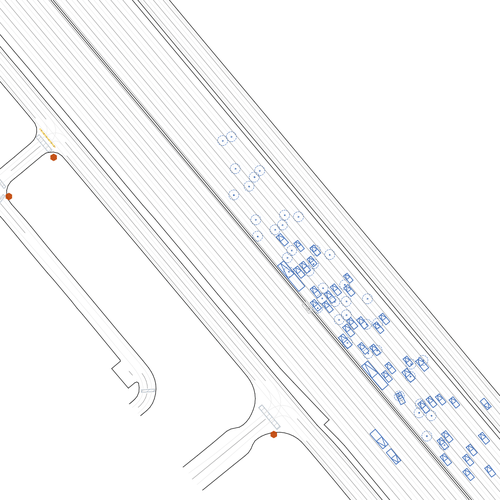
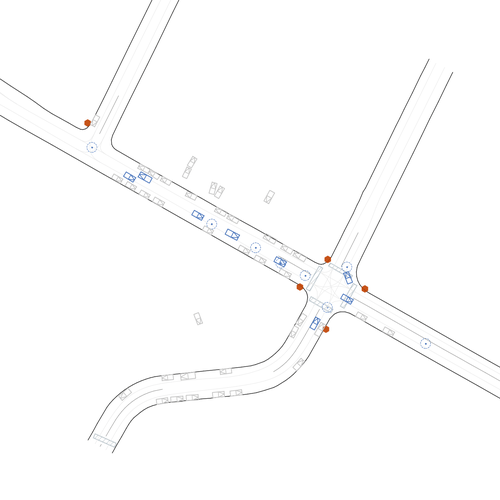
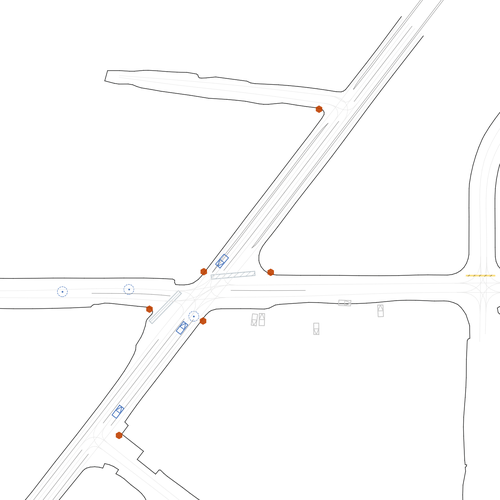
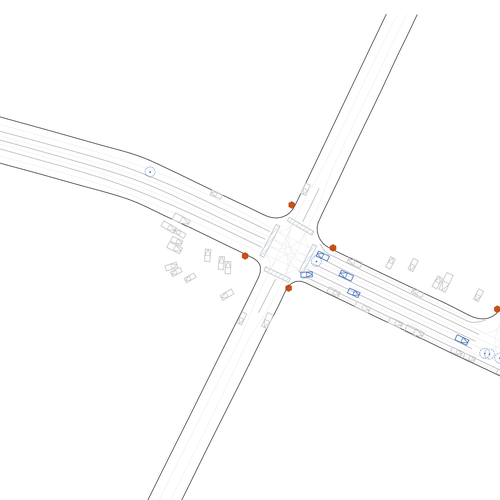

In [70]:
import mediapy
mediapy.show_videos(frames, fps=15, columns=1, codec='gif', width=500)

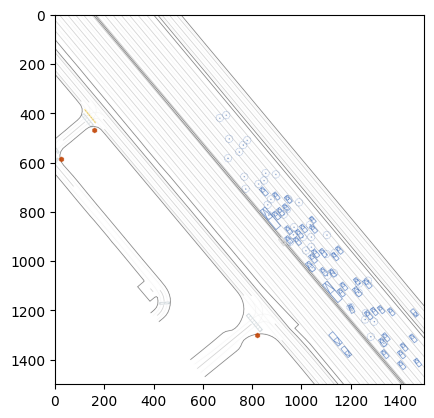

In [25]:
plt.imshow(frames['env_0'][0])

0
1
2
3
4
6
8
9
10
13
14
34
38
39
52
53
55
67
69
70
71
72
73
74
75


(array([1.1000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        2.1000e+01, 1.8000e+01, 1.8000e+01, 2.3000e+01, 1.8000e+01,
        5.3000e+01, 2.7900e+02, 3.5700e+02, 5.8500e+02, 4.8800e+02,
        8.1200e+02, 6.4800e+02, 1.9286e+04, 7.7000e+01, 1.3200e+02,
        7.6000e+01, 1.1600e+02, 3.4000e+01, 3.4000e+01, 8.0000e+00,
        1.9000e+01, 2.6000e+01, 3.3000e+01, 3.7000e+01, 2.7000e+01,
        1.4000e+01, 0.0000e+00, 1.2000e+01, 4.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 7.0000e+00,
        3.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.00

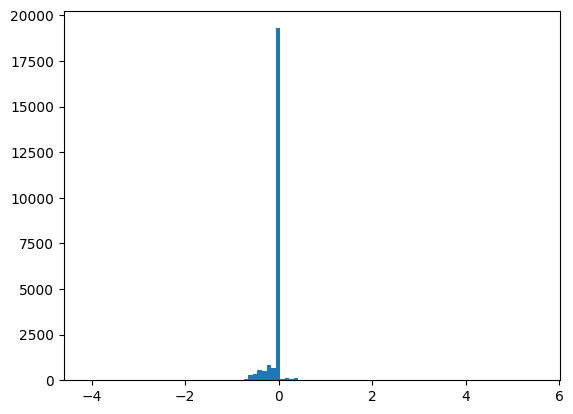

In [71]:
'''
Experimentally clip the difference in positions
'''
from gpudrive.datatypes.observation import (
    LocalEgoState,
    GlobalEgoState,
)

env.reset()
global_ego = GlobalEgoState.from_tensor(
    abs_self_obs_tensor=env.sim.absolute_self_observation_tensor(),
    backend=env.backend,
    device="cpu:1"
)
env_idx = 0
obs_0 = global_ego.pos_x
differences = torch.Tensor([])
obs_0
for i in range(env.episode_len): 
    env.step_dynamics(expert_actions[:, :, i, :])
    global_ego = GlobalEgoState.from_tensor(
        abs_self_obs_tensor=env.sim.absolute_self_observation_tensor(),
        backend=env.backend,
        device="cpu:1"
    )
    obs_1 = global_ego.pos_x
    diff = (obs_1 - obs_0) * (abs(global_ego.pos_x) < 1_000)
    if (abs(diff)).max() > 2:
        print(i)
    differences = torch.concat([differences, diff])
    obs_0 = obs_1

plt.hist(differences.flatten(), bins=100)

In [34]:
obs_1 - obs_0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

tensor([[[0.0630, 0.1516, 0.1314,  ..., 0.0000, 0.0000, 0.0000],
         [0.0623, 0.1420, 0.1341,  ..., 0.0000, 0.0000, 0.0000],
         [0.0433, 0.1633, 0.1456,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.1550, 0.1354,  ..., 0.0000, 0.0000, 0.0000],
         [0.0232, 0.1515, 0.1469,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1516, 0.1346,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.1527, 0.1351,  ..., 0.0000, 0.0000, 0.0000],
         [0.0127, 0.1597, 0.1463,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1605, 0.1422,  ..., 0.0000, 0.0000, 0.